In [ ]:
# !pip install transformers
!pip install datasets
# !pip install transformers==4.37.2
!pip install transformers==4.30
!pip install seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 13.4 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 60.0 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.19.1
    Uninstalling tokenizers-0.19.1:
      Successfully uninstalled tokenizers-0.19.1
  Attempting uninstall: transformers
    Found existing installatio

In [ ]:
# BIES:
# if an entity is a single word: S-
# if an enetiy is 2 words separated by " ": e.g. "ascorbic acid" -> "ascorbic", "acid" -> B-drug-<relation type>-1, E-<drug>-<relation type>-1
# if an entity is multiple word separated by " ": e.g. "ascorbic acid 1" -> B-, I-, E-
# label general format: if entity is not in a relation: <prefix>-<entity type>
#                       if entity is in a relation: <prefix>-<entity type>-<relation type>-<1 or 2>

# labeled_text_all: ["alcohol interacts with drug1"] ner tags:["S-drug-effect-1", "O", "O", "O", "S-drug-effect-2"]

In [ ]:
import pandas as pd
import numpy as np
from xml.dom import minidom
import os
import json
import string
import operator
from transformers import AutoTokenizer, DataCollatorForTokenClassification,  AutoModelForTokenClassification, AdamW, get_scheduler
from collections import Counter
from seqeval.metrics import classification_report, f1_score
from tqdm import tqdm
from google.colab import drive
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import io
import sys
from collections import Counter

import torch
from torch.utils.data import DataLoader
# from tensorflow.keras.preprocessing.sequence import pad_sequences
# from transformers import AutoTokenizer
# from tensorflow.keras.models import load_model


# Mount

In [ ]:
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:

PROJ_DIR = '/content/gdrive/MyDrive/NLP_final_project'
TRAIN_DIR = PROJ_DIR+"/DDICorpus/Traintrain"
VAL_DIR = PROJ_DIR+"/DDICorpus/Trainvalidation"
TEST_DIR = PROJ_DIR+"/DDICorpus/Test/Test_for_DDI_Extraction_task/all"
ANNOT_DIR = PROJ_DIR+"/DDICorpusBrat"
MODEL_DIR = '/content/gdrive/MyDrive/checkpoints'
DIR_PREFIX = '/content/gdrive/MyDrive'

# NER

In [ ]:
val_drugs = []
for drug in os.listdir(VAL_DIR):
  drug_path = os.path.join(VAL_DIR, drug)
  if drug_path.endswith(".xml"):
    val_drugs.append(drug.split('.')[0])

val_annot_list = []
for drug in os.listdir(os.path.join(ANNOT_DIR, "Train/all")):
  # drug_path = os.path.join(ANNOT_DIR, "Train", drug)
  drug_path = drug.split('.')[0]
  # print(drug_path)
  if drug_path in val_drugs:
    # drug_path = os.path.join(ANNOT_DIR, "Train/all", drug)

    # target_path = os.path.join(ANNOT_DIR, "Val/all", drug)
    val_annot_list.append(drug_path)
    # print(drug_path, target_path)



val_drugs = sorted(val_drugs)
val_annot_list = sorted(val_annot_list)
print(len(val_drugs),val_drugs)
print(len(val_annot_list), val_annot_list)



143 ['10150268', '1089034', '10959916', '1109248', '1113260', '11134454', '11137351', '11151029', '1115445', '11154900', '11155575', '11160777', '1116650', '11198959', '11199955', '11213561', '11217867', '11218973', '19-norandrostenedione_ddi', '3881917', '4038510', '6100240', '7476793', '7632757', '7635041', '7756960', '7780789', '7798493', '8542840', 'Abarelix_ddi', 'Acarbose_ddi', 'Acetazolamide_ddi', 'Acetohydroxamic Acid_ddi', 'Adinazolam_ddi', 'Alefacept_ddi', 'Alitretinoin_ddi', 'Alteplase_ddi', 'Altretamine_ddi', 'Aminocaproic Acid_ddi', 'Aminohippurate_ddi', 'Amphotericin B_ddi', 'Ampicillin_ddi', 'Amprenavir_ddi', 'Anagrelide_ddi', 'Anidulafungin_ddi', 'Apraclonidine_ddi', 'Arformoterol_ddi', 'Auranofin_ddi', 'Azatadine_ddi', 'Baclofen_ddi', 'Benazepril_ddi', 'Bentoquatam_ddi', 'Bepridil_ddi', 'Bimatoprost_ddi', 'Bisoprolol_ddi', 'Bosentan_ddi', 'Brimonidine_ddi', 'Brinzolamide_ddi', 'Buspirone_ddi', 'Busulfan_ddi', 'Caffeine_ddi', 'Calcium Acetate_ddi', 'Candesartan_ddi', 'C

In [ ]:

# BIES (begin, inside end, single)
# S-drug-M-1 : single word drug multiple rel arg1
def get_entity_dict(sentence_dom):
    entities = sentence_dom.getElementsByTagName('entity')
    entity_dict = {}
    for entity in entities:
        id = entity.getAttribute('id')
        word = entity.getAttribute('text')
        entity_dict[id] = word
    return entity_dict


def get_drug_list(data_dir):
    # Get a list of all files in data dir
    train_files = [f for f in os.listdir(
        data_dir) if os.path.isfile(os.path.join(data_dir, f))]
    # print(len(train_files))
    drug_names = [f.split("_")[0] for f in train_files  if f != '.DS_Store']
    print(f"====== extracted drug name:{drug_names}=============")
    drug_names = [f.split(".")[0] for f in train_files if f != '.DS_Store']
    drug_names = np.unique(drug_names)
    #  print("Total", len(drug_names), " unique drugs")
    # print(len(drug_names))
    return drug_names


def get_pred_rels_by_type(pred_df):
  rels_by_type = {r:[] for r in RELS}

  for r in RELS:
    for i in range(pred_df.shape[0]):
      if pred_df.iloc[i]['rel_type'] == r.lower():
        pair = set([pred_df.iloc[i]['doc_id'].lower(), pred_df.iloc[i]['arg1'], pred_df.iloc[i]['arg2']])
        rels_by_type[r].append(pair)
  return rels_by_type



def parse_annot(annot):
    ents = []
    rels = []
    count = 0
    for i in range(annot.shape[0]):
        if isinstance(annot, pd.DataFrame):
            if annot.iloc[i][0].startswith("T"):
              # print(annot.iloc[i])
              if ";" in annot.iloc[i][1]:
                  count += 1
                  class_offset_list = annot.iloc[i][1].split(";")
                  # print(annot.iloc[i][0],class_offset_list)

              else:
                  class_offset = annot.iloc[i][1].split()
                  # Hard coding this cuz the formats are all the same
                  cur_ent_annot = [annot.iloc[i][0],
                                  class_offset[0],
                                  [(int(class_offset[1]), int(class_offset[2]))],
                                  annot.iloc[i][2]]
                  # print("cur_ent_annot", cur_ent_annot)
                  ents.append(cur_ent_annot)

            elif annot.iloc[i][0].startswith("R"):
                class_rel = annot.iloc[i][1].split(' ')
                # print(class_rel)

                if np.isnan(annot.iloc[i][2]):
                    # if len(class_rel) == 3:
                    cur_rel_annot = [annot.iloc[i][0],
                                    class_rel[0],
                                    class_rel[1],
                                    class_rel[2]]
                    rels.append(cur_rel_annot)
                else:
                    class_rel = class_rel.split(";")
                    # print("class_rel", class_rel)

    # if count != 0:
    #     print(count,"==============================")
    return ents, rels, count


def get_annots(data_dir, drugs_all_set):
  annot_drug_list = []
  annot_all = {}
  dir_file_list = os.listdir(data_dir)

  for i in range(len(dir_file_list)):
    annot_path = os.path.join(data_dir, dir_file_list[i])
    # print(annot_path)
    if annot_path.endswith(".ann"):
      drug = dir_file_list[i].split(".")[0]
      if drug in drugs_all_set:
        annot_drug_list.append(drug)
      else:
        continue
    else:
      print(annot_path)
      continue
    if os.stat(annot_path).st_size == 0:
      annot = np.array([-1])
    else:
      cur_annot = pd.read_csv(annot_path, sep='\t', header=None)
    parsed_annot = parse_annot(cur_annot)
    annot_all[drug] = parsed_annot
  # print(annot_all)
  ents_all = []
  rels_all = []

  for drug in annot_drug_list:
    for ent in annot_all[drug][0]:
      # print(len(ent), ent)
      ents_all.append([drug] + ent[:2] + ent[2] + [ent[3]])

    # ents_all.append([drug] + [ent[0]])
    for rel in annot_all[drug][1]:
      rels_all.append([drug] + [rel[1].lower(), rel[2], rel[3]])
  rels_all = pd.DataFrame(rels_all)
  # print(rels_all)
  rels_all.columns = ["doc_id", "rel_type", "arg1", "arg2",]
  ents_all = pd.DataFrame(ents_all)
  ents_all.columns = ["doc_id", "ent_id", "ent_type", "ent_offset", "ent_name"]
  # print(ents_all)

  return annot_drug_list, annot_all, rels_all, ents_all


In [ ]:
"""
Get Entity list from xml file

doc_id ent_id ent_name ent_type ent_start_idx ent_end_idx
offset here is doc offset not sentence offset
"""
ANNOT_DIR_TRAINVAL = os.path.join(ANNOT_DIR, "Train/all")
ANNOT_DIR_TEST = os.path.join(ANNOT_DIR, "Test/all")

drugs_all_train = get_drug_list(TRAIN_DIR)
drugs_all_test = get_drug_list(TEST_DIR)
(train_annot_drugs,
 train_annot_all,
 train_rels_all,
 train_ents_all) = get_annots(ANNOT_DIR_TRAINVAL, drugs_all_train)

val_annot_drugs = []
val_annot_all = {}
val_rels_all = []
val_ents_all = []

for i in range(len(train_annot_drugs)):
  # print(train_annot_drugs[i])
  if train_annot_drugs[i] in val_drugs:
    print(train_annot_drugs[i], "already in val_drugs")

    val_drugs.append(train_annot_drugs[i])
    val_annot_drugs.append(train_annot_drugs[i])
    val_annot_all[train_annot_drugs[i]] = train_annot_all[train_annot_drugs[i]]

(test_annot_drugs,
 test_annot_all,
 test_rels_all,
 test_ents_all) = get_annots(ANNOT_DIR_TEST, drugs_all_test)

# print(val_rels_all.shape)
# print(val_ents_all.shape)
print(val_drugs)

====== extracted drug name:['Bicalutamide', 'Estradiol', 'Disopyramide', 'Clemastine', 'Cidofovir', 'Aciclovir', 'Meclofenamic acid', 'Albendazole', 'Dextroamphetamine', 'Cefotetan', 'Diethylstilbestrol', 'Epirubicin', 'Clindamycin', 'Peginterferon alfa-2a', 'Cefepime', 'Ibritumomab', 'Eptifibatide', 'Cortisone acetate', 'Fosfomycin', 'Duloxetine', 'Delavirdine', 'Epinephrine', 'Nimodipine', 'Neomycin', 'Lapatinib', 'Cyclobenzaprine', 'Bleomycin', 'Levetiracetam', 'Gemcitabine', 'Alclometasone', 'Butabarbital', 'Escitalopram', 'Fenoprofen', 'Clobazam', 'Lamivudine', 'Flupenthixol', 'Sulfapyridine', 'Oxcarbazepine', 'Glycopyrrolate', 'Lincomycin', 'Isosorbide Mononitrate', 'Azlocillin', 'Ardeparin', 'L-Glutamine', 'Botulinum Toxin Type B', 'Alfentanil', 'Aminolevulinic acid', 'Fulvestrant', 'Chloroprocaine', 'Lovastatin', 'Cephalexin', 'Benztropine', 'Iloprost', 'Adalimumab', 'Aliskiren', 'Losartan', 'Darbepoetin alfa', 'Gefitinib', 'Isotretinoin', 'Bumetanide', 'Atomoxetine', 'Bentirom

In [ ]:
print(len(train_annot_drugs), " train texts (drugbank+medline)")
print(len(val_drugs), " val texts (drugbank+medline)")
print(len(test_annot_drugs), "test texts (drugbank+medline)")

# types of relations in each split
print(Counter(train_rels_all["rel_type"]))
# print(Counter(val_rels_all["rel_type"]))
print(Counter(test_rels_all["rel_type"]))

571  train texts (drugbank+medline)
143  val texts (drugbank+medline)
191 test texts (drugbank+medline)
Counter({'effect': 1394, 'mechanism': 946, 'advise': 719, 'int': 167})
Counter({'effect': 360, 'mechanism': 302, 'advise': 221, 'int': 96})


In [ ]:
rel_type_label = {"mechanism": "ME", "effect": "EF", "advise": "AD", "int": "INT", "M": "M"}
label_rel_type = {"ME": "mechanism", "EF": "effect", "AD": "advise", "INT": "int", "M": "M"}

## DDI Pre-processing

In [ ]:


# from tensorflow.keras.models import load_model


rel_type_label = {"mechanism": "ME", "effect": "EF", "advise": "AD", "int": "INT", "M": "M"}
label_rel_type = {"ME": "mechanism", "EF": "effect", "AD": "advise", "INT": "int", "M": "M"}
# BIES (begin, inside end, single)
# S-drug-M-1 : single word drug multiple rel arg1
def get_entity_dict(sentence_dom):
    entities = sentence_dom.getElementsByTagName('entity')
    entity_dict = {}
    for entity in entities:
        id = entity.getAttribute('id')
        word = entity.getAttribute('text')
        entity_dict[id] = word
    return entity_dict


def get_drug_list(data_dir):
    # Get a list of all files in data dir
    train_files = [f for f in os.listdir(
        data_dir) if os.path.isfile(os.path.join(data_dir, f))]
    # print(len(train_files))
    drug_names = [f.split("_")[0] for f in train_files  if f != '.DS_Store']
    print(f"====== extracted drug name:{drug_names}=============")
    drug_names = [f.split(".")[0] for f in train_files if f != '.DS_Store']
    drug_names = np.unique(drug_names)
    #  print("Total", len(drug_names), " unique drugs")
    # print(len(drug_names))
    return drug_names


def label_sentence(sent, sent_annot):

    # entity_new_id_rev_dict = {v:k for k,v in entity_new_id_dict.items()}
    sent_split = sent.strip().split()
    labels = []
    ner_tags = len(sent_split)*["O"]
    # heads = []
    # print("------", len(sent_annot), sent_annot)
    # No entities, all words are O
    if len(sent_annot) == 1:
        # for i in range(len(sent_split)):
            # sent_split[i] = sent_split[i]+"\tO"
        ner_tags = len(sent_split)*["O"]

    # Normal entities, no relations, ents label are B-ent_type, others O
    elif len(sent_annot) >= 4:
        ent2label = sent_annot[2]
        ent2id = sent_annot[3]
        id2ent = {v:k for k,v in ent2id.items()}
        ner_tags =  len(sent_split)*["O"]
        all_ents = [ent2id[entity]+"|"+entity[0] if len(ent2label[entity]) == 1 else ent2id[entity]+"|"+entity[0].split()[0] for entity in sent_annot[1].keys()]
        # print("all_ents>=4", all_ents)
        i = 0
        while i < len(sent_split):
            if sent_split[i] in all_ents:
                # print("ents>=4 in all_ents", sent_split[i])
                cur_ent = sent_split[i].split("|")
                cur_label = cur_ent[0]
                if cur_label not in labels:
                  labels.append(cur_label)
                if len(ent2label[id2ent[cur_label]]) == 1:
                  sent_split[i] = cur_ent[1]
                  ner_tags[i] = ent2label[id2ent[cur_label]][0]
                  i += 1
                else:
                  ent_len = len(ent2label[id2ent[cur_label]])
                  sent_split[i] = cur_ent[1]
                  ner_tags[i:i+ent_len] = ent2label[id2ent[cur_label]]
                  i += ent_len

            else:
                # print("ents2 not in all_ents", sent_split[i])
                i += 1
    # print("final split",sent_split)
    # print("final ner tags",ner_tags)

    return sent_split, ner_tags, labels


def ner_tagging(sentence_annot):
    tagged_all = []
    labeled_all = []
    labels_all = []
    ent2id_all = []
    ner_tags_all = []
    entity_count = 0
    labeled_all_dict = []
    # BIES (begin, inside end, single)
    # S-drug-M-1 : single word drug multiple rel arg1

    for i in range(len(sentence_annot)):

        sentence_tagged = sentence_annot[i][0]
        ent2id = {}
        # new_sentence = sentence_annot[i][0].translate(str.maketrans({key: " {0} ".format(key) for key in '!"#$%&\'()*+,./:;<=>?@[\\]^`{}~'}))

        # sentence without any entities, just add space around all punctuations for better splitting later
        if len(sentence_annot[i]) == 1:
            new_sentence = sentence_annot[i][0].translate(str.maketrans({key: " {0} ".format(key) for key in '!"#$%&\'()*+,./:;<=>?@[\\]^`{}~'}))


        # sentence with entities, but not annotated relations will have
        # len(sentence_annot[i]) == 3. Any with sentence_annot[i] length > 3
        # is a sentence with relations
        elif len(sentence_annot[i]) >= 4:

            entity_list = sentence_annot[i][1]
            ent2label = sentence_annot[i][2]
            ent2id = sentence_annot[i][3]
            new_sentence = ""
            cur_idx = 0

            # iterate thru all entities in current sentence
            ner_tags = ["O"]*len(sentence_tagged.split())
            cur_word_idx = 0

            for entity in entity_list.keys():
                entity_count += 1
                ent_type = entity_list[entity]

                if ";" not in entity[1]:
                    split_offset = entity[1].split("-")
                    # get integer offset of entity
                    split_offset[0] = int(split_offset[0])
                    split_offset[1] = int(split_offset[1])
                    new_sentence += sentence_tagged[cur_idx:split_offset[0]] + " "+ ent2id[entity] +"|"+entity[0]+" "

                    # new_sentence += sentence_tagged[cur_idx:split_offset[0]] + " "+ ent2id[entity] +"|"+ent_type.lower()+"1s "+entity[0]+" "+ent_type.lower()+"1e "

                    cur_idx = split_offset[1]+1

            new_sentence += sentence_tagged[cur_idx:len(sentence_tagged)]

            # new_sentence = new_sentence.translate(str.maketrans({key: " {0} ".format(key) for key in '!"#$%&\'()*+,./-:;<=>?@[\\]^`{}~'}))
        # print("out new sent", new_sentence)
        # sequence labeling the ner tagged sentence to produce input to LLMs
        # print("new_sentence:", new_sentence)
        new_sentence_labeled, ner_tags, labels = label_sentence(new_sentence, sentence_annot[i])

        # save some metadata
        ent2id_all.append(ent2id)
        # save ner tagged sentence and sequence labeled sentence
        tagged_all.append(new_sentence)
        labeled_all.append(new_sentence_labeled)
        labels_all.append(labels)
        ner_tags_all.append(ner_tags)

    return tagged_all, ent2id_all, labeled_all, labels_all, ner_tags_all


def run_preprocess(data_dir):

    # get all drug names
    drug_list = get_drug_list(data_dir)

    count = 0
    sentence_annot_all = {}
    ent2id_all = {}
    tagged_text_all = []
    ddi_count_all = 0
    labeled_text_all = []
    labels_all = []
    drugs_all = []
    ner_tags_all = []
    for drug in drug_list:
        # print(drug, " =================")
        # Each xml file correspond to a drug
        file_path = os.path.join(data_dir, drug+".xml")

        # xml parser
        dom = minidom.parse(file_path)
        # Get all sentences from drug xml
        sentences = dom.getElementsByTagName('sentence')
        # print(len(sentences), "sentences in this text =====")

        sentence_orig = []
        sentence_annot = []

        cur_id = 1
        # iterate thru sentences of the current abstract
        for i in range(len(sentences)):
            ddi_count = 0
            sentence = sentences[i]
            sentence_text = sentence.getAttribute('text')
            sentence_orig.append(sentence_text)
            # print(sentence_text)

            entity_list = {}
            # Check if there are annotated entities in the sentence
            if sentence.hasChildNodes():
                entity_dict = {}
                entities = sentence.getElementsByTagName('entity')
                ent2label = {}
                ent2id = {}
                ent_id = {}

                # entity id to entity name mapping
                for entity in entities:

                    id = entity.getAttribute('id')
                    word = entity.getAttribute('text')
                    word_type = entity.getAttribute('type')
                    offset = entity.getAttribute('charOffset')
                    if ";" in offset:
                        count += 1
                    entity_dict[id] = (word, offset)
                    entity_list[(word, offset)] = word_type
                    ent2id[(word, offset)] = "T"+str(cur_id)

                    cur_id += 1

                    # this is to make sure non-relation ents gets a label too
                    ent_split = word.split()
                    if len(ent_split) == 1:

                      ent2label[(word, offset)] = ["S-"+word_type]
                    elif len(ent_split) == 2:
                      ent2label[(word, offset)] = ["B-"+word_type, "E-"+word_type]
                    else:
                      ent2label[(word, offset)] = []
                      for i in range(len(ent_split)):
                        if i == 0:
                          ent2label[(word, offset)].append("B-"+word_type)
                        elif i == len(ent_split)-1:
                          ent2label[(word, offset)].append("E-"+word_type)
                        else:
                          ent2label[(word, offset)].append("I-"+word_type)

                    # print("ent2label out", ent2label)
                # get relations in the current sentence
                rels = sentence.getElementsByTagName('pair')

                sent_with_rel = False
                ent_count = {}
                all_rels = []
                # ent2label = {}
                # label2ent = {}
                for rel in rels:
                    ddi_flag = rel.getAttribute('ddi')
                    # check if relation pair is a DDI (our target relations)
                    if ddi_flag == "true" and rel.getAttribute('type') != '':
                        ddi_count += 1
                        sent_with_rel = True
                        arg1 = rel.getAttribute('e1')
                        arg2 = rel.getAttribute('e2')
                        rel_class = rel.getAttribute('type')
                        if entity_dict[arg1] not in ent_count:
                            ent_count[entity_dict[arg1]] = 1
                        else:
                            ent_count[entity_dict[arg1]] += 1

                        if entity_dict[arg2] not in ent_count:
                            ent_count[entity_dict[arg2]] = 1
                        else:
                            ent_count[entity_dict[arg2]] += 1
                        # print(entity_dict[arg1], entity_dict[arg2], rel_class)

                        all_rels.append([entity_dict[arg1], entity_dict[arg2], rel_class])


                if sent_with_rel == False:
                    sentence_annot.append([sentence_text, entity_list, ent2label, ent2id])
                else:

                    # choose a head entity for sequence labelling
                    # the entity that appears the most in a relation is chosen as head
                    # otherwise pick a random one (probably alphabetical)
                    head_choice = max(ent_count.items(), key=operator.itemgetter(1))[0]
                    # print("head_choice", head_choice)
                    temp_head_list = []
                    # print(len(all_rels), " relations in this sentence =======", all_rels)

                    for rel in all_rels:
                        arg1_split = rel[0][0].split()
                        arg2_split = rel[1][0].split()
                        # arg1 in multiple relations
                        if ent_count[rel[0]] > 1:
                          rel_type_counts = [r[2] for r in all_rels if r[0] == rel[0]]
                          # word entity in multiple relations and has 1 relation type
                          if len(np.unique(rel_type_counts)) == 1:
                            arg1_rel_type_label = rel_type_label[rel_type_counts[0]]
                          else:
                            # word entity in multiple relations and has multiple relation types
                            arg1_rel_type_label = "M"
                        else:
                          arg1_rel_type_label =  rel_type_label[rel[2]]
                        # arg2 in multiple relations
                        if ent_count[rel[1]] > 1:
                          rel_type_counts = [r[2] for r in all_rels if r[1] == rel[1]]
                          if len(np.unique(rel_type_counts)) == 1:
                            arg2_rel_type_label = rel_type_label[rel_type_counts[0]]
                          else:
                            # word entity in multiple relations and has multiple relation types
                            arg2_rel_type_label = "M"
                        else:
                          arg2_rel_type_label =  rel_type_label[rel[2]]

                        # single word entity
                        if len(arg1_split) == 1:
                          ent2label[rel[0]] = ["S-"+entity_list[rel[0]]+"-"+arg1_rel_type_label+"-1"]
                        elif len(arg1_split) == 2:
                          # 2-word entity
                          ent2label[rel[0]] = ["B-"+entity_list[rel[0]]+"-"+arg1_rel_type_label+"-1",
                                               "E-"+entity_list[rel[0]]+"-"+arg1_rel_type_label+"-1"]
                        else:
                          ent2label[rel[0]] = []
                          for i in range(len(arg1_split)):
                            if i == 0:
                              ent2label[rel[0]].append("B-"+entity_list[rel[0]]+"-"+arg1_rel_type_label+"-1")
                            elif i == len(arg1_split)-1:
                              ent2label[rel[0]].append("E-"+entity_list[rel[0]]+"-"+arg1_rel_type_label+"-1")
                            else:
                              ent2label[rel[0]].append("I-"+entity_list[rel[0]]+"-"+arg1_rel_type_label+"-1")

                        # ARG2
                        if len(arg2_split) == 1:
                          ent2label[rel[1]] = ["S-"+entity_list[rel[1]]+"-"+arg2_rel_type_label+"-2"]
                        elif len(arg2_split) == 2:
                          # 2-word entity
                          ent2label[rel[1]] = ["B-"+entity_list[rel[1]]+"-"+arg2_rel_type_label+"-2",
                                               "E-"+entity_list[rel[1]]+"-"+arg2_rel_type_label+"-2"]
                        else:
                          ent2label[rel[1]] = []
                          for i in range(len(arg2_split)):
                            if i == 0:
                              ent2label[rel[1]].append("B-"+entity_list[rel[1]]+"-"+arg2_rel_type_label+"-2")
                            elif i == len(arg2_split)-1:
                              ent2label[rel[1]].append("E-"+entity_list[rel[1]]+"-"+arg2_rel_type_label+"-2")
                            else:
                              ent2label[rel[1]].append("I-"+entity_list[rel[1]]+"-"+arg2_rel_type_label+"-2")

                        # if arg1_rel_type_label == "M" or arg2_rel_type_label == "M":
                          # print(ent2label)
                    sentence_annot.append([sentence_text, entity_list, ent2label, ent2id, all_rels])

                if ddi_count > 1:
                    ddi_count_all += 1
                    # print("More than 1 DDI in this sentence", sentence_annot[-1])
            else:
                if sentence_text != "" and sentence_text not in string.punctuation:
                  sentence_annot.append([sentence_text])
                  continue
        # if drug == "21705423":
        # print(sentence_annot)
        tagged_text, ent2id_sents, labeled_text, labels, ner_tags = ner_tagging(sentence_annot)
        ent2id_all[drug] = ent2id_sents

        sentence_annot_all[drug] = sentence_annot
        tagged_text_all.append(tagged_text)
        labeled_text_all.append(labeled_text)
        labels_all.append(labels)
        ner_tags_all.append(ner_tags)
        drugs_all.append(drug)
        # if len(tagged_text_all) == 3:
          # break
    return sentence_annot_all, tagged_text_all, labeled_text_all, labels_all, drugs_all, ner_tags_all, ent2id_all

(sentence_annot_all_train,
 tagged_text_all_train,
 labeled_text_all_train,
 labels_all_train,
 drugs_all_train,
 ner_tags_all_train,
 ent2id_all_train) = run_preprocess(os.path.join(PROJ_DIR, "DDICorpus/Traintrain"))

doc_lengths_train = [len(doc) for doc in labeled_text_all_train]
labeled_text_all_train = [sent for doc in labeled_text_all_train for sent in doc]
labels_all_train = [sent for doc in labels_all_train for sent in doc]
ner_tags_all_train = [sent for doc in ner_tags_all_train for sent in doc]

(sentence_annot_all_val,
 tagged_text_all_val,
 labeled_text_all_val,
 labels_all_val,
 drugs_all_val,
 ner_tags_all_val,
 ent2id_all_val) = run_preprocess(os.path.join(PROJ_DIR, "DDICorpus/Trainvalidation"))

doc_lengths_val = [len(doc) for doc in labeled_text_all_val]
labeled_text_all_val = [sent for doc in labeled_text_all_val for sent in doc]
labels_all_val = [sent for doc in labels_all_val for sent in doc]
ner_tags_all_val = [sent for doc in ner_tags_all_val for sent in doc]


TEST_DIR = os.path.join(PROJ_DIR, "DDICorpus/Test/Test_for_DDI_Extraction_task/all")

(sentence_annot_all_test,
 tagged_text_all_test,
 labeled_text_all_test,
 labels_all_test,
 drugs_all_test,
 ner_tags_all_test,
 ent2id_all_test) = run_preprocess(TEST_DIR)
labels_all_test = [sent for doc in labels_all_test for sent in doc]

doc_lengths_test = [len(doc) for doc in labeled_text_all_test]
labeled_text_all_test = [sent for doc in labeled_text_all_test for sent in doc]
labels_all_test = [sent for doc in labels_all_test for sent in doc]
ner_tags_all_test = [sent for doc in ner_tags_all_test for sent in doc]

print(tagged_text_all_test)

====== extracted drug name:['Bicalutamide', 'Estradiol', 'Disopyramide', 'Clemastine', 'Cidofovir', 'Aciclovir', 'Meclofenamic acid', 'Albendazole', 'Dextroamphetamine', 'Cefotetan', 'Diethylstilbestrol', 'Epirubicin', 'Clindamycin', 'Peginterferon alfa-2a', 'Cefepime', 'Ibritumomab', 'Eptifibatide', 'Cortisone acetate', 'Fosfomycin', 'Duloxetine', 'Delavirdine', 'Epinephrine', 'Nimodipine', 'Neomycin', 'Lapatinib', 'Cyclobenzaprine', 'Bleomycin', 'Levetiracetam', 'Gemcitabine', 'Alclometasone', 'Butabarbital', 'Escitalopram', 'Fenoprofen', 'Clobazam', 'Lamivudine', 'Flupenthixol', 'Sulfapyridine', 'Oxcarbazepine', 'Glycopyrrolate', 'Lincomycin', 'Isosorbide Mononitrate', 'Azlocillin', 'Ardeparin', 'L-Glutamine', 'Botulinum Toxin Type B', 'Alfentanil', 'Aminolevulinic acid', 'Fulvestrant', 'Chloroprocaine', 'Lovastatin', 'Cephalexin', 'Benztropine', 'Iloprost', 'Adalimumab', 'Aliskiren', 'Losartan', 'Darbepoetin alfa', 'Gefitinib', 'Isotretinoin', 'Bumetanide', 'Atomoxetine', 'Bentirom

{'O': 5394, 'group': 3296, 'drug': 5452, 'drug_n': 388, 'brand': 1062}
{'O': 1341, 'group': 1031, 'drug': 1323, 'drug_n': 53, 'brand': 255}
{'O': 1299, 'drug_n': 166, 'drug': 1335, 'group': 850, 'brand': 356}


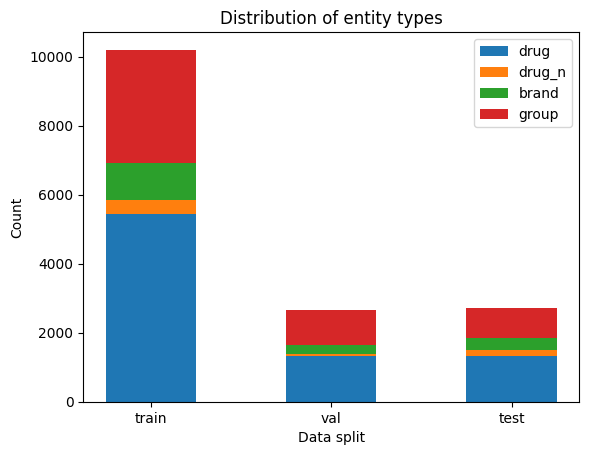

In [ ]:
# Entity counts in different data splits
import matplotlib.pyplot as plt

counts_train = {}

for i in range(len(ner_tags_all_train)):
  counts = Counter(ner_tags_all_train[i])
  # print(counts.keys())
  for j in counts.keys():
    if j.startswith("S"):
      j = j.replace("S-", "")

    elif j.startswith("B"):
      j = j.replace("B-", "")
    elif j.startswith("I"):
      j = j.replace("I-", "")
    elif j.startswith("E"):
      j = j.replace("E-", "")


    j = j.split("-")[0]
    # print(j)
    if j not in counts_train:
      counts_train[j] = 1
    else:
      counts_train[j] += 1
print(counts_train)

counts_val = {}
for i in range(len(ner_tags_all_val)):
  counts = Counter(ner_tags_all_val[i])
  for j in counts.keys():
    if j.startswith("S"):
      j = j.replace("S-", "")

    elif j.startswith("B"):
      j = j.replace("B-", "")
    elif j.startswith("I"):
      j = j.replace("I-", "")
    elif j.startswith("E"):
      j = j.replace("E-", "")


    j = j.split("-")[0]
    if j not in counts_val:
      counts_val[j] = 1
    else:
      counts_val[j] += 1
print(counts_val)

counts_test = {}
for i in range(len(ner_tags_all_test)):
  counts = Counter(ner_tags_all_test[i])
  for j in counts.keys():
    if j.startswith("S"):
      j = j.replace("S-", "")

    elif j.startswith("B"):
      j = j.replace("B-", "")
    elif j.startswith("I"):
      j = j.replace("I-", "")
    elif j.startswith("E"):
      j = j.replace("E-", "")


    j = j.split("-")[0]
    if j not in counts_test:
      counts_test[j] = 1
    else:
      counts_test[j] += 1
print(counts_test)


fig, ax = plt.subplots()
bottom = np.zeros(3)

data_split = (
    "train",
    "val",
    "test"
)

ent_type_counts = {
    "drug": np.array([counts_train["drug"],
                      counts_val["drug"],
                      counts_test["drug"]]),
    "drug_n": np.array([counts_train["drug_n"],
                      counts_val["drug_n"],
                      counts_test["drug_n"]]),
    "brand": np.array([counts_train["brand"],
                      counts_val["brand"],
                      counts_test["brand"]]),
    "group": np.array([counts_train["group"],
                      counts_val["group"],
                      counts_test["group"]])
}
width = 0.5
bottom = np.zeros(3)
for ent_type, ent_type_count in ent_type_counts.items():
    p = ax.bar(data_split, ent_type_count, width, label=ent_type, bottom=bottom)
    bottom += ent_type_count

ax.set_title("Distribution of entity types")
ax.set_ylabel("Count")
ax.set_xlabel("Data split")
ax.legend(loc="upper right")

plt.show()

{'effect': 2042, 'mechanism': 1272, 'advise': 1066, 'int': 121, 'multi': 10}
{'int': 66, 'advise': 229, 'effect': 543, 'mechanism': 375, 'multi': 2}
{'effect': 616, 'mechanism': 343, 'advise': 345, 'int': 72, 'multi': 3}


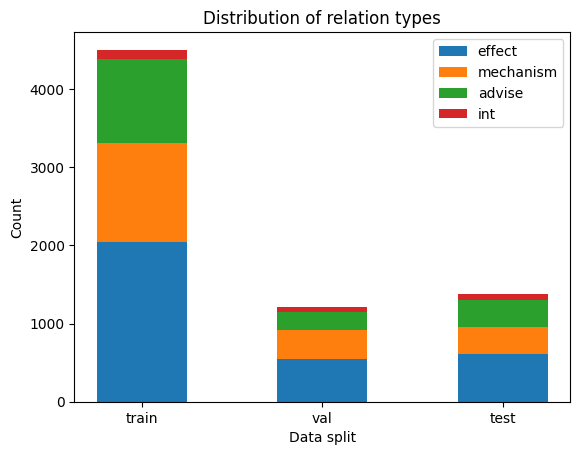

In [ ]:
counts_train = {}

for i in range(len(ner_tags_all_train)):
  counts = Counter(ner_tags_all_train[i])
  # print(counts.keys())
  for j in counts.keys():
    if j.startswith("S"):
      j = j.replace("S-", "")

    elif j.startswith("B"):
      j = j.replace("B-", "")
    elif j.startswith("I"):
      j = j.replace("I-", "")
    elif j.startswith("E"):
      j = j.replace("E-", "")

    if len(j.split("-")) >= 3:
      if j.split("-")[1] == "M":
        j = "multi"
      else:
        j = label_rel_type[j.split("-")[1]]
    else:
      continue
    # print(j)
    if j not in counts_train:
      counts_train[j] = 1
    else:
      counts_train[j] += 1
print(counts_train)

counts_val = {}
for i in range(len(ner_tags_all_val)):
  counts = Counter(ner_tags_all_val[i])
  for j in counts.keys():
    if j.startswith("S"):
      j = j.replace("S-", "")

    elif j.startswith("B"):
      j = j.replace("B-", "")
    elif j.startswith("I"):
      j = j.replace("I-", "")
    elif j.startswith("E"):
      j = j.replace("E-", "")

    if len(j.split("-")) >= 3:
      if j.split("-")[1] == "M":
        j = "multi"
      else:
        j = label_rel_type[j.split("-")[1]]
    else:
      continue
    if j not in counts_val:
      counts_val[j] = 1
    else:
      counts_val[j] += 1
print(counts_val)

counts_test = {}
for i in range(len(ner_tags_all_test)):
  counts = Counter(ner_tags_all_test[i])
  for j in counts.keys():
    if j.startswith("S"):
      j = j.replace("S-", "")

    elif j.startswith("B"):
      j = j.replace("B-", "")
    elif j.startswith("I"):
      j = j.replace("I-", "")
    elif j.startswith("E"):
      j = j.replace("E-", "")

    if len(j.split("-")) >= 3:
      if j.split("-")[1] == "M":
        j = "multi"
      else:
        j = label_rel_type[j.split("-")[1]]

    else:
      continue
    if j not in counts_test:
      counts_test[j] = 1
    else:
      counts_test[j] += 1
print(counts_test)

fig, ax = plt.subplots()
bottom = np.zeros(3)

data_split = (
    "train",
    "val",
    "test"
)

ent_type_counts = {
    "effect": np.array([counts_train["effect"],
                      counts_val["effect"],
                      counts_test["effect"]]),
    "mechanism": np.array([counts_train["mechanism"],
                      counts_val["mechanism"],
                      counts_test["mechanism"]]),
    "advise": np.array([counts_train["advise"],
                      counts_val["advise"],
                      counts_test["advise"]]),
    "int": np.array([counts_train["int"],
                      counts_val["int"],
                      counts_test["int"]])
}
width = 0.5
bottom = np.zeros(3)
for ent_type, ent_type_count in ent_type_counts.items():
    p = ax.bar(data_split, ent_type_count, width, label=ent_type, bottom=bottom)
    bottom += ent_type_count

ax.set_title("Distribution of relation types")
ax.set_ylabel("Count")
ax.set_xlabel("Data split")
ax.legend(loc="upper right")

plt.show()


In [ ]:
from datasets import load_dataset, ClassLabel, Dataset
PROJ_DIR = '/content/gdrive/MyDrive/NLP_final_project'
DATA_DIR = PROJ_DIR+"/DDICorpus/Train/DrugBank"
model_name = "PubMedBERT"

vocabfiles={'labelfile': PROJ_DIR+'/IO_label.vocab',
            'checkpoint_path':PROJ_DIR+'/'+model_name+'/',
            'lowercase':True}
# modelfile = PROJ_DIR+"/BioM-ELECTRAL-softmax-devES_GC_final.h5"


# print(len(labeled_text_all_train[0]), " sentences in train set")

# for sent in labeled_text_all_train:
#   tokens = tokenizer(sent, is_split_into_words = True)
#   break


entity_types = set()
for i in range(len(labeled_text_all_train)):
  for j in range(len(labeled_text_all_train[i])):
    unique_labels = np.unique(ner_tags_all_train[i][j])
    for l in unique_labels:
      if l not in entity_types:
        entity_types.add(l)
for i in range(len(labeled_text_all_val)):
  for j in range(len(labeled_text_all_val[i])):
    unique_labels = np.unique(ner_tags_all_val[i][j])
    for l in unique_labels:
      if l not in entity_types:
        entity_types.add(l)
for i in range(len(labeled_text_all_test)):
  for j in range(len(labeled_text_all_test[i])):
    unique_labels = np.unique(ner_tags_all_test[i][j])
    for l in unique_labels:
      if l not in entity_types:
        entity_types.add(l)
tag_names = sorted(list(entity_types))
print(len(tag_names)," unique labels")
tags = ClassLabel(names=tag_names)
label2id = {name: tags.str2int(name) for name in tag_names}
id2label = {id: tags.int2str(id) for id in range(len(tag_names))}

print(label2id)
print(id2label)




126  unique labels
{'B-brand': 0, 'B-brand-AD-1': 1, 'B-brand-AD-2': 2, 'B-brand-EF-1': 3, 'B-brand-EF-2': 4, 'B-brand-INT-2': 5, 'B-brand-ME-1': 6, 'B-brand-ME-2': 7, 'B-drug': 8, 'B-drug-AD-1': 9, 'B-drug-AD-2': 10, 'B-drug-EF-1': 11, 'B-drug-EF-2': 12, 'B-drug-INT-1': 13, 'B-drug-INT-2': 14, 'B-drug-ME-1': 15, 'B-drug-ME-2': 16, 'B-drug_n': 17, 'B-drug_n-EF-1': 18, 'B-drug_n-EF-2': 19, 'B-drug_n-INT-2': 20, 'B-drug_n-ME-1': 21, 'B-drug_n-ME-2': 22, 'B-group': 23, 'B-group-AD-1': 24, 'B-group-AD-2': 25, 'B-group-EF-1': 26, 'B-group-EF-2': 27, 'B-group-INT-1': 28, 'B-group-INT-2': 29, 'B-group-M-1': 30, 'B-group-ME-1': 31, 'B-group-ME-2': 32, 'E-brand': 33, 'E-brand-AD-1': 34, 'E-brand-AD-2': 35, 'E-brand-EF-1': 36, 'E-brand-EF-2': 37, 'E-brand-INT-2': 38, 'E-brand-ME-1': 39, 'E-brand-ME-2': 40, 'E-drug': 41, 'E-drug-AD-1': 42, 'E-drug-AD-2': 43, 'E-drug-EF-1': 44, 'E-drug-EF-2': 45, 'E-drug-INT-1': 46, 'E-drug-INT-2': 47, 'E-drug-ME-1': 48, 'E-drug-ME-2': 49, 'E-drug_n': 50, 'E-drug_

In [ ]:
MAX_LEN = 256

def tokenize_and_align_labels(sent_batch):

  tokenized_inputs = tokenizer(sent_batch["tokens"],
                               max_length=MAX_LEN,
                               truncation=True,
                               is_split_into_words=True)
  aligned_batch_labels = []
  for idx, labels in enumerate(sent_batch["ner_tags"]):
    word_ids = tokenized_inputs.word_ids(batch_index=idx)
    prev_word_id = None
    aligned_labels = []
    for word_id in word_ids:
      if word_id is None or word_id == prev_word_id:
        aligned_labels.append(-100)   # IGNore tag
      else:
        aligned_labels.append(label2id[labels[word_id]])
      prev_word_id = word_id
    aligned_batch_labels.append(aligned_labels)
  tokenized_inputs["labels"] = aligned_batch_labels
  return tokenized_inputs



MODEL_DIR = "/content/gdrive/MyDrive/checkpoints"
def align_predictions(labels_cpu, preds_cpu):
  # remove -100 labels from score computation
  batch_size, seq_len = preds_cpu.shape
  labels_list, preds_list = [], []
  for bid in range(batch_size):
    example_labels, example_preds = [], []
    for sid in range(seq_len):
      # ignore label -100
      if labels_cpu[bid, sid] != -100:
        example_labels.append(id2label[labels_cpu[bid, sid]])
        example_preds.append(id2label[preds_cpu[bid, sid]])
    labels_list.append(example_labels)
    preds_list.append(example_preds)
  return labels_list, preds_list


def compute_f1_score(labels, logits):
  # convert logits to predictions and move to CPU
  preds_cpu = torch.argmax(logits, dim=-1).cpu().numpy()
  labels_cpu = labels.cpu().numpy()
  labels_list, preds_list = align_predictions(labels_cpu, preds_cpu)
  # seqeval.metrics.f1_score takes list of list of tags
  return f1_score(labels_list, preds_list)
def do_train(model, train_dl):
  train_loss = 0

  model.train()
  for bid, batch in enumerate(train_dl):
    # print(batch)
    batch = {k: v.to(device) for k, v in batch.items()}
    outputs = model(**batch)
    loss = outputs.loss
    train_loss += loss.detach().cpu().numpy()
    loss.backward()

    optimizer.step()
    lr_scheduler.step()
    optimizer.zero_grad()

  return train_loss


def do_eval(model, eval_dl):
  model.eval()
  eval_loss, eval_score, num_batches = 0, 0, 0
  for bid, batch in enumerate(eval_dl):
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
      outputs = model(**batch)

    loss = outputs.loss

    eval_loss += loss.detach().cpu().numpy()
    eval_score += compute_f1_score(batch["labels"], outputs.logits)
    num_batches += 1

  eval_score /= num_batches

  return eval_loss, eval_score


def save_checkpoint(model, model_dir, epoch):
  model.save_pretrained(os.path.join(MODEL_DIR, "ckpt-{:d}".format(epoch)))


def save_training_history(history, model_dir, epoch):
  fhist = open(os.path.join(MODEL_DIR, "history.tsv"), "w")
  for epoch, train_loss, eval_loss, eval_score in history:
    fhist.write("{:d}\t{:.5f}\t{:.5f}\t{:.5f}\n".format(
        epoch, train_loss, eval_loss, eval_score))
  fhist.close()


def get_label_and_predicted_tags(batch):
  batch = {k: v.to(device) for k, v in batch.items()}
  with torch.no_grad():
    outputs = model(**batch)
  preds_cpu = torch.argmax(outputs.logits, dim=-1).cpu().numpy()
  labels_cpu = batch["labels"].cpu().numpy()
  labels_list, preds_list = align_predictions(labels_cpu, preds_cpu)
  return labels_list, preds_list

def plot_confusion_matrix(ytrue, ypreds, labels):
  cm = confusion_matrix(ytrue, ypreds, normalize="true")
  fig, ax = plt.subplots(figsize=(12, 12))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap="Blues", values_format="0.2f", ax=ax, colorbar=False)
  plt.title("Normalized Confusion Matrix")
  _ = plt.show()




def align_tokens_and_predicted_labels(toks_cpu, preds_cpu):
  aligned_toks, aligned_preds = [], []
  prev_tok = None
  for tok, pred in zip(toks_cpu, preds_cpu):
    if tok.startswith("##") and prev_tok is not None:
      prev_tok += tok[2:]
    else:
      if prev_tok is not None:
        aligned_toks.append(prev_tok)
        aligned_preds.append(id2label[prev_pred])
      prev_tok = tok
      prev_pred = pred
  if prev_tok is not None:
    aligned_toks.append(prev_tok)
    aligned_preds.append(id2label[prev_pred])
  return aligned_toks, aligned_preds


def predict(texts):
  aligned_tok_list, aligned_pred_list = [], []
  for text in texts:
    inputs = tokenizer(text,
                       max_length=MAX_LEN,
                       truncation=True,
                       is_split_into_words=True,
                       return_tensors="pt").to(device)
    outputs = model(**inputs)
    tokens_cpu = tokenizer.convert_ids_to_tokens(inputs.input_ids.view(-1))
    preds_cpu = torch.argmax(outputs.logits, dim=-1)[0].cpu().numpy()

    aligned_toks, aligned_preds = align_tokens_and_predicted_labels(tokens_cpu, preds_cpu)

    aligned_tok_list.append(aligned_toks)
    aligned_pred_list.append(aligned_preds)

  return aligned_tok_list, aligned_pred_list



## PubMEDBERT-base-uncased-abstract-fulltext

In [ ]:

BASE_MODEL_NAME = "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext"
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL_NAME, use_fast=True, do_lower_case=True)

train_data = []
for i in range(len(labeled_text_all_train)):
  # for j in range(len(labeled_text_all_train[i])):
    train_data.append({"tokens": labeled_text_all_train[i],
                       "ner_tags": ner_tags_all_train[i]})
val_data = []
for i in range(len(labeled_text_all_val)):
  # for j in range(len(labeled_text_all_train[i])):
    val_data.append({"tokens": labeled_text_all_val[i],
                       "ner_tags": ner_tags_all_val[i]})
test_data = []
for i in range(len(labeled_text_all_test)):
  # for j in range(len(labeled_text_all_train[i])):
    test_data.append({"tokens": labeled_text_all_test[i],
                       "ner_tags": ner_tags_all_test[i]})


train_data = Dataset.from_pandas(pd.DataFrame(data=train_data))
val_data = Dataset.from_pandas(pd.DataFrame(data=val_data))
test_data = Dataset.from_pandas(pd.DataFrame(data=test_data))

# train_data
# tokenize_and_align_labels(train_data[0:2])
encoded_train_dataset = train_data.map(tokenize_and_align_labels,
                                      batched=True,
                                      remove_columns=["ner_tags", "tokens"])

encoded_val_dataset = val_data.map(tokenize_and_align_labels,
                                      batched=True,
                                      remove_columns=["ner_tags", "tokens"])

encoded_test_dataset = test_data.map(tokenize_and_align_labels,
                                      batched=True,
                                      remove_columns=["ner_tags", "tokens"])

encoded_train_dataset, encoded_val_dataset, encoded_test_dataset

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

Map:   0%|          | 0/5491 [00:00<?, ? examples/s]

Map:   0%|          | 0/1341 [00:00<?, ? examples/s]

Map:   0%|          | 0/1299 [00:00<?, ? examples/s]

(Dataset({
     features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
     num_rows: 5491
 }),
 Dataset({
     features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
     num_rows: 1341
 }),
 Dataset({
     features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
     num_rows: 1299
 }))

13


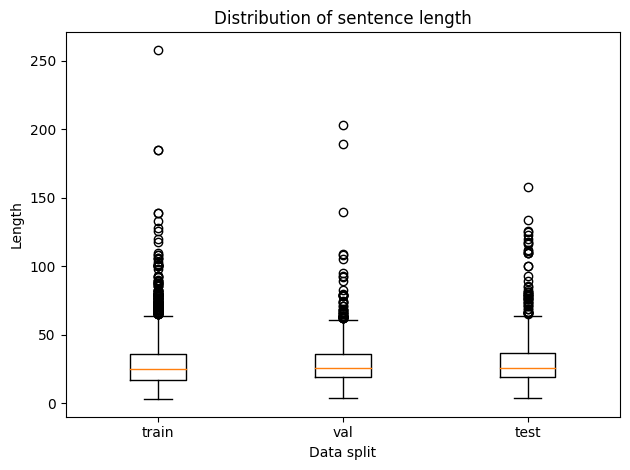

In [ ]:
sent_len_train = [len(i) for i in encoded_train_dataset["labels"]]
sent_len_val = [len(i) for i in encoded_val_dataset["labels"]]
sent_len_test = [len(i) for i in encoded_test_dataset["labels"]]
print(sent_len_val[0])

fig, ax = plt.subplots()
data = [sent_len_train, sent_len_val, sent_len_test]
labels = ['train', 'val', 'test']

ax.boxplot(data, labels=labels)

ax.set_xlabel('Data split')
ax.set_ylabel('Length')
ax.set_title('Distribution of sentence length')

plt.tight_layout()

plt.show()


In [ ]:

LEARNING_RATE = 1e-5
WEIGHT_DECAY = 1e-2
NUM_EPOCHS = 1
BATCH_SIZE = 16
# BASE_MODEL_NAME = "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext"
# BASE_MODEL_NAME = "bert-base-uncased"
collate_fn = DataCollatorForTokenClassification(tokenizer, padding="longest", return_tensors="pt")

train_dl = DataLoader(encoded_train_dataset,
                      # shuffle=True,
                      # sampler=SubsetRandomSampler(np.random.randint(0, encoded_gmb_dataset["train"].num_rows, 1000).tolist()),
                      batch_size=BATCH_SIZE,
                      collate_fn=collate_fn)
val_dl = DataLoader(encoded_val_dataset,
                      # shuffle=True,
                      # sampler=SubsetRandomSampler(np.random.randint(0, encoded_gmb_dataset["train"].num_rows, 1000).tolist()),
                      batch_size=BATCH_SIZE,
                      collate_fn=collate_fn)

test_dl = DataLoader(encoded_test_dataset,
                      # shuffle=True,
                      # sampler=SubsetRandomSampler(np.random.randint(0, encoded_gmb_dataset["train"].num_rows, 1000).tolist()),
                      batch_size=BATCH_SIZE,
                      collate_fn=collate_fn)


In [ ]:
#DO NOT RUN THIS
# from tqdm import tqdm

LEARNING_RATE = 1e-5
WEIGHT_DECAY = 1e-2
NUM_EPOCHS = 30
BATCH_SIZE = 16
BASE_MODEL_NAME = "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext"
# BASE_MODEL_NAME = "bert-base-uncased"
# BERT uncased
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AutoModelForTokenClassification.from_pretrained(BASE_MODEL_NAME,
                                  num_labels=len(tag_names),
                                  id2label=id2label,
                                  label2id=label2id)


optimizer = AdamW(model.parameters(),
                  lr=LEARNING_RATE,
                  weight_decay=WEIGHT_DECAY)

num_training_steps = NUM_EPOCHS * len(train_dl)
lr_scheduler = get_scheduler("linear",
                             optimizer=optimizer,
                             num_warmup_steps=3000,
                             num_training_steps=num_training_steps)

model = model.to(device)

history = []
for epoch in tqdm(range(NUM_EPOCHS)):
  train_loss = do_train(model, train_dl)
  eval_loss, eval_score = do_eval(model, val_dl)
  history.append((epoch + 1, train_loss, eval_loss, eval_score))
  print("EPOCH {:d}, train loss: {:.3f}, val loss: {:.3f}, f1-score: {:.5f}".format(
      epoch + 1, train_loss, eval_loss, eval_score))
  save_checkpoint(model, MODEL_DIR, epoch + 1)
  save_training_history(history, MODEL_DIR, epoch + 1)

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForToken

EPOCH 1, train loss: 1307.940, val loss: 95.236, f1-score: 0.00000


  3%|▎         | 1/30 [00:35<16:58, 35.12s/it]

EPOCH 2, train loss: 316.060, val loss: 55.131, f1-score: 0.23337


  7%|▋         | 2/30 [01:09<16:06, 34.52s/it]

EPOCH 3, train loss: 195.797, val loss: 43.073, f1-score: 0.31939


 10%|█         | 3/30 [01:44<15:35, 34.66s/it]

EPOCH 4, train loss: 162.812, val loss: 37.716, f1-score: 0.36120


 13%|█▎        | 4/30 [02:19<15:07, 34.89s/it]

EPOCH 5, train loss: 143.055, val loss: 35.059, f1-score: 0.39831


 17%|█▋        | 5/30 [02:54<14:32, 34.88s/it]

EPOCH 6, train loss: 127.797, val loss: 32.270, f1-score: 0.42430


 20%|██        | 6/30 [03:29<13:57, 34.90s/it]

EPOCH 7, train loss: 113.253, val loss: 28.684, f1-score: 0.48496


 23%|██▎       | 7/30 [04:04<13:24, 34.96s/it]

EPOCH 8, train loss: 99.159, val loss: 25.106, f1-score: 0.51727


 27%|██▋       | 8/30 [04:39<12:49, 34.96s/it]

EPOCH 9, train loss: 86.241, val loss: 22.657, f1-score: 0.56316


 30%|███       | 9/30 [05:14<12:14, 35.00s/it]

EPOCH 10, train loss: 76.018, val loss: 20.369, f1-score: 0.60282


 33%|███▎      | 10/30 [05:49<11:40, 35.02s/it]

EPOCH 11, train loss: 60.848, val loss: 19.482, f1-score: 0.63185


 37%|███▋      | 11/30 [06:24<11:05, 35.03s/it]

EPOCH 12, train loss: 52.005, val loss: 18.645, f1-score: 0.64657


 40%|████      | 12/30 [06:59<10:30, 35.02s/it]

EPOCH 13, train loss: 44.424, val loss: 17.713, f1-score: 0.66602


 43%|████▎     | 13/30 [07:34<09:54, 34.98s/it]

EPOCH 14, train loss: 38.676, val loss: 16.853, f1-score: 0.68565


 47%|████▋     | 14/30 [08:09<09:19, 34.99s/it]

EPOCH 15, train loss: 34.509, val loss: 17.023, f1-score: 0.70163


 50%|█████     | 15/30 [08:44<08:45, 35.01s/it]

EPOCH 16, train loss: 31.132, val loss: 15.738, f1-score: 0.71769


 53%|█████▎    | 16/30 [09:19<08:10, 35.04s/it]

EPOCH 17, train loss: 27.780, val loss: 16.228, f1-score: 0.71455


 57%|█████▋    | 17/30 [09:54<07:35, 35.03s/it]

EPOCH 18, train loss: 24.797, val loss: 15.652, f1-score: 0.72475


 60%|██████    | 18/30 [10:29<07:00, 35.01s/it]

EPOCH 19, train loss: 22.747, val loss: 15.383, f1-score: 0.73368


 63%|██████▎   | 19/30 [11:04<06:25, 35.02s/it]

EPOCH 20, train loss: 21.186, val loss: 14.894, f1-score: 0.73758


 67%|██████▋   | 20/30 [11:39<05:50, 35.03s/it]

EPOCH 21, train loss: 18.987, val loss: 15.113, f1-score: 0.73951


 70%|███████   | 21/30 [12:14<05:15, 35.03s/it]

EPOCH 22, train loss: 17.476, val loss: 14.979, f1-score: 0.74102


 73%|███████▎  | 22/30 [12:49<04:40, 35.04s/it]

EPOCH 23, train loss: 16.326, val loss: 15.315, f1-score: 0.74307


 77%|███████▋  | 23/30 [13:33<04:07, 35.37s/it]


KeyboardInterrupt: 

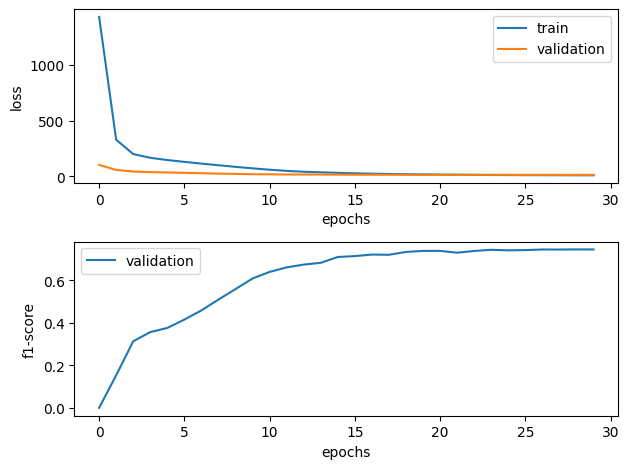

In [ ]:
import matplotlib.pyplot as plt
plt.subplot(2, 1, 1)
plt.plot([train_loss for _, train_loss, _, _ in history], label="train")
plt.plot([eval_loss for _, _, eval_loss, _ in history], label="validation")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(loc="best")

plt.subplot(2, 1, 2)
plt.plot([eval_score for _, _, _, eval_score in history], label="validation")
plt.xlabel("epochs")
plt.ylabel("f1-score")
plt.legend(loc="best")

plt.tight_layout()
_ = plt.show()

In [ ]:
# changing weight decay to 1e-1
LEARNING_RATE = 1e-5
WEIGHT_DECAY = 1e-1
NUM_EPOCHS = 30
BATCH_SIZE = 16
BASE_MODEL_NAME = "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext"
# BASE_MODEL_NAME = "bert-base-uncased"
# BERT uncased
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AutoModelForTokenClassification.from_pretrained(BASE_MODEL_NAME,
                                  num_labels=len(tag_names),
                                  id2label=id2label,
                                  label2id=label2id)


optimizer = AdamW(model.parameters(),
                  lr=LEARNING_RATE,
                  weight_decay=WEIGHT_DECAY)

num_training_steps = NUM_EPOCHS * len(train_dl)
lr_scheduler = get_scheduler("linear",
                             optimizer=optimizer,
                             num_warmup_steps=3000,
                             num_training_steps=num_training_steps)

model = model.to(device)

history = []
for epoch in tqdm(range(NUM_EPOCHS)):
  train_loss = do_train(model, train_dl)
  eval_loss, eval_score = do_eval(model, val_dl)
  history.append((epoch + 1, train_loss, eval_loss, eval_score))
  print("EPOCH {:d}, train loss: {:.3f}, val loss: {:.3f}, f1-score: {:.5f}".format(
      epoch + 1, train_loss, eval_loss, eval_score))
  save_checkpoint(model, MODEL_DIR, epoch + 1)
  save_training_history(history, MODEL_DIR, epoch + 1)
print("EPOCH {:d}, train loss: {:.3f}, val loss: {:.3f}, f1-score: {:.5f}".format(
      epoch + 1, train_loss, eval_loss, eval_score))

Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForToken

EPOCH 1, train loss: 1381.825, val loss: 111.145, f1-score: 0.00000


  3%|▎         | 1/30 [00:35<17:04, 35.33s/it]

EPOCH 2, train loss: 335.553, val loss: 58.106, f1-score: 0.00562


  7%|▋         | 2/30 [01:09<16:17, 34.89s/it]

EPOCH 3, train loss: 207.852, val loss: 45.242, f1-score: 0.31069


 10%|█         | 3/30 [01:44<15:39, 34.78s/it]

EPOCH 4, train loss: 172.596, val loss: 40.157, f1-score: 0.33882


 13%|█▎        | 4/30 [02:19<15:06, 34.85s/it]

EPOCH 5, train loss: 151.779, val loss: 36.314, f1-score: 0.37867


 17%|█▋        | 5/30 [02:54<14:32, 34.89s/it]

EPOCH 6, train loss: 134.100, val loss: 33.433, f1-score: 0.40676


 20%|██        | 6/30 [03:29<13:57, 34.91s/it]

EPOCH 7, train loss: 118.025, val loss: 29.418, f1-score: 0.45568


 23%|██▎       | 7/30 [04:04<13:24, 34.96s/it]

EPOCH 8, train loss: 102.668, val loss: 25.591, f1-score: 0.50668


 27%|██▋       | 8/30 [04:39<12:49, 34.99s/it]

EPOCH 9, train loss: 88.313, val loss: 22.626, f1-score: 0.55490


 30%|███       | 9/30 [05:14<12:15, 35.00s/it]

EPOCH 10, train loss: 73.745, val loss: 20.250, f1-score: 0.59808


 33%|███▎      | 10/30 [05:49<11:40, 35.02s/it]

EPOCH 11, train loss: 61.472, val loss: 18.704, f1-score: 0.64719


 37%|███▋      | 11/30 [06:24<11:05, 35.03s/it]

EPOCH 12, train loss: 51.446, val loss: 17.924, f1-score: 0.65838


 40%|████      | 12/30 [06:59<10:30, 35.04s/it]

EPOCH 13, train loss: 44.080, val loss: 18.235, f1-score: 0.66832


 43%|████▎     | 13/30 [07:34<09:55, 35.03s/it]

EPOCH 14, train loss: 38.112, val loss: 16.698, f1-score: 0.68677


 47%|████▋     | 14/30 [08:09<09:20, 35.04s/it]

EPOCH 15, train loss: 33.938, val loss: 16.710, f1-score: 0.69434


 50%|█████     | 15/30 [08:44<08:45, 35.03s/it]

EPOCH 16, train loss: 29.896, val loss: 15.597, f1-score: 0.71232


 53%|█████▎    | 16/30 [09:19<08:10, 35.03s/it]

EPOCH 17, train loss: 26.449, val loss: 15.846, f1-score: 0.70966


 57%|█████▋    | 17/30 [09:54<07:35, 35.05s/it]

EPOCH 18, train loss: 23.901, val loss: 15.309, f1-score: 0.71892


 60%|██████    | 18/30 [10:30<07:00, 35.05s/it]

EPOCH 19, train loss: 21.604, val loss: 15.715, f1-score: 0.71878


 63%|██████▎   | 19/30 [11:05<06:25, 35.05s/it]

EPOCH 20, train loss: 19.537, val loss: 15.270, f1-score: 0.72592


 67%|██████▋   | 20/30 [11:40<05:50, 35.04s/it]

EPOCH 21, train loss: 18.126, val loss: 14.879, f1-score: 0.73112


 70%|███████   | 21/30 [12:15<05:15, 35.04s/it]

EPOCH 22, train loss: 16.685, val loss: 15.132, f1-score: 0.72627


 73%|███████▎  | 22/30 [12:50<04:40, 35.05s/it]

EPOCH 23, train loss: 15.401, val loss: 15.271, f1-score: 0.73077


 77%|███████▋  | 23/30 [13:25<04:05, 35.04s/it]

EPOCH 24, train loss: 14.560, val loss: 14.844, f1-score: 0.74167


 80%|████████  | 24/30 [14:00<03:30, 35.04s/it]

EPOCH 25, train loss: 13.425, val loss: 14.934, f1-score: 0.74340


 83%|████████▎ | 25/30 [14:35<02:55, 35.05s/it]

EPOCH 26, train loss: 12.705, val loss: 14.804, f1-score: 0.74242


 87%|████████▋ | 26/30 [15:10<02:20, 35.04s/it]

EPOCH 27, train loss: 12.128, val loss: 15.022, f1-score: 0.73606


 90%|█████████ | 27/30 [15:45<01:45, 35.05s/it]

EPOCH 28, train loss: 11.801, val loss: 14.846, f1-score: 0.74326


 93%|█████████▎| 28/30 [16:20<01:10, 35.06s/it]

EPOCH 29, train loss: 11.496, val loss: 14.872, f1-score: 0.73959


 97%|█████████▋| 29/30 [16:55<00:35, 35.05s/it]

EPOCH 30, train loss: 11.259, val loss: 14.868, f1-score: 0.74221


100%|██████████| 30/30 [17:30<00:00, 35.02s/it]

EPOCH 30, train loss: 11.259, val loss: 14.868, f1-score: 0.74221


In [ ]:

id2label_copy = id2label.copy()
id2label[-100] = "IGN"
test_labels_list, test_preds_list = [], []
for batch in test_dl:
  labels_list, preds_list = get_label_and_predicted_tags(batch)
  for labels, preds in zip(labels_list, preds_list):
    test_labels_list.append(labels)
    test_preds_list.append(preds)

test_report = classification_report(test_labels_list, test_preds_list)
print(test_report)
# print(os.path.join(MODEL_DIR, "test_report_pubmedbert.txt"))
# with open(os.path.join(MODEL_DIR, "test_report_pubmedbert.txt"), "w") as f:
#   f.write(test_report)
# f.close()
# # flat_test_labels, flat_test_preds = [], []
# for test_labels, test_preds in zip(test_labels_list, test_preds_list):
#   flat_test_labels.extend(test_labels)
#   flat_test_preds.extend(test_preds)
# plot_confusion_matrix(flat_test_labels, flat_test_preds, tag_names)

/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       brand       0.79      0.73      0.76       188
  brand-AD-1       0.77      0.69      0.73        39
  brand-AD-2       0.75      0.80      0.77        30
  brand-EF-1       0.59      0.47      0.52        34
  brand-EF-2       0.67      0.57      0.62        21
 brand-INT-1       0.00      0.00      0.00         1
 brand-INT-2       0.00      0.00      0.00         2
   brand-M-1       0.00      0.00      0.00         1
  brand-ME-1       0.76      0.57      0.65        28
  brand-ME-2       0.61      0.44      0.51        25
        drug       0.83      0.86      0.85       989
   drug-AD-1       0.71      0.82      0.76        84
   drug-AD-2       0.74      0.87      0.80        95
   drug-EF-1       0.74      0.86      0.79       130
   drug-EF-2       0.68      0.77      0.72       149
  drug-INT-1       1.00      0.12      0.22        16
  drug-INT-2       0.59      0.47      0.53        40
    drug-M-1       0.00    

In [ ]:
# DO NOT RUN THIS
# predicted_tokens, predicted_tags = predict(labeled_text_all_test)


# test_pred = pd.DataFrame([predicted_tokens, predicted_tags], index=["tokens", "predicted_tags"])


# print(test_pred.shape)
# print(test_pred.head())
# test_pred.to_csv(os.path.join(MODEL_DIR, "test_pred_pubmedbert_e30.csv"))

# pd.DataFrame(predicted_tokens).to_csv(os.path.join(MODEL_DIR, "test_pred_tokens_pubmedbert_e30.csv"))
# pd.DataFrame(predicted_tags).to_csv(os.path.join(MODEL_DIR, "test_pred_tags_pubmedbert_e30.csv"))

### RE-rules

1.

In [ ]:
# MODEL_DIR=PROJ_DIR
CHECKPOINT_PATH = MODEL_DIR+"/ckpt-24/pytorch_model.bin"

# CHECKPOINT_PATH = MODEL_DIR+"/ckpt-30-pubmedbert/pytorch_model.bin"
BASE_MODEL_NAME = "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoint = torch.load(CHECKPOINT_PATH, map_location=device)
model = AutoModelForTokenClassification.from_pretrained(BASE_MODEL_NAME,
                                  num_labels=len(tag_names),
                                  id2label=id2label,
                                  label2id=label2id)
model.load_state_dict(checkpoint)

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForToken

<All keys matched successfully>

In [ ]:
# predicted_tokens, predicted_tags = predict(labeled_text_all_test)
# predicted_tags

In [ ]:
# run this after loading model
id2label_copy = id2label.copy()
id2label[-100] = "IGN"
test_labels_list, test_preds_list = [], []
for batch in test_dl:
  labels_list, preds_list = get_label_and_predicted_tags(batch)
  for labels, preds in zip(labels_list, preds_list):
    test_labels_list.append(labels)
    test_preds_list.append(preds)

test_report = classification_report(test_labels_list, test_preds_list)
print(test_report)
# print(os.path.join(MODEL_DIR, "test_report_pubmedbert.txt"))
# with open(os.path.join(MODEL_DIR, "test_report_pubmedbert.txt"), "w") as f:
#   f.write(test_report)
# f.close()
# # flat_test_labels, flat_test_preds = [], []
# for test_labels, test_preds in zip(test_labels_list, test_preds_list):
#   flat_test_labels.extend(test_labels)
#   flat_test_preds.extend(test_preds)
# plot_confusion_matrix(flat_test_labels, flat_test_preds, tag_names)

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


              precision    recall  f1-score   support

       brand       0.76      0.73      0.75       188
  brand-AD-1       0.78      0.64      0.70        39
  brand-AD-2       0.79      0.73      0.76        30
  brand-EF-1       0.63      0.50      0.56        34
  brand-EF-2       0.57      0.38      0.46        21
 brand-INT-1       0.00      0.00      0.00         1
 brand-INT-2       0.00      0.00      0.00         2
   brand-M-1       0.00      0.00      0.00         1
  brand-ME-1       0.71      0.54      0.61        28
  brand-ME-2       0.62      0.32      0.42        25
        drug       0.82      0.89      0.85       989
   drug-AD-1       0.72      0.74      0.73        84
   drug-AD-2       0.85      0.84      0.85        95
   drug-EF-1       0.70      0.80      0.75       130
   drug-EF-2       0.66      0.78      0.71       149
  drug-INT-1       0.00      0.00      0.00        16
  drug-INT-2       0.76      0.40      0.52        40
    drug-M-1       0.00    

/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
doc_idx = 0
confusion = {"tp":0, "fp":0, "fn":0, "tn":0}
count_tp = 0
mismatch_idx = []
pred_rels_all_test = []
for i in range(len(test_labels_list)):

  if i == sum(doc_lengths_test[:doc_idx+1]):
    # print(sum(doc_lengths_test[:doc_idx+1]))
    print("====== doc", doc_idx, ", drug ", drugs_all_test[doc_idx])
    doc_idx += 1

  # print(drugs_all_test[doc_idx])
  cur_drug_arg1 = []
  cur_drug_arg2 = []
  cur_drug_rel_type = []
  cur_drug = drugs_all_test[doc_idx]

  # completely correct labeling, meaning all relations are correct
  if test_labels_list[i] == test_preds_list[i]:
    count_tp += len(cur_drug_rel_type)
  else:
    mismatch_idx.append([i, drugs_all_test[doc_idx]])

  arg1_idx = []
  arg2_idx = []
  # arg1_idx_m = []
  # arg2_idx_m = []
  j = 0
  while j < len(test_preds_list[i]):
  # for j in range(len(test_labels_list[i])):
    if test_preds_list[i][j] == "O":
      j += 1
    else:
      cur_split = test_preds_list[i][j].split("-")
      if len(cur_split) > 2:
        if cur_split[3] == "1" and cur_split[0] == "S":
          arg1_idx.append((j, j+1))
          j += 1
        elif cur_split[3] == "1" and cur_split[0] == "B":
          start_idx = j
          j += 1
          end_idx = j
          while test_preds_list[i][j] != "O":
            j += 1
            end_idx = j

            if j >= len(test_preds_list[i]):
              break
          if end_idx == len(test_preds_list[i]):
            end_idx = start_idx + 1
          arg1_idx.append((start_idx, end_idx))
        # elif cur_split[3] == "1" and cur_split[0] == "I"

        elif cur_split[3] == "2" and cur_split[0] == "S":
          arg2_idx.append((j, j+1))
          j += 1
        elif cur_split[3] == "2" and cur_split[0] == "B":
          start_idx = j
          j += 1
          end_idx = j
          while test_preds_list[i][j] != "O":
            j += 1
            end_idx = j

            if j >= len(test_preds_list[i]):
              break
          if end_idx == len(test_preds_list[i]):
            end_idx = start_idx + 1
          arg2_idx.append((start_idx, end_idx))
        else:
          # print("other", cur_split)
          j+=1
      else:
        # print("not 5 len label", cur_split)

        j+=1

  print(arg1_idx, arg2_idx)

  print(test_preds_list[i])
  print(test_labels_list[i])

  # print(arg1_idx, arg2_idx)
  sent_rels = []
  for j in arg1_idx:
    cur_tokens = test_preds_list[i][j[0]:j[1]]
    cur_split = test_preds_list[i][j[0]].split("-")

    if len(cur_tokens) > 1:
      print("multi token entity:", cur_tokens, labeled_text_all_test[i][j[0]:j[1]])
      arg1_span_text = ' '.join(labeled_text_all_test[i][j[0]:j[1]])
    else:
      arg1_span_text = labeled_text_all_test[i][j[0]]
    print("arg1 true label:", test_labels_list[i][j[0]:j[1]], "| pred label:",test_preds_list[i][j[0]:j[1]])
    for k in range(j[1], len(test_labels_list[i])):
      if k == 37:
        print(test_preds_list[i][k])
      if test_preds_list[i][k] != "O":
        arg2_split = test_preds_list[i][k].split("-")
        # print("gs arg2", )
        if len(arg2_split) > 2:
          # strict rel
          if arg2_split[3] == "2":
            print(k,[idx for idx in arg2_idx if idx[0] == k], arg2_split)
            arg2_span_idx = [idx for idx in arg2_idx if idx[0] == k]
            if len(arg2_span_idx) > 1:
              arg2_span_idx = arg2_span_idx[0]
            else:
              arg2_span_idx = [k, k+1]
              temp_end_idx = k+1
              if temp_end_idx < len(test_preds_list[i]):

                while test_preds_list[i][temp_end_idx] != "O":
                  temp_end_idx += 1
                  if temp_end_idx >= len(test_preds_list[i]):
                    break
              if temp_end_idx >= len(test_preds_list[i]):
                temp_end_idx = k+1
              arg2_span_idx = [k, temp_end_idx]
            #
            print("arg2_span_idx:", arg2_span_idx, len(test_preds_list[i]))
            arg2_span = test_preds_list[i][arg2_span_idx[0]:arg2_span_idx[1]]
            if len(arg2_span) > 1:
              arg2_span_text = ' '.join(labeled_text_all_test[i][arg2_span_idx[0]:arg2_span_idx[1]])
            else:
              arg2_span_text = labeled_text_all_test[i][arg2_span_idx[0]]
            # doc_id, true token, true token for pred relation, pred_arg1_rel_type, pred_arg2_rel_type
            if arg2_split[2] == cur_split[2]:
              rel_to_append = [cur_drug,
                                arg1_span_text,
                                arg2_span_text,
                                label_rel_type[cur_split[2]],
                                label_rel_type[arg2_split[2]]]
              if rel_to_append not in sent_rels:
                sent_rels.append(rel_to_append)
              break
            elif arg2_split[2] != cur_split[2] and cur_split[2] == "M":
              rel_to_append = [cur_drug,
                                arg1_span_text,
                                arg2_span_text,
                                label_rel_type[cur_split[2]],
                                label_rel_type[arg2_split[2]]]
              if rel_to_append not in sent_rels:
                sent_rels.append(rel_to_append)
            break
            print("arg2 true label:", test_labels_list[i][k], "| pred label:",test_preds_list[i][k])

            print("arg1 true label:", test_labels_list[i][k], "| pred label:",test_preds_list[i][k])

  pred_rels_all_test.append(sent_rels)

print(count_tp, len(mismatch_idx))
print(pred_rels_all_test)

Streaming output truncated to the last 5000 lines.
[(0, 1)] [(2, 3)]
['S-drug-EF-1', 'O', 'S-drug-EF-2', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['S-drug-EF-1', 'O', 'S-brand-EF-2', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
arg1 true label: ['S-drug-EF-1'] | pred label: ['S-drug-EF-1']
2 [(2, 3)] ['S', 'drug', 'EF', '2']
arg2_span_idx: [2, 3] 14
[(6, 7)] [(9, 10)]
['O', 'O', 'O', 'O', 'O', 'O', 'S-drug-EF-1', 'O', 'O', 'S-drug-EF-2', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'S-drug', 'O', 'O', 'O', 'O', 'S-drug', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['O', 'O', 'O', 'O', 'O', 'O', 'S-drug-EF-1', 'O', 'O', 'S-brand-EF-2', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'S-drug', 'O', 'O', 'O', 'O', 'S-brand', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
arg1 true label: ['S-drug-EF-1'] | pred label: ['S-drug-EF-1']
9 [(9, 10)] ['S', 'drug', 'E

In [ ]:
# fn_drugs_all = []
# fn_labels_all = []
# # Get entities with non-O labels that are not in a relation
# for i in range(len(test_labels_list)):
#   fn_drugs = []
#   fn_labels = []
#   print("cur sentence:", test_labels_list[i])
#   print("cur rels:", pred_rels_all_test[i])
#   # for j in range(len(test_labels_list[i])):
#   j = 0
#   while j < len(test_labels_list[i]):
#     if test_labels_list[i][j] != "O":
#       cur_split = test_labels_list[i][j].split("-")
#       print("cur split:", cur_split)
#       if cur_split[0] == "S" and labeled_text_all_test[i][j] not in pred_rels_all_test[i]:
#         fn_drugs.append(labeled_text_all_test[i][j].lower())
#         # fn_labels is [[word index], [word label]]
#         fn_labels.append([(j,j+1), [test_labels_list[i][j]]])
#         j+=1
#       elif cur_split[0] == "B":
#         # fn_drugs.append(labeled_text_all_test[i][j])
#         # fn_labels.append(test_labels_list[i][j])
#         start_idx = j
#         j+=1
#         end_idx = j
#         if end_idx < len(test_labels_list[i]):
#           next_split = test_labels_list[i][j].split("-")
#           while test_labels_list[i][j] != "O":
#             # fn_drugs.append(labeled_text_all_test[i][j])
#             # fn_labels.append(test_labels_list[i][j])
#             j+=1
#             end_idx = j
#             if j >= len(test_labels_list[i]):
#               break
#           if end_idx == len(test_preds_list[i]):
#             end_idx = start_idx + 1
#           ent_str = []
#           ent_str = ' '.join(labeled_text_all_test[i][start_idx:end_idx]).lower()
#           if ent_str not in fn_drugs:
#             fn_drugs.append(ent_str)

#           fn_labels.append([(start_idx, end_idx), test_labels_list[i][start_idx:end_idx]])
#           print("start, end", ent_str)

#         else:
#           j+=1

#     else:
#       j+=1

#       # if labeled_text_all_test[i][j] not in pred_rels_all_test[i]:
#       #   fn_drugs.append(labeled_text_all_test[i][j])
#       #   fn_labels.append(test_labels_list[i][j])

#   print("cur fn_drugs:", fn_drugs)
#   print("cur fn_labels:", fn_labels)
#   fn_drugs_all.append(fn_drugs)
#   #fn_labels_all.append(fn_labels)
#       # fn_drugs.append(labeled_text_all_test[i][j])
#       # fn_labels.append(test_labels_list[i][j])


Streaming output truncated to the last 5000 lines.
cur fn_labels: [[(0, 1), ['S-group']], [(2, 3), ['S-drug']]]
cur sentence: ['S-drug', 'O', 'O', 'S-drug', 'O', 'O', 'O']
cur rels: []
cur split: ['S', 'drug']
cur split: ['S', 'drug']
cur fn_drugs: ['lithium', 'lithium']
cur fn_labels: [[(0, 1), ['S-drug']], [(3, 4), ['S-drug']]]
cur sentence: ['B-group', 'E-group', 'O', 'S-group-EF-1', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-group-EF-2', 'E-group-EF-2', 'O', 'O', 'S-drug-EF-2', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
cur rels: [['Metolazone', 'Diuretic', 'curariform drugs', 'effect', 'effect']]
cur split: ['B', 'group']
start, end curariform drugs
cur split: ['S', 'group', 'EF', '1']
cur split: ['B', 'group', 'EF', '2']
start, end curariform drugs
cur split: ['S', 'drug', 'EF', '2']
cur fn_drugs: ['curariform drugs', 'diuretic', 'tubocurarine']
cur fn_labels: [[(0, 2), ['B-group', 'E-group']], [(3, 4), ['S-group-EF-1']], [(12, 14), ['B-group-EF-2', 'E-

In [ ]:
doc_idx = 0
in_doc_idx = 0

# rel type has to match, both entity strings need to exactly match
strict_confusion = {"tp":0, "fp":0, "fn":0, "tn":0}

# rel type has to match, both entity strings only need to partially match
partial_confusion = {"tp":0, "fp":0, "fn":0, "tn":0}

# rel type does not have to match, both entity strings need to exactly match
rel_confusion = {"tp":0, "fp":0, "fn":0, "tn":0}

# rel type does not have to match, both entity strings only need to partially match
rel_partial_confusion = {"tp":0, "fp":0, "fn":0, "tn":0}

# confusion by type
confusion_by_type = {"effect": {"tp":0, "fp":0, "fn":0, "tn":0},
                     "mechanism": {"tp":0, "fp":0, "fn":0, "tn":0},
                     "advise": {"tp":0, "fp":0, "fn":0, "tn":0},
                     "int": {"tp":0, "fp":0, "fn":0, "tn":0}}
count_kg = 0

for i in range(len(pred_rels_all_test)):

  if i == sum(doc_lengths_test[:doc_idx+1]):
    # print(sum(doc_lengths_test[:doc_idx+1]))
    print("====== doc", doc_idx, ", drug ", drugs_all_test[doc_idx])
    in_doc_idx = 0
    doc_idx += 1

  cur_drug = drugs_all_test[doc_idx]
  ent2id_all_drug = ent2id_all_test[cur_drug]
  id2ent_all_drug = {}
  for j in range(len(ent2id_all_drug)):
    for key,val in ent2id_all_drug[j].items():
      id2ent_all_drug[val] = key

  if len(pred_rels_all_test[i]) > 1:
    print(i, pred_rels_all_test[i])
    print("orig tokens:", labeled_text_all_test[i])
    print("orig ner tags:", ner_tags_all_test[i])
    print("pred ner tags:", test_preds_list[i])


    # print(drugs_all_test[doc_idx])
    cur_drug_arg1 = []
    cur_drug_arg2 = []
    cur_drug_rels = []
    cur_drug = drugs_all_test[doc_idx]


    sent_annot = sentence_annot_all_test[cur_drug][in_doc_idx]
    print("sent_annot len", len(sent_annot))

    if len(sent_annot) == 5:
      for j in range(len(sent_annot[4])):
        print(sent_annot[4][j])
        true_triplet = [sent_annot[4][j][0][0].lower(), sent_annot[4][j][1][0].lower(), sent_annot[4][j][2].lower()]
        if true_triplet not in cur_drug_rels:
          cur_drug_rels.append(true_triplet)
    else:
      strict_confusion["fp"] += len(pred_rels_all_test[i])

    print(len(cur_drug_rels), "number of true relations in this drug doc")
    # print(len(pred_rels_all_test[i]), "number of pred relations in this drug doc", len(np.unique(np.array())))

    print("true relations:", cur_drug_rels)

      # pred_triplet_dedup = [np.unique(np.array(pred_rels_all_test[i]))]
    print("pred relations:", pred_rels_all_test[i])
    # print(pred_triplet_dedup)


    cur_drug_rels_set = [set(r) for r in cur_drug_rels]
    pred_triplet = []
    # if the line above says 0 then the preds are all false positives
    cur_kg_rels = [r for r in fn_drugs_all[i] if r != "O"]

    print("KG recovery:",  cur_kg_rels)
    for j in range(len(pred_rels_all_test[i])):
      arg1_pred = pred_rels_all_test[i][j][1].lower()
      arg2_pred = pred_rels_all_test[i][j][2].lower()
      arg1_rel_type_pred = pred_rels_all_test[i][j][3].lower()
      arg2_rel_type_pred = pred_rels_all_test[i][j][4].lower()

      additional_rel = []
      rel_exist = False
      for k in range(len(cur_kg_rels)):
        kg_rel = cur_kg_rels[k][:2]
        if set(kg_rel) == set([arg1_pred, arg2_pred]):
          print("rel exist", [arg1_pred, arg2_pred], kg_rel)
          rel_exist = True
          break
        else:
          print("rel does not exist", kg_rel)
          print("====")

          arg1_idx = [l for l in range(len(labeled_text_all_test[i])) if labeled_text_all_test[i][l].lower() in kg_rel[0]]
          arg2_idx = [l for l in range(len(labeled_text_all_test[i])) if labeled_text_all_test[i][l].lower() in kg_rel[1]]

          if len(arg1_idx) >= 1 and len(arg2_idx) >= 1:
            print(labeled_text_all_test[i][arg1_idx[0]], labeled_text_all_test[i][arg2_idx[0]])
            print(test_preds_list[i][arg1_idx[0]], test_preds_list[i][arg2_idx[0]])
            kg_rel_type_arg1 = test_preds_list[i][arg1_idx[0]].split("-")
            kg_rel_type_arg2 = test_preds_list[i][arg2_idx[0]].split("-")

            print("new rel from kg", kg_rel_type_arg1, kg_rel_type_arg2)
            if len(kg_rel_type_arg1) > 2 and len(kg_rel_type_arg2) > 2:
              if kg_rel_type_arg1[2] == kg_rel_type_arg2[2]:
                print(labeled_text_all_test[i][arg1_idx[0]], labeled_text_all_test[i][arg2_idx[0]], label_rel_type[kg_rel_type_arg1[2]])
                additional_rel.append(set([kg_rel[0],
                                       kg_rel[1],
                                       label_rel_type[kg_rel_type_arg1[2]]]))
              else:
                print("FP")
            elif len(kg_rel_type_arg1) > 2 and len(kg_rel_type_arg2) == 2:
                additional_rel.append(set([kg_rel[0],
                                       kg_rel[1],
                                       label_rel_type[kg_rel_type_arg1[2]]]))

            elif len(kg_rel_type_arg1) == 2 and len(kg_rel_type_arg2) > 2:
                additional_rel.append(set([kg_rel[0],
                                       kg_rel[1],
                                       label_rel_type[kg_rel_type_arg2[2]]]))
            # elif len(lg_rel_type_arg1) == 2 and len(kg_rel_type_arg2) == 2:


          else:

            print(arg1_idx, arg2_idx, "idx more than len 1")
      print("cur additional rel from KG", additional_rel)
      # if rel_exist == False:


      cur_triplet = set([arg1_pred, arg2_pred, arg1_rel_type_pred])
      if cur_triplet not in cur_drug_rels_set:
        print("fp: ", cur_triplet)
        strict_confusion["fp"] += 1
        confusion_by_type[arg1_rel_type_pred]["fp"] += 1
      else:
        strict_confusion["tp"] += 1
        confusion_by_type[arg1_rel_type_pred]["tp"] += 1

      pred_triplet.append(cur_triplet)

    for k in range(len(cur_drug_rels_set)):
      cur_triplet = set(cur_drug_rels_set[k])

      cur_rel_type = [t for t in cur_triplet if t in confusion_by_type.keys()]
      # print("cur_triplet", cur_rel_type)
      if cur_drug_rels[k] not in pred_triplet:
        print("fn: ", cur_drug_rels[k])
        strict_confusion["fn"] += 1
        confusion_by_type[cur_rel_type[0]]["fn"] += 1



  in_doc_idx += 1
print(strict_confusion)
precision_test = strict_confusion["tp"]/(strict_confusion["tp"]+strict_confusion["fp"])
recall_test = strict_confusion["tp"]/(strict_confusion["tp"]+strict_confusion["fn"])
f1_test = 2*precision_test*recall_test/(precision_test+recall_test)
print("precision:", precision_test)
print("recall:", recall_test)
print("f1:", f1_test)

# print("------------- by type match result below --------------")
print(confusion_by_type)
for rel_type in confusion_by_type.keys():
  precision_test = confusion_by_type[rel_type]["tp"]/(confusion_by_type[rel_type]["tp"]+confusion_by_type[rel_type]["fp"]) if (confusion_by_type[rel_type]["tp"]+confusion_by_type[rel_type]["fp"]) else 0
  recall_test = confusion_by_type[rel_type]["tp"]/(confusion_by_type[rel_type]["tp"]+confusion_by_type[rel_type]["fn"]) if (confusion_by_type[rel_type]["tp"]+confusion_by_type[rel_type]["fn"]) else 0
  f1_test = 2*precision_test*recall_test/(precision_test+recall_test) if (precision_test+recall_test) else 0
  print(rel_type," precision:", precision_test)
  print(rel_type, " recall:", recall_test)
  print(rel_type, " f1:", f1_test)

print(count_kg)

====== doc 0 , drug  21705423
====== doc 1 , drug  21706316
====== doc 2 , drug  21715267
====== doc 3 , drug  21716267
====== doc 4 , drug  21720561
====== doc 5 , drug  21729965
====== doc 6 , drug  21731754
====== doc 7 , drug  21741958
====== doc 8 , drug  21750604
====== doc 9 , drug  21751692
106 [['21751753', 'Paroxetine', 'endoxifen', 'mechanism', 'mechanism'], ['21751753', 'fluoxetine', 'endoxifen', 'mechanism', 'mechanism']]
orig tokens: ['Paroxetine', 'and', 'fluoxetine', 'reduce', 'the', 'plasma', 'concentration', 'of', 'endoxifen', 'by', 'about', '50%.']
orig ner tags: ['S-drug-ME-1', 'O', 'S-drug-ME-1', 'O', 'O', 'O', 'O', 'O', 'S-drug_n-ME-2', 'O', 'O', 'O']
pred ner tags: ['S-drug-ME-1', 'O', 'S-drug-ME-1', 'O', 'O', 'O', 'O', 'O', 'S-drug-ME-2', 'O', 'O', 'O']
sent_annot len 5
[('Paroxetine', '0-9'), ('endoxifen', '61-69'), 'mechanism']
[('fluoxetine', '15-24'), ('endoxifen', '61-69'), 'mechanism']
2 number of true relations in this drug doc
true relations: [['paroxeti

### predicted entity list

In [ ]:
# For Haneen, it's the fn_drugs_all list from the previous cell
# fn_drugs_all is a list of lists, each sublist is the the entities within a sentence, all lower case.
# if an entity occurs more than once in the sentence, they only appear once in this list
import pickle
Pubmed_pickle_file_name = 'FN_PubMEDBERT.pkl'
project_DIR='/content/gdrive/MyDrive/NLP_final_project/'
filepath = project_DIR  + Pubmed_pickle_file_name

print(len(fn_drugs_all))

# Pickling the list of lists
with open(filepath, 'wb') as file:
    pickle.dump(fn_drugs_all, file)

print(f"fn_drugs_all has been pickled and saved to {filepath}")





1299
fn_drugs_all has been pickled and saved to /content/gdrive/MyDrive/NLP_final_project/FN_PubMEDBERT.pkl


In [ ]:
import pickle
Pubmed_pickle_file_name = 'Modified_FN_PubMEDBERT.pkl'
project_DIR='/content/gdrive/MyDrive/NLP_final_project/'
filepath = project_DIR  + Pubmed_pickle_file_name
with open(filepath, 'rb') as handle:
    fn_drugs_all = pickle.load(handle)

print(len(fn_drugs_all), fn_drugs_all[1290])

1299 [['vigabatrin', 'phenytoin', 'CC'], ['vigabatrin', 'phenytoin', 'CC'], 'O']


In [ ]:
doc_idx = 0
in_doc_idx = 0

# rel type has to match, both entity strings need to exactly match
strict_confusion = {"tp":0, "fp":0, "fn":0, "tn":0}

# rel type has to match, both entity strings only need to partially match
partial_confusion = {"tp":0, "fp":0, "fn":0, "tn":0}

# rel type does not have to match, both entity strings need to exactly match
rel_confusion = {"tp":0, "fp":0, "fn":0, "tn":0}

# rel type does not have to match, both entity strings only need to partially match
rel_partial_confusion = {"tp":0, "fp":0, "fn":0, "tn":0}

# confusion by type
confusion_by_type = {"effect": {"tp":0, "fp":0, "fn":0, "tn":0},
                     "mechanism": {"tp":0, "fp":0, "fn":0, "tn":0},
                     "advise": {"tp":0, "fp":0, "fn":0, "tn":0},
                     "int": {"tp":0, "fp":0, "fn":0, "tn":0}}
count_kg = 0

for i in range(len(pred_rels_all_test)):

  if i == sum(doc_lengths_test[:doc_idx+1]):
    # print(sum(doc_lengths_test[:doc_idx+1]))
    print("====== doc", doc_idx, ", drug ", drugs_all_test[doc_idx])
    in_doc_idx = 0
    doc_idx += 1

  cur_drug = drugs_all_test[doc_idx]
  ent2id_all_drug = ent2id_all_test[cur_drug]
  id2ent_all_drug = {}
  for j in range(len(ent2id_all_drug)):
    for key,val in ent2id_all_drug[j].items():
      id2ent_all_drug[val] = key

  if len(pred_rels_all_test[i]) > 1:
    print(i, pred_rels_all_test[i])
    print("orig tokens:", labeled_text_all_test[i])
    print("orig ner tags:", ner_tags_all_test[i])
    print("pred ner tags:", test_preds_list[i])


    # print(drugs_all_test[doc_idx])
    cur_drug_arg1 = []
    cur_drug_arg2 = []
    cur_drug_rels = []
    cur_drug = drugs_all_test[doc_idx]


    sent_annot = sentence_annot_all_test[cur_drug][in_doc_idx]
    print("sent_annot len", len(sent_annot))

    if len(sent_annot) == 5:
      for j in range(len(sent_annot[4])):
        print(sent_annot[4][j])
        true_triplet = [sent_annot[4][j][0][0].lower(), sent_annot[4][j][1][0].lower(), sent_annot[4][j][2].lower()]
        if true_triplet not in cur_drug_rels:
          cur_drug_rels.append(true_triplet)
    else:
      strict_confusion["fp"] += len(pred_rels_all_test[i])

    print(len(cur_drug_rels), "number of true relations in this drug doc")
    # print(len(pred_rels_all_test[i]), "number of pred relations in this drug doc", len(np.unique(np.array())))

    print("true relations:", cur_drug_rels)

      # pred_triplet_dedup = [np.unique(np.array(pred_rels_all_test[i]))]
    print("pred relations:", pred_rels_all_test[i])
    # print(pred_triplet_dedup)


    cur_drug_rels_set = [set(r) for r in cur_drug_rels]
    pred_triplet = []
    # if the line above says 0 then the preds are all false positives
    cur_kg_rels = [r for r in fn_drugs_all[i] if r != "O"]

    print("KG recovery:",  cur_kg_rels)
    for j in range(len(pred_rels_all_test[i])):
      arg1_pred = pred_rels_all_test[i][j][1].lower()
      arg2_pred = pred_rels_all_test[i][j][2].lower()
      arg1_rel_type_pred = pred_rels_all_test[i][j][3].lower()
      arg2_rel_type_pred = pred_rels_all_test[i][j][4].lower()

      additional_rel = []
      rel_exist = False
      for k in range(len(cur_kg_rels)):
        kg_rel = cur_kg_rels[k][:2]
        if set(kg_rel) == set([arg1_pred, arg2_pred]):
          print("rel exist", [arg1_pred, arg2_pred], kg_rel)
          rel_exist = True
          break
        else:
          print("rel does not exist", kg_rel)
          print("====")

          arg1_idx = [l for l in range(len(labeled_text_all_test[i])) if labeled_text_all_test[i][l].lower() in kg_rel[0]]
          arg2_idx = [l for l in range(len(labeled_text_all_test[i])) if labeled_text_all_test[i][l].lower() in kg_rel[1]]

          if len(arg1_idx) >= 1 and len(arg2_idx) >= 1:
            print(labeled_text_all_test[i][arg1_idx[0]], labeled_text_all_test[i][arg2_idx[0]])
            print(test_preds_list[i][arg1_idx[0]], test_preds_list[i][arg2_idx[0]])
            kg_rel_type_arg1 = test_preds_list[i][arg1_idx[0]].split("-")
            kg_rel_type_arg2 = test_preds_list[i][arg2_idx[0]].split("-")

            print("new rel from kg", kg_rel_type_arg1, kg_rel_type_arg2)
            if len(kg_rel_type_arg1) > 2 and len(kg_rel_type_arg2) > 2:
              if kg_rel_type_arg1[2] == kg_rel_type_arg2[2]:
                print(labeled_text_all_test[i][arg1_idx[0]], labeled_text_all_test[i][arg2_idx[0]], label_rel_type[kg_rel_type_arg1[2]])
                additional_rel.append(set([kg_rel[0],
                                       kg_rel[1],
                                       label_rel_type[kg_rel_type_arg1[2]]]))
              else:
                print("FP")
            elif len(kg_rel_type_arg1) > 2 and len(kg_rel_type_arg2) == 2:
                additional_rel.append(set([kg_rel[0],
                                       kg_rel[1],
                                       label_rel_type[kg_rel_type_arg1[2]]]))

            elif len(kg_rel_type_arg1) == 2 and len(kg_rel_type_arg2) > 2:
                additional_rel.append(set([kg_rel[0],
                                       kg_rel[1],
                                       label_rel_type[kg_rel_type_arg2[2]]]))
            # elif len(lg_rel_type_arg1) == 2 and len(kg_rel_type_arg2) == 2:


          else:

            print(arg1_idx, arg2_idx, "idx more than len 1")
      print("cur additional rel from KG", additional_rel)
      # if rel_exist == False:


      cur_triplet = set([arg1_pred, arg2_pred, arg1_rel_type_pred])
      if cur_triplet not in cur_drug_rels_set:
        print("fp: ", cur_triplet)
        strict_confusion["fp"] += 1
        confusion_by_type[arg1_rel_type_pred]["fp"] += 1
      else:
        strict_confusion["tp"] += 1
        confusion_by_type[arg1_rel_type_pred]["tp"] += 1

      pred_triplet.append(cur_triplet)

    for k in range(len(cur_drug_rels_set)):
      cur_triplet = list(cur_drug_rels_set[k])

      cur_rel_type = [t for t in cur_triplet if t in confusion_by_type.keys()]
      # print("cur_triplet", cur_rel_type)
      if cur_drug_rels[k] not in pred_triplet:
        print("fn: ", cur_drug_rels[k])
        if set(cur_drug_rels[k]) not in additional_rel:
          strict_confusion["fn"] += 1
          confusion_by_type[cur_rel_type[0]]["fn"] += 1
        else:
          print("fn in orig, but recovered by KG", cur_drug_rels[k])
          strict_confusion["tp"] += 1
          confusion_by_type[cur_rel_type[0]]["tp"] += 1
          count_kg += 1



  in_doc_idx += 1
print(strict_confusion)
precision_test = strict_confusion["tp"]/(strict_confusion["tp"]+strict_confusion["fp"])
recall_test = strict_confusion["tp"]/(strict_confusion["tp"]+strict_confusion["fn"])
f1_test = 2*precision_test*recall_test/(precision_test+recall_test)
print("precision:", precision_test)
print("recall:", recall_test)
print("f1:", f1_test)

# print("------------- by type match result below --------------")
print(confusion_by_type)
for rel_type in confusion_by_type.keys():
  precision_test = confusion_by_type[rel_type]["tp"]/(confusion_by_type[rel_type]["tp"]+confusion_by_type[rel_type]["fp"]) if (confusion_by_type[rel_type]["tp"]+confusion_by_type[rel_type]["fp"]) else 0
  recall_test = confusion_by_type[rel_type]["tp"]/(confusion_by_type[rel_type]["tp"]+confusion_by_type[rel_type]["fn"]) if (confusion_by_type[rel_type]["tp"]+confusion_by_type[rel_type]["fn"]) else 0
  f1_test = 2*precision_test*recall_test/(precision_test+recall_test) if (precision_test+recall_test) else 0
  print(rel_type," precision:", precision_test)
  print(rel_type, " recall:", recall_test)
  print(rel_type, " f1:", f1_test)

print(count_kg)

====== doc 0 , drug  21705423
====== doc 1 , drug  21706316
====== doc 2 , drug  21715267
====== doc 3 , drug  21716267
====== doc 4 , drug  21720561
====== doc 5 , drug  21729965
====== doc 6 , drug  21731754
====== doc 7 , drug  21741958
====== doc 8 , drug  21750604
====== doc 9 , drug  21751692
106 [['21751753', 'Paroxetine', 'endoxifen', 'mechanism', 'mechanism'], ['21751753', 'fluoxetine', 'endoxifen', 'mechanism', 'mechanism']]
orig tokens: ['Paroxetine', 'and', 'fluoxetine', 'reduce', 'the', 'plasma', 'concentration', 'of', 'endoxifen', 'by', 'about', '50%.']
orig ner tags: ['S-drug-ME-1', 'O', 'S-drug-ME-1', 'O', 'O', 'O', 'O', 'O', 'S-drug_n-ME-2', 'O', 'O', 'O']
pred ner tags: ['S-drug-ME-1', 'O', 'S-drug-ME-1', 'O', 'O', 'O', 'O', 'O', 'S-drug-ME-2', 'O', 'O', 'O']
sent_annot len 5
[('Paroxetine', '0-9'), ('endoxifen', '61-69'), 'mechanism']
[('fluoxetine', '15-24'), ('endoxifen', '61-69'), 'mechanism']
2 number of true relations in this drug doc
true relations: [['paroxeti

### Textual side info

## BERT-base-uncased

In [ ]:
# if you just ran everyghing under pubmedbert, rerun the DDI-preprocessing cells before running this
BASE_MODEL_NAME = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL_NAME, use_fast=True, do_lower_case=True)

train_data = []
for i in range(len(labeled_text_all_train)):
  # for j in range(len(labeled_text_all_train[i])):
    train_data.append({"tokens": labeled_text_all_train[i],
                       "ner_tags": ner_tags_all_train[i]})
val_data = []
for i in range(len(labeled_text_all_val)):
  # for j in range(len(labeled_text_all_train[i])):
    val_data.append({"tokens": labeled_text_all_val[i],
                       "ner_tags": ner_tags_all_val[i]})
test_data = []
for i in range(len(labeled_text_all_test)):
  # for j in range(len(labeled_text_all_train[i])):
    test_data.append({"tokens": labeled_text_all_test[i],
                       "ner_tags": ner_tags_all_test[i]})


train_data = Dataset.from_pandas(pd.DataFrame(data=train_data))
val_data = Dataset.from_pandas(pd.DataFrame(data=val_data))
test_data = Dataset.from_pandas(pd.DataFrame(data=test_data))

# train_data
# tokenize_and_align_labels(train_data[0:2])
encoded_train_dataset = train_data.map(tokenize_and_align_labels,
                                      batched=True,
                                      remove_columns=["ner_tags", "tokens"])

encoded_val_dataset = val_data.map(tokenize_and_align_labels,
                                      batched=True,
                                      remove_columns=["ner_tags", "tokens"])

encoded_test_dataset = test_data.map(tokenize_and_align_labels,
                                      batched=True,
                                      remove_columns=["ner_tags", "tokens"])


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/5491 [00:00<?, ? examples/s]

Map:   0%|          | 0/1341 [00:00<?, ? examples/s]

Map:   0%|          | 0/1299 [00:00<?, ? examples/s]

In [ ]:

LEARNING_RATE = 1e-5
WEIGHT_DECAY = 1e-2
NUM_EPOCHS = 30
BATCH_SIZE = 16
# BASE_MODEL_NAME = "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext"
# BASE_MODEL_NAME = "bert-base-uncased"
collate_fn = DataCollatorForTokenClassification(tokenizer, padding="longest", return_tensors="pt")

train_dl = DataLoader(encoded_train_dataset,
                      # shuffle=True,
                      # sampler=SubsetRandomSampler(np.random.randint(0, encoded_gmb_dataset["train"].num_rows, 1000).tolist()),
                      batch_size=BATCH_SIZE,
                      collate_fn=collate_fn)
val_dl = DataLoader(encoded_val_dataset,
                      # shuffle=True,
                      # sampler=SubsetRandomSampler(np.random.randint(0, encoded_gmb_dataset["train"].num_rows, 1000).tolist()),
                      batch_size=BATCH_SIZE,
                      collate_fn=collate_fn)

test_dl = DataLoader(encoded_test_dataset,
                      # shuffle=True,
                      # sampler=SubsetRandomSampler(np.random.randint(0, encoded_gmb_dataset["train"].num_rows, 1000).tolist()),
                      batch_size=BATCH_SIZE,
                      collate_fn=collate_fn)

12


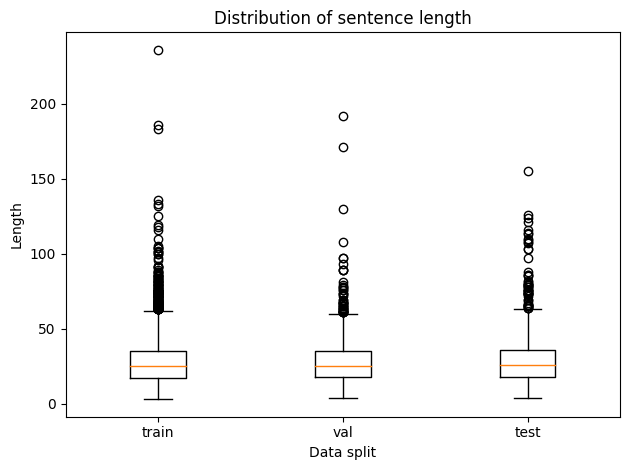

In [ ]:
sent_len_train = [len(i) for i in encoded_train_dataset["labels"]]
sent_len_val = [len(i) for i in encoded_val_dataset["labels"]]
sent_len_test = [len(i) for i in encoded_test_dataset["labels"]]
print(sent_len_val[0])

fig, ax = plt.subplots()
data = [sent_len_train, sent_len_val, sent_len_test]
labels = ['train', 'val', 'test']

ax.boxplot(data, labels=labels)

ax.set_xlabel('Data split')
ax.set_ylabel('Length')
ax.set_title('Distribution of sentence length')

plt.tight_layout()

plt.show()

In [ ]:
#DO NOT RUN THIS CELL
LEARNING_RATE = 1e-5
WEIGHT_DECAY = 1e-3
NUM_EPOCHS = 30
BATCH_SIZE = 16
# BASE_MODEL_NAME = "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext"
BASE_MODEL_NAME = "bert-base-uncased"
# BERT uncased
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AutoModelForTokenClassification.from_pretrained(BASE_MODEL_NAME,
                                  num_labels=len(tag_names),
                                  id2label=id2label,
                                  label2id=label2id)


optimizer = AdamW(model.parameters(),
                  lr=LEARNING_RATE,
                  weight_decay=WEIGHT_DECAY)

num_training_steps = NUM_EPOCHS * len(train_dl)
lr_scheduler = get_scheduler("linear",
                             optimizer=optimizer,
                             num_warmup_steps=3000,
                             num_training_steps=num_training_steps)

model = model.to(device)

history = []
for epoch in tqdm(range(NUM_EPOCHS)):
  train_loss = do_train(model, train_dl)
  eval_loss, eval_score = do_eval(model, val_dl)
  history.append((epoch + 1, train_loss, eval_loss, eval_score))
  print("EPOCH {:d}, train loss: {:.3f}, val loss: {:.3f}, f1-score: {:.5f}".format(
      epoch + 1, train_loss, eval_loss, eval_score))
  save_checkpoint(model, MODEL_DIR, epoch + 1)
  save_training_history(history, MODEL_DIR, epoch + 1)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: 

EPOCH 1, train loss: 1255.777, val loss: 84.999, f1-score: 0.00000


  3%|▎         | 1/30 [00:40<19:39, 40.68s/it]

EPOCH 2, train loss: 302.730, val loss: 56.737, f1-score: 0.18904


  7%|▋         | 2/30 [01:20<18:40, 40.02s/it]

EPOCH 3, train loss: 208.371, val loss: 46.481, f1-score: 0.30212


 10%|█         | 3/30 [02:00<17:59, 39.98s/it]

EPOCH 4, train loss: 174.637, val loss: 42.047, f1-score: 0.30921


 13%|█▎        | 4/30 [02:40<17:21, 40.06s/it]

EPOCH 5, train loss: 154.388, val loss: 37.271, f1-score: 0.33963


 17%|█▋        | 5/30 [03:21<16:47, 40.29s/it]

EPOCH 6, train loss: 136.587, val loss: 33.689, f1-score: 0.38513


 20%|██        | 6/30 [04:01<16:10, 40.44s/it]

EPOCH 7, train loss: 119.739, val loss: 30.630, f1-score: 0.45011


 23%|██▎       | 7/30 [04:42<15:33, 40.57s/it]

EPOCH 8, train loss: 104.546, val loss: 27.582, f1-score: 0.49592


 27%|██▋       | 8/30 [05:23<14:54, 40.67s/it]

EPOCH 9, train loss: 90.961, val loss: 25.950, f1-score: 0.51702


 30%|███       | 9/30 [06:04<14:16, 40.77s/it]

EPOCH 10, train loss: 79.193, val loss: 23.911, f1-score: 0.54207


 33%|███▎      | 10/30 [06:45<13:36, 40.83s/it]

EPOCH 11, train loss: 66.906, val loss: 22.467, f1-score: 0.55858


 37%|███▋      | 11/30 [07:26<12:56, 40.89s/it]

EPOCH 12, train loss: 56.632, val loss: 21.572, f1-score: 0.57054


 40%|████      | 12/30 [08:07<12:16, 40.92s/it]

EPOCH 13, train loss: 48.694, val loss: 20.212, f1-score: 0.60926


 43%|████▎     | 13/30 [08:48<11:36, 40.96s/it]

EPOCH 14, train loss: 41.719, val loss: 19.954, f1-score: 0.62857


 47%|████▋     | 14/30 [09:29<10:55, 40.97s/it]

EPOCH 15, train loss: 35.637, val loss: 19.578, f1-score: 0.63993


 50%|█████     | 15/30 [10:10<10:14, 40.99s/it]

EPOCH 16, train loss: 30.102, val loss: 19.834, f1-score: 0.64686


 53%|█████▎    | 16/30 [10:51<09:33, 41.00s/it]

EPOCH 17, train loss: 26.867, val loss: 20.098, f1-score: 0.65341


 57%|█████▋    | 17/30 [11:32<08:52, 40.98s/it]

EPOCH 18, train loss: 23.678, val loss: 19.301, f1-score: 0.66840


 60%|██████    | 18/30 [12:13<08:11, 40.97s/it]

EPOCH 19, train loss: 20.964, val loss: 19.336, f1-score: 0.66988


 63%|██████▎   | 19/30 [12:54<07:30, 40.97s/it]

EPOCH 20, train loss: 18.929, val loss: 19.420, f1-score: 0.66773


 67%|██████▋   | 20/30 [13:35<06:49, 41.00s/it]

EPOCH 21, train loss: 17.571, val loss: 19.218, f1-score: 0.67286


 70%|███████   | 21/30 [14:16<06:08, 41.00s/it]

EPOCH 22, train loss: 15.775, val loss: 19.403, f1-score: 0.68002


 73%|███████▎  | 22/30 [14:57<05:28, 41.00s/it]

EPOCH 23, train loss: 14.391, val loss: 19.540, f1-score: 0.68168


 77%|███████▋  | 23/30 [15:38<04:47, 41.00s/it]

EPOCH 24, train loss: 13.663, val loss: 19.729, f1-score: 0.66716


 80%|████████  | 24/30 [16:19<04:05, 41.00s/it]

EPOCH 25, train loss: 12.445, val loss: 19.978, f1-score: 0.66829


 83%|████████▎ | 25/30 [17:00<03:25, 41.01s/it]

EPOCH 26, train loss: 11.925, val loss: 19.748, f1-score: 0.66948


 87%|████████▋ | 26/30 [17:41<02:43, 40.99s/it]

EPOCH 27, train loss: 11.170, val loss: 19.708, f1-score: 0.66876


 90%|█████████ | 27/30 [18:22<02:02, 40.99s/it]

EPOCH 28, train loss: 10.493, val loss: 19.939, f1-score: 0.66788


 93%|█████████▎| 28/30 [19:03<01:21, 40.99s/it]

EPOCH 29, train loss: 10.174, val loss: 19.908, f1-score: 0.66490


 97%|█████████▋| 29/30 [19:44<00:40, 40.99s/it]

EPOCH 30, train loss: 9.983, val loss: 19.923, f1-score: 0.66359


100%|██████████| 30/30 [20:25<00:00, 40.85s/it]


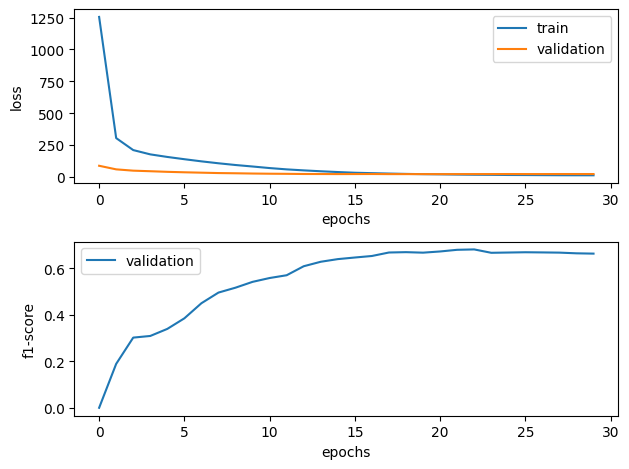

In [ ]:
#DO NOT RUN THIS
import matplotlib.pyplot as plt
plt.subplot(2, 1, 1)
plt.plot([train_loss for _, train_loss, _, _ in history], label="train")
plt.plot([eval_loss for _, _, eval_loss, _ in history], label="validation")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(loc="best")

plt.subplot(2, 1, 2)
plt.plot([eval_score for _, _, _, eval_score in history], label="validation")
plt.xlabel("epochs")
plt.ylabel("f1-score")
plt.legend(loc="best")

plt.tight_layout()
_ = plt.show()


In [ ]:
#DO NOT RUN THIS
id2label_copy = id2label.copy()
id2label[-100] = "IGN"
test_labels_list, test_preds_list = [], []
for batch in test_dl:
  labels_list, preds_list = get_label_and_predicted_tags(batch)
  for labels, preds in zip(labels_list, preds_list):
    test_labels_list.append(labels)
    test_preds_list.append(preds)

test_report = classification_report(test_labels_list, test_preds_list)
print(test_report)
# with open(os.path.join(MODEL_DIR, "test_report_bert.txt"), "w") as f:
#   f.write(test_report)
# f.close()

/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       brand       0.72      0.59      0.65       188
  brand-AD-1       0.72      0.74      0.73        39
  brand-AD-2       0.58      0.73      0.65        30
  brand-EF-1       0.63      0.50      0.56        34
  brand-EF-2       0.38      0.29      0.32        21
 brand-INT-1       0.00      0.00      0.00         1
 brand-INT-2       0.00      0.00      0.00         2
   brand-M-1       0.00      0.00      0.00         1
  brand-ME-1       0.75      0.64      0.69        28
  brand-ME-2       0.72      0.52      0.60        25
        drug       0.79      0.78      0.78       989
   drug-AD-1       0.73      0.74      0.73        84
   drug-AD-2       0.69      0.77      0.73        95
   drug-EF-1       0.65      0.78      0.71       130
   drug-EF-2       0.55      0.74      0.63       149
  drug-INT-1       0.56      0.31      0.40        16
  drug-INT-2       0.47      0.42      0.45        40
    drug-M-1       0.00    

In [ ]:
# #DO NOT RUN THIS CELL
# predicted_tokens, predicted_tags = predict(labeled_text_all_test)


# test_pred_bert = pd.DataFrame([predicted_tokens, predicted_tags], index=["tokens", "predicted_tags"])

# print(test_pred_bert.shape)
# print(test_pred_bert.head())
# test_pred_bert.to_csv(os.path.join(MODEL_DIR, "test_pred_bert.csv"))

# pd.DataFrame(predicted_tokens).to_csv(os.path.join(MODEL_DIR, "test_pred_tokens_bert_e30.csv"))
# pd.DataFrame(predicted_tags).to_csv(os.path.join(MODEL_DIR, "test_pred_tags_bert_e30.csv"))


### RE-rules

In [ ]:
# MODEL_DIR=PROJ_DIR
CHECKPOINT_PATH = MODEL_DIR+"/ckpt-23/pytorch_model.bin"
BASE_MODEL_NAME = "bert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoint = torch.load(CHECKPOINT_PATH, map_location=device)
model = AutoModelForTokenClassification.from_pretrained(BASE_MODEL_NAME,
                                  num_labels=len(tag_names),
                                  id2label=id2label,
                                  label2id=label2id)
model.load_state_dict(checkpoint)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: 

<All keys matched successfully>

In [ ]:
# predicted_tokens, predicted_tags = predict(labeled_text_all_test)
# predicted_tags

In [ ]:
# run this after loading model
id2label_copy = id2label.copy()
id2label[-100] = "IGN"
test_labels_list, test_preds_list = [], []
for batch in test_dl:
  labels_list, preds_list = get_label_and_predicted_tags(batch)
  for labels, preds in zip(labels_list, preds_list):
    test_labels_list.append(labels)
    test_preds_list.append(preds)

test_report = classification_report(test_labels_list, test_preds_list)
print(test_report)

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       brand       0.69      0.64      0.67       188
  brand-AD-1       0.78      0.79      0.78        39
  brand-AD-2       0.65      0.73      0.69        30
  brand-EF-1       0.73      0.47      0.57        34
  brand-EF-2       0.40      0.19      0.26        21
 brand-INT-1       0.00      0.00      0.00         1
 brand-INT-2       0.00      0.00      0.00         2
   brand-M-1       0.00      0.00      0.00         1
  brand-ME-1       0.71      0.54      0.61        28
  brand-ME-2       0.75      0.48      0.59        25
        drug       0.75      0.81      0.78       989
   drug-AD-1       0.75      0.69      0.72        84
   drug-AD-2       0.73      0.74      0.73        95
   drug-EF-1       0.66      0.69      0.68       130
   drug-EF-2       0.56      0.70      0.62       149
  drug-INT-1       0.50      0.12      0.20        16
  drug-INT-2       0.55      0.42      0.48        40
    drug-M-1       0.00    

In [ ]:
doc_idx = 0
confusion = {"tp":0, "fp":0, "fn":0, "tn":0}
count_tp = 0
mismatch_idx = []
pred_rels_all_test = []
for i in range(len(test_labels_list)):

  if i == sum(doc_lengths_test[:doc_idx+1]):
    # print(sum(doc_lengths_test[:doc_idx+1]))
    print("====== doc", doc_idx, ", drug ", drugs_all_test[doc_idx])
    doc_idx += 1

  # print(drugs_all_test[doc_idx])
  cur_drug_arg1 = []
  cur_drug_arg2 = []
  cur_drug_rel_type = []
  cur_drug = drugs_all_test[doc_idx]

  # completely correct labeling, meaning all relations are correct
  if test_labels_list[i] == test_preds_list[i]:
    count_tp += len(cur_drug_rel_type)
  else:
    mismatch_idx.append([i, drugs_all_test[doc_idx]])

  arg1_idx = []
  arg2_idx = []
  # arg1_idx_m = []
  # arg2_idx_m = []
  j = 0
  while j < len(test_preds_list[i]):
  # for j in range(len(test_labels_list[i])):
    if test_preds_list[i][j] == "O":
      j += 1
    else:
      cur_split = test_preds_list[i][j].split("-")
      if len(cur_split) > 2:
        if cur_split[3] == "1" and cur_split[0] == "S":
          arg1_idx.append((j, j+1))
          j += 1
        elif cur_split[3] == "1" and cur_split[0] == "B":
          start_idx = j
          j += 1
          end_idx = j
          while test_preds_list[i][j] != "O":
            j += 1
            end_idx = j

            if j >= len(test_preds_list[i]):
              break
          if end_idx == len(test_preds_list[i]):
            end_idx = start_idx + 1
          arg1_idx.append((start_idx, end_idx))
        # elif cur_split[3] == "1" and cur_split[0] == "I"

        elif cur_split[3] == "2" and cur_split[0] == "S":
          arg2_idx.append((j, j+1))
          j += 1
        elif cur_split[3] == "2" and cur_split[0] == "B":
          start_idx = j
          j += 1
          end_idx = j
          while test_preds_list[i][j] != "O":
            j += 1
            end_idx = j

            if j >= len(test_preds_list[i]):
              break
          if end_idx == len(test_preds_list[i]):
            end_idx = start_idx + 1
          arg2_idx.append((start_idx, end_idx))
        else:
          # print("other", cur_split)
          j+=1
      else:
        # print("not 5 len label", cur_split)

        j+=1

  print(arg1_idx, arg2_idx)

  print(test_preds_list[i])
  print(test_labels_list[i])

  # print(arg1_idx, arg2_idx)
  sent_rels = []
  for j in arg1_idx:
    cur_tokens = test_preds_list[i][j[0]:j[1]]
    cur_split = test_preds_list[i][j[0]].split("-")

    if len(cur_tokens) > 1:
      print("multi token entity:", cur_tokens, labeled_text_all_test[i][j[0]:j[1]])
      arg1_span_text = ' '.join(labeled_text_all_test[i][j[0]:j[1]])
    else:
      arg1_span_text = labeled_text_all_test[i][j[0]]
    print("arg1 true label:", test_labels_list[i][j[0]:j[1]], "| pred label:",test_preds_list[i][j[0]:j[1]])
    for k in range(j[1], len(test_labels_list[i])):
      if k == 37:
        print(test_preds_list[i][k])
      if test_preds_list[i][k] != "O":
        arg2_split = test_preds_list[i][k].split("-")
        # print("gs arg2", )
        if len(arg2_split) > 2:
          # strict rel
          if arg2_split[3] == "2":
            print(k,[idx for idx in arg2_idx if idx[0] == k], arg2_split)
            arg2_span_idx = [idx for idx in arg2_idx if idx[0] == k]
            if len(arg2_span_idx) > 1:
              arg2_span_idx = arg2_span_idx[0]
            else:
              arg2_span_idx = [k, k+1]
              temp_end_idx = k+1
              if temp_end_idx < len(test_preds_list[i]):

                while test_preds_list[i][temp_end_idx] != "O":
                  temp_end_idx += 1
                  if temp_end_idx >= len(test_preds_list[i]):
                    break
              if temp_end_idx >= len(test_preds_list[i]):
                temp_end_idx = k+1
              arg2_span_idx = [k, temp_end_idx]
            #
            print("arg2_span_idx:", arg2_span_idx, len(test_preds_list[i]))
            arg2_span = test_preds_list[i][arg2_span_idx[0]:arg2_span_idx[1]]
            if len(arg2_span) > 1:
              arg2_span_text = ' '.join(labeled_text_all_test[i][arg2_span_idx[0]:arg2_span_idx[1]])
            else:
              arg2_span_text = labeled_text_all_test[i][arg2_span_idx[0]]
            # doc_id, true token, true token for pred relation, pred_arg1_rel_type, pred_arg2_rel_type
            if arg2_split[2] == cur_split[2]:
              rel_to_append = [cur_drug,
                                arg1_span_text,
                                arg2_span_text,
                                label_rel_type[cur_split[2]],
                                label_rel_type[arg2_split[2]]]
              if rel_to_append not in sent_rels:
                sent_rels.append(rel_to_append)
              break
            elif arg2_split[2] != cur_split[2] and cur_split[2] == "M":
              rel_to_append = [cur_drug,
                                arg1_span_text,
                                arg2_span_text,
                                label_rel_type[cur_split[2]],
                                label_rel_type[arg2_split[2]]]
              if rel_to_append not in sent_rels:
                sent_rels.append(rel_to_append)
            break
            print("arg2 true label:", test_labels_list[i][k], "| pred label:",test_preds_list[i][k])

            print("arg1 true label:", test_labels_list[i][k], "| pred label:",test_preds_list[i][k])

  pred_rels_all_test.append(sent_rels)

print(count_tp, len(mismatch_idx))
print(pred_rels_all_test)

Streaming output truncated to the last 5000 lines.
['O', 'O', 'O', 'S-drug', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'S-drug', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['O', 'O', 'O', 'S-drug', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'S-drug', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
[] []
['O', 'O', 'O', 'O', 'S-drug_n', 'O', 'O', 'O', 'O', 'O', 'O', 'S-drug', 'O', 'S-drug', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'S-drug_n', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'S-drug', 'O', 'S-drug', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
[] []
['O', 'O', 'O', 'O', 'O', 'O']
['O', 'O', 'O', 'O', 'O', 'O']
[] []
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'S-drug', 'O', 'O', 'O', 'O']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'S-drug', 'O', 'O', 'O', 'O']

In [ ]:
# For Haneen, it's the fn_drugs_all list from the previous cell
# fn_drugs_all is a list of lists, each sublist is the the entities within a sentence, all lower case.
# if an entity occurs more than once in the sentence, they only appear once in this list
import pickle
Pubmed_pickle_file_name = 'FN_BERT_base.pkl'
project_DIR='/content/gdrive/MyDrive/NLP_final_project/'
filepath = project_DIR  + Pubmed_pickle_file_name

print(len(fn_drugs_all))

# Pickling the list of lists
with open(filepath, 'wb') as file:
    pickle.dump(fn_drugs_all, file)

print(f"fn_drugs_all has been pickled and saved to {filepath}")


1299
fn_drugs_all has been pickled and saved to /content/gdrive/MyDrive/NLP_final_project/FN_BERT_base.pkl


In [ ]:
import pickle
Pubmed_pickle_file_name = 'Modified_FN_BERT_Base.pkl'
project_DIR='/content/gdrive/MyDrive/NLP_final_project/'
filepath = project_DIR  + Pubmed_pickle_file_name
with open(filepath, 'rb') as handle:
    fn_drugs_all = pickle.load(handle)

print(len(fn_drugs_all), fn_drugs_all[1290])

1299 ['O']


In [ ]:
# doc_idx = 0
# confusion = {"tp":0, "fp":0, "fn":0, "tn":0}
# count_tp = 0
# mismatch_idx = []
# pred_rels_all_test = []
# fn_drugs_all = []
# fn_labels_all = []
# for i in range(len(test_labels_list)):

#   if i == sum(doc_lengths_test[:doc_idx+1]):
#     # print(sum(doc_lengths_test[:doc_idx+1]))
#     print("====== doc", doc_idx, ", drug ", drugs_all_test[doc_idx])
#     doc_idx += 1

#   # print(drugs_all_test[doc_idx])
#   cur_drug_arg1 = []
#   cur_drug_arg2 = []
#   cur_drug_rel_type = []
#   cur_drug = drugs_all_test[doc_idx]
#   fn_drugs = []
#   fn_labels = []

#   # completely correct labeling, meaning all relations are correct
#   if test_labels_list[i] == test_preds_list[i]:
#     count_tp += len(cur_drug_rel_type)
#   else:
#     mismatch_idx.append([i, drugs_all_test[doc_idx]])

#   arg1_idx = []
#   arg2_idx = []
#   # arg1_idx_m = []
#   # arg2_idx_m = []
#   j = 0
#   while j < len(test_preds_list[i]):
#   # for j in range(len(test_labels_list[i])):
#     if test_preds_list[i][j] == "O":
#       j += 1
#     else:
#       cur_split = test_preds_list[i][j].split("-")
#       if len(cur_split) > 2:
#         if cur_split[3] == "1" and cur_split[0] == "S":
#           arg1_idx.append((j, j+1))
#           j += 1
#         elif cur_split[3] == "1" and cur_split[0] == "B":
#           start_idx = j
#           j += 1
#           end_idx = j
#           while test_preds_list[i][j] != "O":
#             j += 1
#             end_idx = j

#             if j >= len(test_preds_list[i]):
#               break
#           if end_idx == len(test_preds_list[i]):
#             end_idx = start_idx + 1
#           arg1_idx.append((start_idx, end_idx))
#         # elif cur_split[3] == "1" and cur_split[0] == "I"

#         elif cur_split[3] == "2" and cur_split[0] == "S":
#           arg2_idx.append((j, j+1))
#           j += 1
#         elif cur_split[3] == "2" and cur_split[0] == "B":
#           start_idx = j
#           j += 1
#           end_idx = j
#           while test_preds_list[i][j] != "O":
#             j += 1
#             end_idx = j

#             if j >= len(test_preds_list[i]):
#               break
#           if end_idx == len(test_preds_list[i]):
#             end_idx = start_idx + 1
#           arg2_idx.append((start_idx, end_idx))
#         else:
#           # print("other", cur_split)
#           j+=1
#       else:
#         # print("not 5 len label", cur_split)
#         fn_labels.append(test_labels_list[i][j])
#         # fn_drugs.append(labeled_text_all_test[i][j])
#         print(labeled_text_all_test[i][j])
#         j+=1



#   print(arg1_idx, arg2_idx)
#   # print("fn_drugs", fn_drugs)
#   print(test_preds_list[i])
#   print(test_labels_list[i])

#   # print(arg1_idx, arg2_idx)
#   sent_rels = []
#   for j in arg1_idx:
#     cur_tokens = test_preds_list[i][j[0]:j[1]]
#     cur_split = test_preds_list[i][j[0]].split("-")

#     if len(cur_tokens) > 1:
#       print("multi token entity:", cur_tokens, labeled_text_all_test[i][j[0]:j[1]])
#       arg1_span_text = ' '.join(labeled_text_all_test[i][j[0]:j[1]])

#     else:
#       arg1_span_text = labeled_text_all_test[i][j[0]]
#     fn_drugs.append(arg1_span_text)
#     print("arg1 true label:", test_labels_list[i][j[0]:j[1]], "| pred label:",test_preds_list[i][j[0]:j[1]])
#     for k in range(j[1], len(test_labels_list[i])):
#       # if k == 37:
#       #   print(test_preds_list[i][k])
#       if test_preds_list[i][k] != "O":
#         arg2_split = test_preds_list[i][k].split("-")

#         if len(arg2_split) > 2:
#           # strict rel
#           if arg2_split[3] == "2":
#             print(k,[idx for idx in arg2_idx if idx[0] == k], arg2_split)
#             arg2_span_idx = [idx for idx in arg2_idx if idx[0] == k]
#             if len(arg2_span_idx) > 1:
#               arg2_span_idx = arg2_span_idx[0]
#             else:
#               arg2_span_idx = [k, k+1]
#               temp_end_idx = k+1
#               if temp_end_idx < len(test_preds_list[i]):
#                 while test_preds_list[i][temp_end_idx] != "O":
#                   temp_end_idx += 1
#                   if temp_end_idx >= len(test_preds_list[i]):
#                     break
#               if temp_end_idx >= len(test_preds_list[i]):
#                 temp_end_idx = k+1
#               arg2_span_idx = [k, temp_end_idx]
#             #
#             print("arg2_span_idx:", arg2_span_idx, len(test_preds_list[i]))
#             arg2_span = test_preds_list[i][arg2_span_idx[0]:arg2_span_idx[1]]
#             if len(arg2_span) > 1:
#               arg2_span_text = ' '.join(labeled_text_all_test[i][arg2_span_idx[0]:arg2_span_idx[1]])
#             else:
#               arg2_span_text = labeled_text_all_test[i][arg2_span_idx[0]]
#             # doc_id, true token, true token for pred relation, pred_arg1_rel_type, pred_arg2_rel_type
#             if arg2_split[2] == cur_split[2]:
#               rel_to_append = [cur_drug,
#                                 arg1_span_text,
#                                 arg2_span_text,
#                                 label_rel_type[cur_split[2]],
#                                 label_rel_type[arg2_split[2]]]
#               if rel_to_append not in sent_rels:
#                 sent_rels.append(rel_to_append)
#               break
#             elif arg2_split[2] != cur_split[2] and cur_split[2] == "M":
#               rel_to_append = [cur_drug,
#                                 arg1_span_text,
#                                 arg2_span_text,
#                                 label_rel_type[cur_split[2]],
#                                 label_rel_type[arg2_split[2]]]
#               if rel_to_append not in sent_rels:
#                 sent_rels.append(rel_to_append)
#             break
#             print("arg2 true label:", test_labels_list[i][k], "| pred label:",test_preds_list[i][k])
#   pred_rels_all_test.append(sent_rels)

#   fn_drugs_all.append(fn_drugs)
#   # sent_rels_all.append(sent_rels)
# print(fn_drugs_all)
#   # print(sent_rels)

In [ ]:
doc_idx = 0
in_doc_idx = 0

# rel type has to match, both entity strings need to exactly match
strict_confusion = {"tp":0, "fp":0, "fn":0, "tn":0}

# rel type has to match, both entity strings only need to partially match
partial_confusion = {"tp":0, "fp":0, "fn":0, "tn":0}

# rel type does not have to match, both entity strings need to exactly match
rel_confusion = {"tp":0, "fp":0, "fn":0, "tn":0}

# rel type does not have to match, both entity strings only need to partially match
rel_partial_confusion = {"tp":0, "fp":0, "fn":0, "tn":0}

# confusion by type
confusion_by_type = {"effect": {"tp":0, "fp":0, "fn":0, "tn":0},
                     "mechanism": {"tp":0, "fp":0, "fn":0, "tn":0},
                     "advise": {"tp":0, "fp":0, "fn":0, "tn":0},
                     "int": {"tp":0, "fp":0, "fn":0, "tn":0}}


for i in range(len(pred_rels_all_test)):

  if i == sum(doc_lengths_test[:doc_idx+1]):
    # print(sum(doc_lengths_test[:doc_idx+1]))
    print("====== doc", doc_idx, ", drug ", drugs_all_test[doc_idx])
    in_doc_idx = 0
    doc_idx += 1

  cur_drug = drugs_all_test[doc_idx]
  ent2id_all_drug = ent2id_all_test[cur_drug]
  id2ent_all_drug = {}
  for j in range(len(ent2id_all_drug)):
    for key,val in ent2id_all_drug[j].items():
      id2ent_all_drug[val] = key

  if len(pred_rels_all_test[i]) > 1:
    print(i, pred_rels_all_test[i])
    print("orig tokens:", labeled_text_all_test[i])
    print("orig ner tags:", ner_tags_all_test[i])
    print("pred ner tags:", test_preds_list[i])


    # print(drugs_all_test[doc_idx])
    cur_drug_arg1 = []
    cur_drug_arg2 = []
    cur_drug_rels = []
    cur_drug = drugs_all_test[doc_idx]

    sent_annot = sentence_annot_all_test[cur_drug][in_doc_idx]
    print("sent_annot len", len(sent_annot))

    if len(sent_annot) == 5:
      for j in range(len(sent_annot[4])):
        print(sent_annot[4][j])
        true_triplet = [sent_annot[4][j][0][0].lower(), sent_annot[4][j][1][0].lower(), sent_annot[4][j][2].lower()]
        if true_triplet not in cur_drug_rels:
          cur_drug_rels.append(true_triplet)
    else:
      strict_confusion["fp"] += len(pred_rels_all_test[i])

    print(len(cur_drug_rels), "number of true relations in this drug doc")
    # print(len(pred_rels_all_test[i]), "number of pred relations in this drug doc", len(np.unique(np.array())))

    print("true relations:", cur_drug_rels)

      # pred_triplet_dedup = [np.unique(np.array(pred_rels_all_test[i]))]
    print("pred relations:", pred_rels_all_test[i])
    # print(pred_triplet_dedup)


    cur_drug_rels_set = [set(r) for r in cur_drug_rels]
    pred_triplet = []
    # if the line above says 0 then the preds are all false positives
    # if len(cur_drug_rels) == 0:
    #   strict_confusion["fp"] += len(pred_rels_all_test[i])

    for j in range(len(pred_rels_all_test[i])):
      arg1_pred = pred_rels_all_test[i][j][1].lower()
      arg2_pred = pred_rels_all_test[i][j][2].lower()
      arg1_rel_type_pred = pred_rels_all_test[i][j][3].lower()
      arg2_rel_type_pred = pred_rels_all_test[i][j][4].lower()

      cur_triplet = set([arg1_pred, arg2_pred, arg1_rel_type_pred])
      if cur_triplet not in cur_drug_rels_set:
        print("fp: ", cur_triplet)
        strict_confusion["fp"] += 1
        confusion_by_type[arg1_rel_type_pred]["fp"] += 1
      else:
        strict_confusion["tp"] += 1
        confusion_by_type[arg1_rel_type_pred]["tp"] += 1

      pred_triplet.append(cur_triplet)

    for k in range(len(cur_drug_rels_set)):
      cur_triplet = set(cur_drug_rels_set[k])

      cur_rel_type = [t for t in cur_triplet if t in confusion_by_type.keys()]
      # print("cur_triplet", cur_rel_type)
      if cur_drug_rels[k] not in pred_triplet:
        print("fn: ", cur_drug_rels[k])
        strict_confusion["fn"] += 1
        confusion_by_type[cur_rel_type[0]]["fn"] += 1


  in_doc_idx += 1
print(strict_confusion)
precision_test = strict_confusion["tp"]/(strict_confusion["tp"]+strict_confusion["fp"])
recall_test = strict_confusion["tp"]/(strict_confusion["tp"]+strict_confusion["fn"])
f1_test = 2*precision_test*recall_test/(precision_test+recall_test)
print("precision:", precision_test)
print("recall:", recall_test)
print("f1:", f1_test)

# print("------------- by type match result below --------------")
print(confusion_by_type)
for rel_type in confusion_by_type.keys():
  precision_test = confusion_by_type[rel_type]["tp"]/(confusion_by_type[rel_type]["tp"]+confusion_by_type[rel_type]["fp"]) if (confusion_by_type[rel_type]["tp"]+confusion_by_type[rel_type]["fp"]) else 0
  recall_test = confusion_by_type[rel_type]["tp"]/(confusion_by_type[rel_type]["tp"]+confusion_by_type[rel_type]["fn"]) if (confusion_by_type[rel_type]["tp"]+confusion_by_type[rel_type]["fn"]) else 0
  f1_test = 2*precision_test*recall_test/(precision_test+recall_test) if (precision_test+recall_test) else 0
  print(rel_type," precision:", precision_test)
  print(rel_type, " recall:", recall_test)
  print(rel_type, " f1:", f1_test)

====== doc 0 , drug  21705423
====== doc 1 , drug  21706316
====== doc 2 , drug  21715267
36 [['21716267', 'S-ketamine', 'ticlopidine', 'mechanism', 'mechanism'], ['21716267', 'itraconazole', 'ticlopidine', 'mechanism', 'mechanism']]
orig tokens: ['Exposure', 'to', 'oral', 'S-ketamine', 'is', 'unaffected', 'by', 'itraconazole', 'but', 'greatly', 'increased', 'by', 'ticlopidine', '.']
orig ner tags: ['O', 'O', 'O', 'S-drug-EF-1', 'O', 'O', 'O', 'S-drug', 'O', 'O', 'O', 'O', 'S-drug-EF-2', 'O']
pred ner tags: ['O', 'O', 'O', 'S-drug-ME-1', 'O', 'O', 'O', 'S-drug-ME-1', 'O', 'O', 'O', 'O', 'S-drug-ME-2', 'O']
sent_annot len 5
[('S-ketamine', '17-26'), ('ticlopidine', '83-93'), 'effect']
1 number of true relations in this drug doc
true relations: [['s-ketamine', 'ticlopidine', 'effect']]
pred relations: [['21716267', 'S-ketamine', 'ticlopidine', 'mechanism', 'mechanism'], ['21716267', 'itraconazole', 'ticlopidine', 'mechanism', 'mechanism']]
fp:  {'mechanism', 'ticlopidine', 's-ketamine'}


In [ ]:
doc_idx = 0
in_doc_idx = 0

# rel type has to match, both entity strings need to exactly match
strict_confusion = {"tp":0, "fp":0, "fn":0, "tn":0}

# rel type has to match, both entity strings only need to partially match
partial_confusion = {"tp":0, "fp":0, "fn":0, "tn":0}

# rel type does not have to match, both entity strings need to exactly match
rel_confusion = {"tp":0, "fp":0, "fn":0, "tn":0}

# rel type does not have to match, both entity strings only need to partially match
rel_partial_confusion = {"tp":0, "fp":0, "fn":0, "tn":0}

# confusion by type
confusion_by_type = {"effect": {"tp":0, "fp":0, "fn":0, "tn":0},
                     "mechanism": {"tp":0, "fp":0, "fn":0, "tn":0},
                     "advise": {"tp":0, "fp":0, "fn":0, "tn":0},
                     "int": {"tp":0, "fp":0, "fn":0, "tn":0}}
count_kg = 0

for i in range(len(pred_rels_all_test)):

  if i == sum(doc_lengths_test[:doc_idx+1]):
    # print(sum(doc_lengths_test[:doc_idx+1]))
    print("====== doc", doc_idx, ", drug ", drugs_all_test[doc_idx])
    in_doc_idx = 0
    doc_idx += 1

  cur_drug = drugs_all_test[doc_idx]
  ent2id_all_drug = ent2id_all_test[cur_drug]
  id2ent_all_drug = {}
  for j in range(len(ent2id_all_drug)):
    for key,val in ent2id_all_drug[j].items():
      id2ent_all_drug[val] = key

  if len(pred_rels_all_test[i]) > 1:
    print(i, pred_rels_all_test[i])
    print("orig tokens:", labeled_text_all_test[i])
    print("orig ner tags:", ner_tags_all_test[i])
    print("pred ner tags:", test_preds_list[i])


    # print(drugs_all_test[doc_idx])
    cur_drug_arg1 = []
    cur_drug_arg2 = []
    cur_drug_rels = []
    cur_drug = drugs_all_test[doc_idx]


    sent_annot = sentence_annot_all_test[cur_drug][in_doc_idx]
    print("sent_annot len", len(sent_annot))

    if len(sent_annot) == 5:
      for j in range(len(sent_annot[4])):
        print(sent_annot[4][j])
        true_triplet = [sent_annot[4][j][0][0].lower(), sent_annot[4][j][1][0].lower(), sent_annot[4][j][2].lower()]
        if true_triplet not in cur_drug_rels:
          cur_drug_rels.append(true_triplet)
    else:
      strict_confusion["fp"] += len(pred_rels_all_test[i])

    print(len(cur_drug_rels), "number of true relations in this drug doc")
    # print(len(pred_rels_all_test[i]), "number of pred relations in this drug doc", len(np.unique(np.array())))

    print("true relations:", cur_drug_rels)

      # pred_triplet_dedup = [np.unique(np.array(pred_rels_all_test[i]))]
    print("pred relations:", pred_rels_all_test[i])
    # print(pred_triplet_dedup)


    cur_drug_rels_set = [set(r) for r in cur_drug_rels]
    pred_triplet = []
    # if the line above says 0 then the preds are all false positives
    cur_kg_rels = [r for r in fn_drugs_all[i] if r != "O"]

    print("KG recovery:",  cur_kg_rels)
    for j in range(len(pred_rels_all_test[i])):
      arg1_pred = pred_rels_all_test[i][j][1].lower()
      arg2_pred = pred_rels_all_test[i][j][2].lower()
      arg1_rel_type_pred = pred_rels_all_test[i][j][3].lower()
      arg2_rel_type_pred = pred_rels_all_test[i][j][4].lower()

      additional_rel = []
      rel_exist = False
      for k in range(len(cur_kg_rels)):
        kg_rel = cur_kg_rels[k][:2]
        if set(kg_rel) == set([arg1_pred, arg2_pred]):
          print("rel exist", [arg1_pred, arg2_pred], kg_rel)
          rel_exist = True
          break
        else:
          print("rel does not exist", kg_rel)
          print("====")

          arg1_idx = [l for l in range(len(labeled_text_all_test[i])) if labeled_text_all_test[i][l].lower() in kg_rel[0]]
          arg2_idx = [l for l in range(len(labeled_text_all_test[i])) if labeled_text_all_test[i][l].lower() in kg_rel[1]]

          if len(arg1_idx) >= 1 and len(arg2_idx) >= 1:
            print(labeled_text_all_test[i][arg1_idx[0]], labeled_text_all_test[i][arg2_idx[0]])
            print(test_preds_list[i][arg1_idx[0]], test_preds_list[i][arg2_idx[0]])
            kg_rel_type_arg1 = test_preds_list[i][arg1_idx[0]].split("-")
            kg_rel_type_arg2 = test_preds_list[i][arg2_idx[0]].split("-")

            print("new rel from kg", kg_rel_type_arg1, kg_rel_type_arg2)
            if len(kg_rel_type_arg1) > 2 and len(kg_rel_type_arg2) > 2:
              if kg_rel_type_arg1[2] == kg_rel_type_arg2[2]:
                print(labeled_text_all_test[i][arg1_idx[0]], labeled_text_all_test[i][arg2_idx[0]], label_rel_type[kg_rel_type_arg1[2]])
                additional_rel.append(set([kg_rel[0],
                                       kg_rel[1],
                                       label_rel_type[kg_rel_type_arg1[2]]]))
              else:
                print("FP")
            elif len(kg_rel_type_arg1) > 2 and len(kg_rel_type_arg2) == 2:
                additional_rel.append(set([kg_rel[0],
                                       kg_rel[1],
                                       label_rel_type[kg_rel_type_arg1[2]]]))

            elif len(kg_rel_type_arg1) == 2 and len(kg_rel_type_arg2) > 2:
                additional_rel.append(set([kg_rel[0],
                                       kg_rel[1],
                                       label_rel_type[kg_rel_type_arg2[2]]]))
            # elif len(lg_rel_type_arg1) == 2 and len(kg_rel_type_arg2) == 2:


          else:

            print(arg1_idx, arg2_idx, "idx more than len 1")
      print("cur additional rel from KG", additional_rel)
      # if rel_exist == False:


      cur_triplet = set([arg1_pred, arg2_pred, arg1_rel_type_pred])
      if cur_triplet not in cur_drug_rels_set:
        print("fp: ", cur_triplet)
        strict_confusion["fp"] += 1
        confusion_by_type[arg1_rel_type_pred]["fp"] += 1
      else:
        strict_confusion["tp"] += 1
        confusion_by_type[arg1_rel_type_pred]["tp"] += 1

      pred_triplet.append(cur_triplet)

    for k in range(len(cur_drug_rels_set)):
      cur_triplet = list(cur_drug_rels_set[k])

      cur_rel_type = [t for t in cur_triplet if t in confusion_by_type.keys()]
      # print("cur_triplet", cur_rel_type)
      if cur_drug_rels[k] not in pred_triplet:
        print("fn: ", cur_drug_rels[k])
        if set(cur_drug_rels[k]) not in additional_rel:
          strict_confusion["fn"] += 1
          confusion_by_type[cur_rel_type[0]]["fn"] += 1
        else:
          print("fn in orig, but recovered by KG", cur_drug_rels[k])
          strict_confusion["tp"] += 1
          confusion_by_type[cur_rel_type[0]]["tp"] += 1
          count_kg += 1



  in_doc_idx += 1
print(strict_confusion)
precision_test = strict_confusion["tp"]/(strict_confusion["tp"]+strict_confusion["fp"])
recall_test = strict_confusion["tp"]/(strict_confusion["tp"]+strict_confusion["fn"])
f1_test = 2*precision_test*recall_test/(precision_test+recall_test)
print("precision:", precision_test)
print("recall:", recall_test)
print("f1:", f1_test)

# print("------------- by type match result below --------------")
print(confusion_by_type)
for rel_type in confusion_by_type.keys():
  precision_test = confusion_by_type[rel_type]["tp"]/(confusion_by_type[rel_type]["tp"]+confusion_by_type[rel_type]["fp"]) if (confusion_by_type[rel_type]["tp"]+confusion_by_type[rel_type]["fp"]) else 0
  recall_test = confusion_by_type[rel_type]["tp"]/(confusion_by_type[rel_type]["tp"]+confusion_by_type[rel_type]["fn"]) if (confusion_by_type[rel_type]["tp"]+confusion_by_type[rel_type]["fn"]) else 0
  f1_test = 2*precision_test*recall_test/(precision_test+recall_test) if (precision_test+recall_test) else 0
  print(rel_type," precision:", precision_test)
  print(rel_type, " recall:", recall_test)
  print(rel_type, " f1:", f1_test)

print(count_kg)

====== doc 0 , drug  21705423
====== doc 1 , drug  21706316
====== doc 2 , drug  21715267
36 [['21716267', 'S-ketamine', 'ticlopidine', 'mechanism', 'mechanism'], ['21716267', 'itraconazole', 'ticlopidine', 'mechanism', 'mechanism']]
orig tokens: ['Exposure', 'to', 'oral', 'S-ketamine', 'is', 'unaffected', 'by', 'itraconazole', 'but', 'greatly', 'increased', 'by', 'ticlopidine', '.']
orig ner tags: ['O', 'O', 'O', 'S-drug-EF-1', 'O', 'O', 'O', 'S-drug', 'O', 'O', 'O', 'O', 'S-drug-EF-2', 'O']
pred ner tags: ['O', 'O', 'O', 'S-drug-ME-1', 'O', 'O', 'O', 'S-drug-ME-1', 'O', 'O', 'O', 'O', 'S-drug-ME-2', 'O']
sent_annot len 5
[('S-ketamine', '17-26'), ('ticlopidine', '83-93'), 'effect']
1 number of true relations in this drug doc
true relations: [['s-ketamine', 'ticlopidine', 'effect']]
pred relations: [['21716267', 'S-ketamine', 'ticlopidine', 'mechanism', 'mechanism'], ['21716267', 'itraconazole', 'ticlopidine', 'mechanism', 'mechanism']]
KG recovery: []
cur additional rel from KG []
fp

## BioM-ELECTRA-Large

In [ ]:

BASE_MODEL_NAME = "sultan/BioM-ELECTRA-Large-Discriminator"
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL_NAME, use_fast=True, do_lower_case=True)

train_data = []
for i in range(len(labeled_text_all_train)):
  # for j in range(len(labeled_text_all_train[i])):
    train_data.append({"tokens": labeled_text_all_train[i],
                       "ner_tags": ner_tags_all_train[i]})
val_data = []
for i in range(len(labeled_text_all_val)):
  # for j in range(len(labeled_text_all_train[i])):
    val_data.append({"tokens": labeled_text_all_val[i],
                       "ner_tags": ner_tags_all_val[i]})
test_data = []
for i in range(len(labeled_text_all_test)):
  # for j in range(len(labeled_text_all_train[i])):
    test_data.append({"tokens": labeled_text_all_test[i],
                       "ner_tags": ner_tags_all_test[i]})


train_data = Dataset.from_pandas(pd.DataFrame(data=train_data))
val_data = Dataset.from_pandas(pd.DataFrame(data=val_data))
test_data = Dataset.from_pandas(pd.DataFrame(data=test_data))

# train_data
# tokenize_and_align_labels(train_data[0:2])
encoded_train_dataset = train_data.map(tokenize_and_align_labels,
                                      batched=True,
                                      remove_columns=["ner_tags", "tokens"])

encoded_val_dataset = val_data.map(tokenize_and_align_labels,
                                      batched=True,
                                      remove_columns=["ner_tags", "tokens"])

encoded_test_dataset = test_data.map(tokenize_and_align_labels,
                                      batched=True,
                                      remove_columns=["ner_tags", "tokens"])

encoded_train_dataset, encoded_val_dataset, encoded_test_dataset

Map:   0%|          | 0/5491 [00:00<?, ? examples/s]

Map:   0%|          | 0/1341 [00:00<?, ? examples/s]

Map:   0%|          | 0/1299 [00:00<?, ? examples/s]

(Dataset({
     features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
     num_rows: 5491
 }),
 Dataset({
     features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
     num_rows: 1341
 }),
 Dataset({
     features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
     num_rows: 1299
 }))

In [ ]:

LEARNING_RATE = 1e-5
WEIGHT_DECAY = 1e-2
NUM_EPOCHS = 1
BATCH_SIZE = 16
# BASE_MODEL_NAME = "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext"
# BASE_MODEL_NAME = "bert-base-uncased"
collate_fn = DataCollatorForTokenClassification(tokenizer, padding="longest", return_tensors="pt")

train_dl = DataLoader(encoded_train_dataset,
                      # shuffle=True,
                      # sampler=SubsetRandomSampler(np.random.randint(0, encoded_gmb_dataset["train"].num_rows, 1000).tolist()),
                      batch_size=BATCH_SIZE,
                      collate_fn=collate_fn)
val_dl = DataLoader(encoded_val_dataset,
                      # shuffle=True,
                      # sampler=SubsetRandomSampler(np.random.randint(0, encoded_gmb_dataset["train"].num_rows, 1000).tolist()),
                      batch_size=BATCH_SIZE,
                      collate_fn=collate_fn)

test_dl = DataLoader(encoded_test_dataset,
                      # shuffle=True,
                      # sampler=SubsetRandomSampler(np.random.randint(0, encoded_gmb_dataset["train"].num_rows, 1000).tolist()),
                      batch_size=BATCH_SIZE,
                      collate_fn=collate_fn)


12


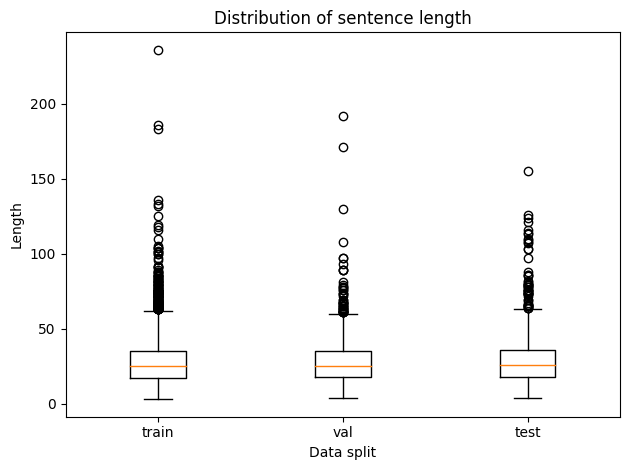

In [ ]:
sent_len_train = [len(i) for i in encoded_train_dataset["labels"]]
sent_len_val = [len(i) for i in encoded_val_dataset["labels"]]
sent_len_test = [len(i) for i in encoded_test_dataset["labels"]]
print(sent_len_val[0])

fig, ax = plt.subplots()
data = [sent_len_train, sent_len_val, sent_len_test]
labels = ['train', 'val', 'test']

ax.boxplot(data, labels=labels)

ax.set_xlabel('Data split')
ax.set_ylabel('Length')
ax.set_title('Distribution of sentence length')

plt.tight_layout()

plt.show()

In [ ]:
# from tqdm import tqdm

LEARNING_RATE = 1e-5
WEIGHT_DECAY = 1e-2
NUM_EPOCHS = 30
BATCH_SIZE = 16
BASE_MODEL_NAME = "sultan/BioM-ELECTRA-Large-Discriminator"
# BASE_MODEL_NAME = "bert-base-uncased"
# BERT uncased
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AutoModelForTokenClassification.from_pretrained(BASE_MODEL_NAME,
                                  num_labels=len(tag_names),
                                  id2label=id2label,
                                  label2id=label2id)


optimizer = AdamW(model.parameters(),
                  lr=LEARNING_RATE,
                  weight_decay=WEIGHT_DECAY)

num_training_steps = NUM_EPOCHS * len(train_dl)
lr_scheduler = get_scheduler("linear",
                             optimizer=optimizer,
                             num_warmup_steps=3000,
                             num_training_steps=num_training_steps)

model = model.to(device)

history = []
for epoch in tqdm(range(NUM_EPOCHS)):
  train_loss = do_train(model, train_dl)
  eval_loss, eval_score = do_eval(model, val_dl)
  history.append((epoch + 1, train_loss, eval_loss, eval_score))
  print("EPOCH {:d}, train loss: {:.3f}, val loss: {:.3f}, f1-score: {:.5f}".format(
      epoch + 1, train_loss, eval_loss, eval_score))
  save_checkpoint(model, MODEL_DIR, epoch + 1)
  save_training_history(history, MODEL_DIR, epoch + 1)

pytorch_model.bin:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Some weights of the model checkpoint at sultan/BioM-ELECTRA-Large-Discriminator were not used when initializing ElectraForTokenClassification: ['discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing ElectraForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForTokenClassification were not initialized from the model checkpoint at sultan/BioM-ELECTRA-Large-Discriminator and are newly initialized: ['classifier.b

EPOCH 1, train loss: 1238.214, val loss: 82.191, f1-score: 0.00000


  3%|▎         | 1/30 [01:46<51:33, 106.68s/it]

EPOCH 2, train loss: 254.970, val loss: 46.525, f1-score: 0.30997


  7%|▋         | 2/30 [03:35<50:25, 108.04s/it]

EPOCH 3, train loss: 173.031, val loss: 38.688, f1-score: 0.36427


 10%|█         | 3/30 [05:25<48:57, 108.80s/it]

EPOCH 4, train loss: 141.830, val loss: 33.745, f1-score: 0.42037


 13%|█▎        | 4/30 [07:15<47:20, 109.24s/it]

EPOCH 5, train loss: 121.111, val loss: 29.472, f1-score: 0.45824


 17%|█▋        | 5/30 [09:04<45:33, 109.36s/it]

EPOCH 6, train loss: 103.522, val loss: 24.990, f1-score: 0.52680


 20%|██        | 6/30 [10:54<43:49, 109.54s/it]

EPOCH 7, train loss: 85.128, val loss: 22.075, f1-score: 0.57509


 23%|██▎       | 7/30 [12:44<42:02, 109.68s/it]

EPOCH 8, train loss: 68.385, val loss: 19.243, f1-score: 0.63757


 27%|██▋       | 8/30 [14:34<40:17, 109.87s/it]

EPOCH 9, train loss: 54.386, val loss: 17.627, f1-score: 0.67752


 30%|███       | 9/30 [16:24<38:27, 109.86s/it]

EPOCH 10, train loss: 41.600, val loss: 17.085, f1-score: 0.68553


 33%|███▎      | 10/30 [18:14<36:37, 109.89s/it]

EPOCH 11, train loss: 33.476, val loss: 15.820, f1-score: 0.71238


 37%|███▋      | 11/30 [20:07<35:02, 110.65s/it]

EPOCH 12, train loss: 27.659, val loss: 14.917, f1-score: 0.73763


 40%|████      | 12/30 [21:56<33:06, 110.35s/it]

EPOCH 13, train loss: 22.552, val loss: 14.871, f1-score: 0.75075


 43%|████▎     | 13/30 [23:46<31:14, 110.28s/it]

EPOCH 14, train loss: 18.426, val loss: 16.051, f1-score: 0.72587


 47%|████▋     | 14/30 [25:37<29:23, 110.23s/it]

EPOCH 15, train loss: 15.601, val loss: 16.145, f1-score: 0.74715


 50%|█████     | 15/30 [27:26<27:32, 110.14s/it]

EPOCH 16, train loss: 12.873, val loss: 14.909, f1-score: 0.76479


 53%|█████▎    | 16/30 [29:17<25:41, 110.12s/it]

EPOCH 17, train loss: 10.893, val loss: 14.681, f1-score: 0.76477


 57%|█████▋    | 17/30 [31:06<23:49, 109.99s/it]

EPOCH 18, train loss: 9.591, val loss: 14.957, f1-score: 0.76599


 60%|██████    | 18/30 [32:56<21:59, 109.98s/it]

EPOCH 19, train loss: 8.132, val loss: 15.282, f1-score: 0.76792


 63%|██████▎   | 19/30 [34:46<20:09, 109.97s/it]

EPOCH 20, train loss: 7.247, val loss: 15.183, f1-score: 0.76946


 67%|██████▋   | 20/30 [36:36<18:19, 109.94s/it]

EPOCH 21, train loss: 6.289, val loss: 15.365, f1-score: 0.77276


 70%|███████   | 21/30 [38:26<16:28, 109.83s/it]

EPOCH 22, train loss: 5.694, val loss: 15.842, f1-score: 0.76907


 73%|███████▎  | 22/30 [40:16<14:39, 109.89s/it]

EPOCH 23, train loss: 5.347, val loss: 15.590, f1-score: 0.77529


 77%|███████▋  | 23/30 [42:05<12:48, 109.81s/it]

EPOCH 24, train loss: 4.790, val loss: 16.178, f1-score: 0.77304


 80%|████████  | 24/30 [43:55<10:59, 109.87s/it]

EPOCH 25, train loss: 4.239, val loss: 16.155, f1-score: 0.77784


 83%|████████▎ | 25/30 [45:45<09:09, 109.91s/it]

EPOCH 26, train loss: 3.935, val loss: 15.940, f1-score: 0.77416


 87%|████████▋ | 26/30 [47:35<07:19, 109.94s/it]

EPOCH 27, train loss: 3.744, val loss: 15.938, f1-score: 0.77864


 90%|█████████ | 27/30 [49:25<05:29, 109.84s/it]

EPOCH 28, train loss: 3.476, val loss: 16.202, f1-score: 0.78028


 93%|█████████▎| 28/30 [51:15<03:39, 109.88s/it]

EPOCH 29, train loss: 3.257, val loss: 16.209, f1-score: 0.77900


 97%|█████████▋| 29/30 [53:10<01:51, 111.30s/it]

EPOCH 30, train loss: 3.164, val loss: 16.275, f1-score: 0.78100


100%|██████████| 30/30 [54:59<00:00, 109.99s/it]


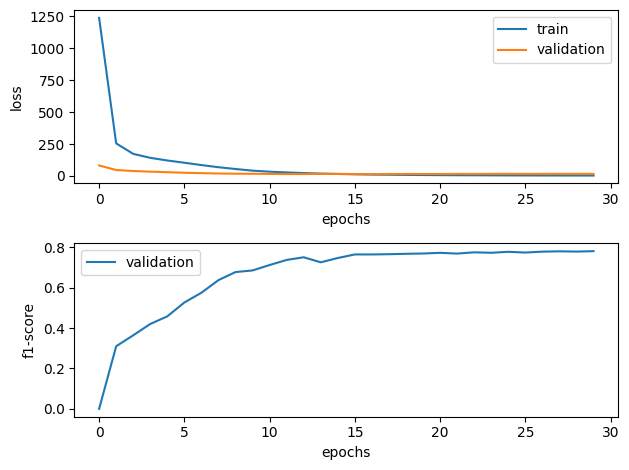

In [ ]:
import matplotlib.pyplot as plt
plt.subplot(2, 1, 1)
plt.plot([train_loss for _, train_loss, _, _ in history], label="train")
plt.plot([eval_loss for _, _, eval_loss, _ in history], label="validation")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(loc="best")

plt.subplot(2, 1, 2)
plt.plot([eval_score for _, _, _, eval_score in history], label="validation")
plt.xlabel("epochs")
plt.ylabel("f1-score")
plt.legend(loc="best")

plt.tight_layout()
_ = plt.show()

In [ ]:

id2label_copy = id2label.copy()
id2label[-100] = "IGN"
test_labels_list, test_preds_list = [], []
for batch in test_dl:
  labels_list, preds_list = get_label_and_predicted_tags(batch)
  for labels, preds in zip(labels_list, preds_list):
    test_labels_list.append(labels)
    test_preds_list.append(preds)
print(len(test_labels_list), len(test_preds_list))
print(len(test_labels_list[0]), len(test_preds_list[0]))
test_report = classification_report(test_labels_list, test_preds_list)
print(test_report)


In [ ]:

predicted_tokens, predicted_tags = predict(labeled_text_all_test)


test_pred = pd.DataFrame([predicted_tokens, predicted_tags], index=["tokens", "predicted_tags"])


print(test_pred.shape)
print(test_pred.head())
test_pred.to_csv(os.path.join(MODEL_DIR, "test_pred_biomelectra_e30.csv"))

pd.DataFrame(predicted_tokens).to_csv(os.path.join(MODEL_DIR, "test_pred_tokens_biomelectra_e30.csv"))
pd.DataFrame(predicted_tags).to_csv(os.path.join(MODEL_DIR, "test_pred_tags_biomelectra_e30.csv"))

(2, 1299)
                                                             0     \
tokens          [[CLS], metabotropic, glutamate, receptor, 5, ...   
predicted_tags  [O, B-group, I-group, I-group, I-group, E-grou...   

                                                             1     \
tokens          [[CLS], degeneration, of, the, dopaminergic, n...   
predicted_tags  [O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...   

                                                             2     \
tokens          [[CLS], there, is, an, urgent, need, to, devel...   
predicted_tags  [O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...   

                                                             3     \
tokens          [[CLS], in, the, present, study, ,, we, tested...   
predicted_tags  [O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...   

                                                             4     \
tokens          [[CLS], weekly, intramuscular, 1, -, methyl, -...   
predicted_tags  [O, 

### RE-rules

1.

In [ ]:
CHECKPOINT_PATH = MODEL_DIR+"/ckpt-15-biomelectra/pytorch_model.bin"
BASE_MODEL_NAME = "sultan/BioM-ELECTRA-Large-Discriminator"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
checkpoint = torch.load(CHECKPOINT_PATH, map_location=device)
model = AutoModelForTokenClassification.from_pretrained(BASE_MODEL_NAME,
                                  num_labels=len(tag_names),
                                  id2label=id2label_copy,
                                  label2id=label2id)
model.load_state_dict(checkpoint)

cpu


Some weights of the model checkpoint at sultan/BioM-ELECTRA-Large-Discriminator were not used when initializing ElectraForTokenClassification: ['discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.bias']
- This IS expected if you are initializing ElectraForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForTokenClassification were not initialized from the model checkpoint at sultan/BioM-ELECTRA-Large-Discriminator and are newly initialized: ['classifier.b

<All keys matched successfully>

In [ ]:
# run this after loading model
id2label_copy = id2label.copy()
id2label[-100] = "IGN"
test_labels_list, test_preds_list = [], []
for batch in test_dl:
  labels_list, preds_list = get_label_and_predicted_tags(batch)
  for labels, preds in zip(labels_list, preds_list):
    test_labels_list.append(labels)
    test_preds_list.append(preds)

test_report = classification_report(test_labels_list, test_preds_list)
print(test_report)

              precision    recall  f1-score   support

       brand       0.72      0.63      0.67       188
  brand-AD-1       0.74      0.79      0.77        39
  brand-AD-2       0.61      0.73      0.67        30
  brand-EF-1       0.72      0.62      0.67        34
  brand-EF-2       0.79      0.52      0.63        21
 brand-INT-1       0.00      0.00      0.00         1
 brand-INT-2       0.00      0.00      0.00         2
   brand-M-1       0.00      0.00      0.00         1
  brand-ME-1       0.85      0.61      0.71        28
  brand-ME-2       0.73      0.44      0.55        25
        drug       0.83      0.87      0.85       989
   drug-AD-1       0.73      0.86      0.79        84
   drug-AD-2       0.81      0.88      0.84        95
   drug-EF-1       0.76      0.81      0.78       130
   drug-EF-2       0.67      0.81      0.73       149
  drug-INT-1       0.73      0.50      0.59        16
  drug-INT-2       0.90      0.45      0.60        40
    drug-M-1       0.43    

In [ ]:
doc_idx = 0
confusion = {"tp":0, "fp":0, "fn":0, "tn":0}
count_tp = 0
mismatch_idx = []
pred_rels_all_test = []
for i in range(len(test_labels_list)):

  if i == sum(doc_lengths_test[:doc_idx+1]):
    # print(sum(doc_lengths_test[:doc_idx+1]))
    print("====== doc", doc_idx, ", drug ", drugs_all_test[doc_idx])
    doc_idx += 1

  # print(drugs_all_test[doc_idx])
  cur_drug_arg1 = []
  cur_drug_arg2 = []
  cur_drug_rel_type = []
  cur_drug = drugs_all_test[doc_idx]

  # completely correct labeling, meaning all relations are correct
  if test_labels_list[i] == test_preds_list[i]:
    count_tp += len(cur_drug_rel_type)
  else:
    mismatch_idx.append([i, drugs_all_test[doc_idx]])

  arg1_idx = []
  arg2_idx = []
  # arg1_idx_m = []
  # arg2_idx_m = []
  j = 0
  while j < len(test_preds_list[i]):
  # for j in range(len(test_labels_list[i])):
    if test_preds_list[i][j] == "O":
      j += 1
    else:
      cur_split = test_preds_list[i][j].split("-")
      if len(cur_split) > 2:
        if cur_split[3] == "1" and cur_split[0] == "S":
          arg1_idx.append((j, j+1))
          j += 1
        elif cur_split[3] == "1" and cur_split[0] == "B":
          start_idx = j
          j += 1
          end_idx = j
          while test_preds_list[i][j] != "O":
            j += 1
            end_idx = j

            if j >= len(test_preds_list[i]):
              break
          if end_idx == len(test_preds_list[i]):
            end_idx = start_idx + 1
          arg1_idx.append((start_idx, end_idx))
        # elif cur_split[3] == "1" and cur_split[0] == "I"

        elif cur_split[3] == "2" and cur_split[0] == "S":
          arg2_idx.append((j, j+1))
          j += 1
        elif cur_split[3] == "2" and cur_split[0] == "B":
          start_idx = j
          j += 1
          end_idx = j
          while test_preds_list[i][j] != "O":
            j += 1
            end_idx = j

            if j >= len(test_preds_list[i]):
              break
          if end_idx == len(test_preds_list[i]):
            end_idx = start_idx + 1
          arg2_idx.append((start_idx, end_idx))
        else:
          # print("other", cur_split)
          j+=1
      else:
        # print("not 5 len label", cur_split)

        j+=1

  print(arg1_idx, arg2_idx)

  print(test_preds_list[i])
  print(test_labels_list[i])

  # print(arg1_idx, arg2_idx)
  sent_rels = []
  for j in arg1_idx:
    cur_tokens = test_preds_list[i][j[0]:j[1]]
    cur_split = test_preds_list[i][j[0]].split("-")

    if len(cur_tokens) > 1:
      print("multi token entity:", cur_tokens, labeled_text_all_test[i][j[0]:j[1]])
      arg1_span_text = ' '.join(labeled_text_all_test[i][j[0]:j[1]])
    else:
      arg1_span_text = labeled_text_all_test[i][j[0]]
    print("arg1 true label:", test_labels_list[i][j[0]:j[1]], "| pred label:",test_preds_list[i][j[0]:j[1]])
    for k in range(j[1], len(test_labels_list[i])):
      if k == 37:
        print(test_preds_list[i][k])
      if test_preds_list[i][k] != "O":
        arg2_split = test_preds_list[i][k].split("-")
        # print("gs arg2", )
        if len(arg2_split) > 2:
          # strict rel
          if arg2_split[3] == "2":
            print(k,[idx for idx in arg2_idx if idx[0] == k], arg2_split)
            arg2_span_idx = [idx for idx in arg2_idx if idx[0] == k]
            if len(arg2_span_idx) > 1:
              arg2_span_idx = arg2_span_idx[0]
            else:
              arg2_span_idx = [k, k+1]
              temp_end_idx = k+1
              if temp_end_idx < len(test_preds_list[i]):

                while test_preds_list[i][temp_end_idx] != "O":
                  temp_end_idx += 1
                  if temp_end_idx >= len(test_preds_list[i]):
                    break
              if temp_end_idx >= len(test_preds_list[i]):
                temp_end_idx = k+1
              arg2_span_idx = [k, temp_end_idx]
            #
            print("arg2_span_idx:", arg2_span_idx, len(test_preds_list[i]))
            arg2_span = test_preds_list[i][arg2_span_idx[0]:arg2_span_idx[1]]
            if len(arg2_span) > 1:
              arg2_span_text = ' '.join(labeled_text_all_test[i][arg2_span_idx[0]:arg2_span_idx[1]])
            else:
              arg2_span_text = labeled_text_all_test[i][arg2_span_idx[0]]
            # doc_id, true token, true token for pred relation, pred_arg1_rel_type, pred_arg2_rel_type
            if arg2_split[2] == cur_split[2]:
              rel_to_append = [cur_drug,
                                arg1_span_text,
                                arg2_span_text,
                                label_rel_type[cur_split[2]],
                                label_rel_type[arg2_split[2]]]
              if rel_to_append not in sent_rels:
                sent_rels.append(rel_to_append)
              break
            elif arg2_split[2] != cur_split[2] and cur_split[2] == "M":
              rel_to_append = [cur_drug,
                                arg1_span_text,
                                arg2_span_text,
                                label_rel_type[cur_split[2]],
                                label_rel_type[arg2_split[2]]]
              if rel_to_append not in sent_rels:
                sent_rels.append(rel_to_append)
            break
            print("arg2 true label:", test_labels_list[i][k], "| pred label:",test_preds_list[i][k])

            print("arg1 true label:", test_labels_list[i][k], "| pred label:",test_preds_list[i][k])

  pred_rels_all_test.append(sent_rels)

print(count_tp, len(mismatch_idx))
print(pred_rels_all_test)

Streaming output truncated to the last 5000 lines.
['O', 'O', 'O', 'S-drug', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'S-drug', 'O', 'S-drug', 'O', 'O', 'O', 'O', 'S-drug', 'O', 'S-drug', 'O']
[] []
['O', 'O', 'O', 'O', 'O', 'S-drug', 'O', 'S-drug', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'S-drug', 'O']
['O', 'O', 'O', 'O', 'O', 'S-drug', 'O', 'S-drug', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'S-drug', 'O']
[] []
['S-drug', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'S-drug', 'O']
['S-drug', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'S-drug', 'O']
[(0, 1)] [(5, 6)]
['S-drug-ME-1', 'O', 'O', 'O', 'O', 'S-drug-ME-2', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'S-drug', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'S-drug', 'O']
['S-drug-ME-1', 'O', 'O', 'O', 'O', 'S-drug-ME-2', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'S-drug', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'S-drug', 'O']
arg1 true label: ['S-drug-ME-1'] | pred label: ['S-drug-ME-1']
5 [(5, 6)] ['S', 'drug', 'ME'

In [ ]:
doc_idx = 0
in_doc_idx = 0
fn_drugs_all = []
# rel type has to match, both entity strings need to exactly match
strict_confusion = {"tp":0, "fp":0, "fn":0, "tn":0}

# rel type has to match, both entity strings only need to partially match
partial_confusion = {"tp":0, "fp":0, "fn":0, "tn":0}

# rel type does not have to match, both entity strings need to exactly match
rel_confusion = {"tp":0, "fp":0, "fn":0, "tn":0}

# rel type does not have to match, both entity strings only need to partially match
rel_partial_confusion = {"tp":0, "fp":0, "fn":0, "tn":0}

# confusion by type
confusion_by_type = {"effect": {"tp":0, "fp":0, "fn":0, "tn":0},
                     "mechanism": {"tp":0, "fp":0, "fn":0, "tn":0},
                     "advise": {"tp":0, "fp":0, "fn":0, "tn":0},
                     "int": {"tp":0, "fp":0, "fn":0, "tn":0},
                     "m": {"tp":0, "fp":0, "fn":0, "tn":0}}


for i in range(len(pred_rels_all_test)):

  if i == sum(doc_lengths_test[:doc_idx+1]):
    # print(sum(doc_lengths_test[:doc_idx+1]))
    print("====== doc", doc_idx, ", drug ", drugs_all_test[doc_idx])
    in_doc_idx = 0
    doc_idx += 1

  cur_drug = drugs_all_test[doc_idx]
  ent2id_all_drug = ent2id_all_test[cur_drug]
  id2ent_all_drug = {}
  for j in range(len(ent2id_all_drug)):
    for key,val in ent2id_all_drug[j].items():
      id2ent_all_drug[val] = key

  if len(pred_rels_all_test[i]) > 1:
    print(i, pred_rels_all_test[i])
    print("orig tokens:", labeled_text_all_test[i])
    print("orig ner tags:", ner_tags_all_test[i])
    print("pred ner tags:", test_preds_list[i])


    # print(drugs_all_test[doc_idx])
    cur_drug_arg1 = []
    cur_drug_arg2 = []
    cur_drug_rels = []
    cur_drug = drugs_all_test[doc_idx]

    sent_annot = sentence_annot_all_test[cur_drug][in_doc_idx]
    print("sent_annot len", len(sent_annot))

    if len(sent_annot) == 5:
      for j in range(len(sent_annot[4])):
        print(sent_annot[4][j])
        true_triplet = [sent_annot[4][j][0][0].lower(), sent_annot[4][j][1][0].lower(), sent_annot[4][j][2].lower()]
        if true_triplet not in cur_drug_rels:
          cur_drug_rels.append(true_triplet)
    else:
      strict_confusion["fp"] += len(pred_rels_all_test[i])

    print(len(cur_drug_rels), "number of true relations in this drug doc")
    # print(len(pred_rels_all_test[i]), "number of pred relations in this drug doc", len(np.unique(np.array())))

    print("true relations:", cur_drug_rels)

      # pred_triplet_dedup = [np.unique(np.array(pred_rels_all_test[i]))]
    print("pred relations:", pred_rels_all_test[i])
    # print(pred_triplet_dedup)


    cur_drug_rels_set = [set(r) for r in cur_drug_rels]
    pred_triplet = []
    # if the line above says 0 then the preds are all false positives
    # if len(cur_drug_rels) == 0:
    #   strict_confusion["fp"] += len(pred_rels_all_test[i])

    for j in range(len(pred_rels_all_test[i])):
      arg1_pred = pred_rels_all_test[i][j][1].lower()
      arg2_pred = pred_rels_all_test[i][j][2].lower()
      arg1_rel_type_pred = pred_rels_all_test[i][j][3].lower()
      arg2_rel_type_pred = pred_rels_all_test[i][j][4].lower()

      cur_triplet = set([arg1_pred, arg2_pred, arg1_rel_type_pred])
      if cur_triplet not in cur_drug_rels_set:
        print("fp: ", cur_triplet)
        strict_confusion["fp"] += 1
        confusion_by_type[arg1_rel_type_pred]["fp"] += 1
      else:
        strict_confusion["tp"] += 1
        confusion_by_type[arg1_rel_type_pred]["tp"] += 1

      pred_triplet.append(cur_triplet)

    for k in range(len(cur_drug_rels_set)):
      cur_triplet = list(cur_drug_rels_set[k])

      cur_rel_type = [t for t in cur_triplet if t in confusion_by_type.keys()]
      # print("cur_triplet", cur_rel_type)
      if cur_drug_rels[k] not in pred_triplet:
        print("fn: ", cur_drug_rels[k])
        strict_confusion["fn"] += 1
        confusion_by_type[cur_rel_type[0]]["fn"] += 1


  in_doc_idx += 1
print(strict_confusion)
precision_test = strict_confusion["tp"]/(strict_confusion["tp"]+strict_confusion["fp"])
recall_test = strict_confusion["tp"]/(strict_confusion["tp"]+strict_confusion["fn"])
f1_test = 2*precision_test*recall_test/(precision_test+recall_test)
print("precision:", precision_test)
print("recall:", recall_test)
print("f1:", f1_test)

# print("------------- by type match result below --------------")
print(confusion_by_type)
for rel_type in confusion_by_type.keys():
  precision_test = confusion_by_type[rel_type]["tp"]/(confusion_by_type[rel_type]["tp"]+confusion_by_type[rel_type]["fp"]) if (confusion_by_type[rel_type]["tp"]+confusion_by_type[rel_type]["fp"]) else 0
  recall_test = confusion_by_type[rel_type]["tp"]/(confusion_by_type[rel_type]["tp"]+confusion_by_type[rel_type]["fn"]) if (confusion_by_type[rel_type]["tp"]+confusion_by_type[rel_type]["fn"]) else 0
  f1_test = 2*precision_test*recall_test/(precision_test+recall_test) if (precision_test+recall_test) else 0
  print(rel_type," precision:", precision_test)
  print(rel_type, " recall:", recall_test)
  print(rel_type, " f1:", f1_test)

====== doc 0 , drug  21705423
====== doc 1 , drug  21706316
33 [['21715267', 'Moxifloxacin', 'sucralfate', 'mechanism', 'mechanism'], ['21715267', 'Lomefloxacin', 'sucralfate', 'mechanism', 'mechanism']]
orig tokens: ['Moxifloxacin', 'and', 'Lomefloxacin', 'reacts', 'faster', 'with', 'sucralfate', 'and', 'gelusil', 'in', 'acidic', 'media', 'whereas', 'with', 'erythromycin', 'in', 'basic', 'media', 'and', 'multi-minerals', 'in', 'neutral', 'media.']
orig ner tags: ['S-drug-ME-1', 'O', 'S-drug-ME-1', 'O', 'O', 'O', 'S-drug-ME-2', 'O', 'S-brand-ME-2', 'O', 'O', 'O', 'O', 'O', 'S-drug-ME-2', 'O', 'O', 'O', 'O', 'S-group-ME-2', 'O', 'O', 'O']
pred ner tags: ['S-drug-ME-1', 'O', 'S-drug-ME-1', 'O', 'O', 'O', 'S-drug-ME-2', 'O', 'S-brand-ME-2', 'O', 'O', 'O', 'O', 'O', 'S-drug-ME-2', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
sent_annot len 5
[('Moxifloxacin', '0-11'), ('sucralfate', '49-58'), 'mechanism']
[('Moxifloxacin', '0-11'), ('gelusil', '64-70'), 'mechanism']
[('Moxifloxacin', '0-11'), (

In [ ]:
doc_idx = 0
in_doc_idx = 0

# rel type has to match, both entity strings need to exactly match
strict_confusion = {"tp":0, "fp":0, "fn":0, "tn":0}

# rel type has to match, both entity strings only need to partially match
partial_confusion = {"tp":0, "fp":0, "fn":0, "tn":0}

# rel type does not have to match, both entity strings need to exactly match
rel_confusion = {"tp":0, "fp":0, "fn":0, "tn":0}

# rel type does not have to match, both entity strings only need to partially match
rel_partial_confusion = {"tp":0, "fp":0, "fn":0, "tn":0}

# confusion by type
confusion_by_type = {"effect": {"tp":0, "fp":0, "fn":0, "tn":0},
                     "mechanism": {"tp":0, "fp":0, "fn":0, "tn":0},
                     "advise": {"tp":0, "fp":0, "fn":0, "tn":0},
                     "int": {"tp":0, "fp":0, "fn":0, "tn":0},
                     "m": {"tp":0, "fp":0, "fn":0, "tn":0}}
count_kg = 0

for i in range(len(pred_rels_all_test)):

  if i == sum(doc_lengths_test[:doc_idx+1]):
    # print(sum(doc_lengths_test[:doc_idx+1]))
    print("====== doc", doc_idx, ", drug ", drugs_all_test[doc_idx])
    in_doc_idx = 0
    doc_idx += 1

  cur_drug = drugs_all_test[doc_idx]
  ent2id_all_drug = ent2id_all_test[cur_drug]
  id2ent_all_drug = {}
  for j in range(len(ent2id_all_drug)):
    for key,val in ent2id_all_drug[j].items():
      id2ent_all_drug[val] = key

  if len(pred_rels_all_test[i]) > 1:
    print(i, pred_rels_all_test[i])
    print("orig tokens:", labeled_text_all_test[i])
    print("orig ner tags:", ner_tags_all_test[i])
    print("pred ner tags:", test_preds_list[i])


    # print(drugs_all_test[doc_idx])
    cur_drug_arg1 = []
    cur_drug_arg2 = []
    cur_drug_rels = []
    cur_drug = drugs_all_test[doc_idx]


    sent_annot = sentence_annot_all_test[cur_drug][in_doc_idx]
    print("sent_annot len", len(sent_annot))

    if len(sent_annot) == 5:
      for j in range(len(sent_annot[4])):
        print(sent_annot[4][j])
        true_triplet = [sent_annot[4][j][0][0].lower(), sent_annot[4][j][1][0].lower(), sent_annot[4][j][2].lower()]
        if true_triplet not in cur_drug_rels:
          cur_drug_rels.append(true_triplet)
    else:
      strict_confusion["fp"] += len(pred_rels_all_test[i])

    print(len(cur_drug_rels), "number of true relations in this drug doc")
    # print(len(pred_rels_all_test[i]), "number of pred relations in this drug doc", len(np.unique(np.array())))

    print("true relations:", cur_drug_rels)

      # pred_triplet_dedup = [np.unique(np.array(pred_rels_all_test[i]))]
    print("pred relations:", pred_rels_all_test[i])
    # print(pred_triplet_dedup)


    cur_drug_rels_set = [set(r) for r in cur_drug_rels]
    pred_triplet = []
    # if the line above says 0 then the preds are all false positives
    cur_kg_rels = [r for r in fn_drugs_all[i] if r != "O"]

    print("KG recovery:",  cur_kg_rels)
    for j in range(len(pred_rels_all_test[i])):
      arg1_pred = pred_rels_all_test[i][j][1].lower()
      arg2_pred = pred_rels_all_test[i][j][2].lower()
      arg1_rel_type_pred = pred_rels_all_test[i][j][3].lower()
      arg2_rel_type_pred = pred_rels_all_test[i][j][4].lower()

      additional_rel = []
      rel_exist = False
      for k in range(len(cur_kg_rels)):
        kg_rel = cur_kg_rels[k][:2]
        if set(kg_rel) == set([arg1_pred, arg2_pred]):
          print("rel exist", [arg1_pred, arg2_pred], kg_rel)
          rel_exist = True
          break
        else:
          print("rel does not exist", kg_rel)
          print("====")

          arg1_idx = [l for l in range(len(labeled_text_all_test[i])) if labeled_text_all_test[i][l].lower() in kg_rel[0]]
          arg2_idx = [l for l in range(len(labeled_text_all_test[i])) if labeled_text_all_test[i][l].lower() in kg_rel[1]]

          if len(arg1_idx) >= 1 and len(arg2_idx) >= 1:
            print(labeled_text_all_test[i][arg1_idx[0]], labeled_text_all_test[i][arg2_idx[0]])
            print(test_preds_list[i][arg1_idx[0]], test_preds_list[i][arg2_idx[0]])
            kg_rel_type_arg1 = test_preds_list[i][arg1_idx[0]].split("-")
            kg_rel_type_arg2 = test_preds_list[i][arg2_idx[0]].split("-")

            print("new rel from kg", kg_rel_type_arg1, kg_rel_type_arg2)
            if len(kg_rel_type_arg1) > 2 and len(kg_rel_type_arg2) > 2:
              if kg_rel_type_arg1[2] == kg_rel_type_arg2[2]:
                print(labeled_text_all_test[i][arg1_idx[0]], labeled_text_all_test[i][arg2_idx[0]], label_rel_type[kg_rel_type_arg1[2]])
                additional_rel.append(set([kg_rel[0],
                                       kg_rel[1],
                                       label_rel_type[kg_rel_type_arg1[2]]]))
              else:
                print("FP")
            elif len(kg_rel_type_arg1) > 2 and len(kg_rel_type_arg2) == 2:
                additional_rel.append(set([kg_rel[0],
                                       kg_rel[1],
                                       label_rel_type[kg_rel_type_arg1[2]]]))

            elif len(kg_rel_type_arg1) == 2 and len(kg_rel_type_arg2) > 2:
                additional_rel.append(set([kg_rel[0],
                                       kg_rel[1],
                                       label_rel_type[kg_rel_type_arg2[2]]]))
            # elif len(lg_rel_type_arg1) == 2 and len(kg_rel_type_arg2) == 2:


          else:
            count_kg += 1
            print(arg1_idx, arg2_idx, "idx more than len 1")
      print("cur additional rel from KG", additional_rel)
      # if rel_exist == False:


      cur_triplet = set([arg1_pred, arg2_pred, arg1_rel_type_pred])
      if cur_triplet not in cur_drug_rels_set:
        print("fp: ", cur_triplet)
        strict_confusion["fp"] += 1
        confusion_by_type[arg1_rel_type_pred]["fp"] += 1
      else:
        strict_confusion["tp"] += 1
        confusion_by_type[arg1_rel_type_pred]["tp"] += 1

      pred_triplet.append(cur_triplet)

    for k in range(len(cur_drug_rels_set)):
      cur_triplet = list(cur_drug_rels_set[k])

      cur_rel_type = [t for t in cur_triplet if t in confusion_by_type.keys()]
      # print("cur_triplet", cur_rel_type)
      if cur_drug_rels[k] not in pred_triplet:
        print("fn: ", cur_drug_rels[k])
        if set(cur_drug_rels[k]) not in additional_rel:
          strict_confusion["fn"] += 1
          confusion_by_type[cur_rel_type[0]]["fn"] += 1
        else:
          print("fn in orig, but recovered by KG", cur_drug_rels[k])
          strict_confusion["tp"] += 1
          confusion_by_type[cur_rel_type[0]]["tp"] += 1
          count_kg+=1



  in_doc_idx += 1
print(strict_confusion)
precision_test = strict_confusion["tp"]/(strict_confusion["tp"]+strict_confusion["fp"])
recall_test = strict_confusion["tp"]/(strict_confusion["tp"]+strict_confusion["fn"])
f1_test = 2*precision_test*recall_test/(precision_test+recall_test)
print("precision:", precision_test)
print("recall:", recall_test)
print("f1:", f1_test)

# print("------------- by type match result below --------------")
print(confusion_by_type)
for rel_type in confusion_by_type.keys():
  precision_test = confusion_by_type[rel_type]["tp"]/(confusion_by_type[rel_type]["tp"]+confusion_by_type[rel_type]["fp"]) if (confusion_by_type[rel_type]["tp"]+confusion_by_type[rel_type]["fp"]) else 0
  recall_test = confusion_by_type[rel_type]["tp"]/(confusion_by_type[rel_type]["tp"]+confusion_by_type[rel_type]["fn"]) if (confusion_by_type[rel_type]["tp"]+confusion_by_type[rel_type]["fn"]) else 0
  f1_test = 2*precision_test*recall_test/(precision_test+recall_test) if (precision_test+recall_test) else 0
  print(rel_type," precision:", precision_test)
  print(rel_type, " recall:", recall_test)
  print(rel_type, " f1:", f1_test)
print(count_kg)

Streaming output truncated to the last 5000 lines.
====== doc 2 , drug  21715267
39 [['21716267', 'Ticlopidine', 'ketamine', 'mechanism', 'mechanism'], ['21716267', 'itraconazole', 'S-ketamine', 'mechanism', 'mechanism']]
orig tokens: ['Ticlopidine', 'treatment', 'increased', 'the', 'mean', 'area', 'under', 'the', 'plasma', 'concentration-time', 'curve', 'extrapolated', 'to', 'infinity', '(AUC(0-', '))', 'of', 'oral', 'ketamine', 'by', '2.4-fold,', 'whereas', 'itraconazole', 'treatment', 'did', 'not', 'increase', 'the', 'exposure', 'to', 'S-ketamine', '.']
orig ner tags: ['S-drug-ME-1', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'S-drug-ME-2', 'O', 'O', 'O', 'S-drug', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'S-drug', 'O']
pred ner tags: ['S-drug-ME-1', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'S-drug-ME-2', 'O', 'O', 'O', 'S-drug-ME-1', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'S-drug-ME-2', 'O']
sent_annot len 

## Ensemble

In [ ]:
from datasets import load_dataset, ClassLabel, Dataset
# PROJ_DIR = '/content/gdrive/MyDrive/NLP_final_project'
# DATA_DIR = PROJ_DIR+"/DDICorpus/Train/DrugBank"
# model_name = "PubMedBERT"

entity_types = set()
for i in range(len(labeled_text_all_train)):
  for j in range(len(labeled_text_all_train[i])):
    unique_labels = np.unique(ner_tags_all_train[i][j])
    for l in unique_labels:
      if l not in entity_types:
        entity_types.add(l)
for i in range(len(labeled_text_all_val)):
  for j in range(len(labeled_text_all_val[i])):
    unique_labels = np.unique(ner_tags_all_val[i][j])
    for l in unique_labels:
      if l not in entity_types:
        entity_types.add(l)
for i in range(len(labeled_text_all_test)):
  for j in range(len(labeled_text_all_test[i])):
    unique_labels = np.unique(ner_tags_all_test[i][j])
    for l in unique_labels:
      if l not in entity_types:
        entity_types.add(l)
tag_names = sorted(list(entity_types))
print(len(tag_names)," unique labels")
tags = ClassLabel(names=tag_names)
label2id = {name: tags.str2int(name) for name in tag_names}
id2label = {id: tags.int2str(id) for id in range(len(tag_names))}

print(label2id)
print(id2label)




126  unique labels
{'B-brand': 0, 'B-brand-AD-1': 1, 'B-brand-AD-2': 2, 'B-brand-EF-1': 3, 'B-brand-EF-2': 4, 'B-brand-INT-2': 5, 'B-brand-ME-1': 6, 'B-brand-ME-2': 7, 'B-drug': 8, 'B-drug-AD-1': 9, 'B-drug-AD-2': 10, 'B-drug-EF-1': 11, 'B-drug-EF-2': 12, 'B-drug-INT-1': 13, 'B-drug-INT-2': 14, 'B-drug-ME-1': 15, 'B-drug-ME-2': 16, 'B-drug_n': 17, 'B-drug_n-EF-1': 18, 'B-drug_n-EF-2': 19, 'B-drug_n-INT-2': 20, 'B-drug_n-ME-1': 21, 'B-drug_n-ME-2': 22, 'B-group': 23, 'B-group-AD-1': 24, 'B-group-AD-2': 25, 'B-group-EF-1': 26, 'B-group-EF-2': 27, 'B-group-INT-1': 28, 'B-group-INT-2': 29, 'B-group-M-1': 30, 'B-group-ME-1': 31, 'B-group-ME-2': 32, 'E-brand': 33, 'E-brand-AD-1': 34, 'E-brand-AD-2': 35, 'E-brand-EF-1': 36, 'E-brand-EF-2': 37, 'E-brand-INT-2': 38, 'E-brand-ME-1': 39, 'E-brand-ME-2': 40, 'E-drug': 41, 'E-drug-AD-1': 42, 'E-drug-AD-2': 43, 'E-drug-EF-1': 44, 'E-drug-EF-2': 45, 'E-drug-INT-1': 46, 'E-drug-INT-2': 47, 'E-drug-ME-1': 48, 'E-drug-ME-2': 49, 'E-drug_n': 50, 'E-drug_

In [ ]:
BATCH_SIZE = 16
BASE_MODEL_NAME = "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext"
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL_NAME, use_fast=True, do_lower_case=True)

train_data = []
for i in range(len(labeled_text_all_train)):
  # for j in range(len(labeled_text_all_train[i])):
    train_data.append({"tokens": labeled_text_all_train[i],
                       "ner_tags": ner_tags_all_train[i]})
val_data = []
for i in range(len(labeled_text_all_val)):
  # for j in range(len(labeled_text_all_train[i])):
    val_data.append({"tokens": labeled_text_all_val[i],
                       "ner_tags": ner_tags_all_val[i]})
test_data = []
for i in range(len(labeled_text_all_test)):
  # for j in range(len(labeled_text_all_train[i])):
    test_data.append({"tokens": labeled_text_all_test[i],
                       "ner_tags": ner_tags_all_test[i]})


train_data = Dataset.from_pandas(pd.DataFrame(data=train_data))
val_data = Dataset.from_pandas(pd.DataFrame(data=val_data))
test_data = Dataset.from_pandas(pd.DataFrame(data=test_data))

# train_data
# tokenize_and_align_labels(train_data[0:2])
encoded_train_dataset = train_data.map(tokenize_and_align_labels,
                                      batched=True,
                                      remove_columns=["ner_tags", "tokens"])

encoded_val_dataset = val_data.map(tokenize_and_align_labels,
                                      batched=True,
                                      remove_columns=["ner_tags", "tokens"])

encoded_test_dataset = test_data.map(tokenize_and_align_labels,
                                      batched=True,
                                      remove_columns=["ner_tags", "tokens"])



collate_fn = DataCollatorForTokenClassification(tokenizer, padding="longest", return_tensors="pt")

train_dl = DataLoader(encoded_train_dataset,
                      # shuffle=True,
                      # sampler=SubsetRandomSampler(np.random.randint(0, encoded_gmb_dataset["train"].num_rows, 1000).tolist()),
                      batch_size=BATCH_SIZE,
                      collate_fn=collate_fn)
val_dl = DataLoader(encoded_val_dataset,
                      # shuffle=True,
                      # sampler=SubsetRandomSampler(np.random.randint(0, encoded_gmb_dataset["train"].num_rows, 1000).tolist()),
                      batch_size=BATCH_SIZE,
                      collate_fn=collate_fn)

test_dl = DataLoader(encoded_test_dataset,
                      # shuffle=True,
                      # sampler=SubsetRandomSampler(np.random.randint(0, encoded_gmb_dataset["train"].num_rows, 1000).tolist()),
                      batch_size=BATCH_SIZE,
                      collate_fn=collate_fn)
MODEL_DIR=PROJ_DIR
CHECKPOINT_PATH = MODEL_DIR+"/ckpt-30-pubmedbert/pytorch_model.bin"
BASE_MODEL_NAME = "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoint = torch.load(CHECKPOINT_PATH, map_location=device)
model = AutoModelForTokenClassification.from_pretrained(BASE_MODEL_NAME,
                                  num_labels=len(tag_names),
                                  id2label=id2label,
                                  label2id=label2id)
model.load_state_dict(checkpoint)
# predicted_tokens_pubmedbert, predicted_tags_pubmedbert = predict(labeled_text_all_test)

test_labels_list_pubmedbert, test_preds_list_pubmedbert = [], []
for batch in test_dl:
  labels_list, preds_list = get_label_and_predicted_tags(batch)
  for labels, preds in zip(labels_list, preds_list):
    test_labels_list_pubmedbert.append(labels)
    test_preds_list_pubmedbert.append(preds)

test_report_pubmedbert = classification_report(test_labels_list_pubmedbert, test_preds_list_pubmedbert)
print(test_report_pubmedbert)

print("================== BERT-base =======================")

BASE_MODEL_NAME = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL_NAME, use_fast=True, do_lower_case=True)

train_data = []
for i in range(len(labeled_text_all_train)):
  # for j in range(len(labeled_text_all_train[i])):
    train_data.append({"tokens": labeled_text_all_train[i],
                       "ner_tags": ner_tags_all_train[i]})
val_data = []
for i in range(len(labeled_text_all_val)):
  # for j in range(len(labeled_text_all_train[i])):
    val_data.append({"tokens": labeled_text_all_val[i],
                       "ner_tags": ner_tags_all_val[i]})
test_data = []
for i in range(len(labeled_text_all_test)):
  # for j in range(len(labeled_text_all_train[i])):
    test_data.append({"tokens": labeled_text_all_test[i],
                       "ner_tags": ner_tags_all_test[i]})


train_data = Dataset.from_pandas(pd.DataFrame(data=train_data))
val_data = Dataset.from_pandas(pd.DataFrame(data=val_data))
test_data = Dataset.from_pandas(pd.DataFrame(data=test_data))


encoded_train_dataset = train_data.map(tokenize_and_align_labels,
                                      batched=True,
                                      remove_columns=["ner_tags", "tokens"])

encoded_val_dataset = val_data.map(tokenize_and_align_labels,
                                      batched=True,
                                      remove_columns=["ner_tags", "tokens"])

encoded_test_dataset = test_data.map(tokenize_and_align_labels,
                                      batched=True,
                                      remove_columns=["ner_tags", "tokens"])


collate_fn = DataCollatorForTokenClassification(tokenizer, padding="longest", return_tensors="pt")

train_dl = DataLoader(encoded_train_dataset,
                      # shuffle=True,
                      # sampler=SubsetRandomSampler(np.random.randint(0, encoded_gmb_dataset["train"].num_rows, 1000).tolist()),
                      batch_size=BATCH_SIZE,
                      collate_fn=collate_fn)
val_dl = DataLoader(encoded_val_dataset,
                      # shuffle=True,
                      # sampler=SubsetRandomSampler(np.random.randint(0, encoded_gmb_dataset["train"].num_rows, 1000).tolist()),
                      batch_size=BATCH_SIZE,
                      collate_fn=collate_fn)

test_dl = DataLoader(encoded_test_dataset,
                      # shuffle=True,
                      # sampler=SubsetRandomSampler(np.random.randint(0, encoded_gmb_dataset["train"].num_rows, 1000).tolist()),
                      batch_size=BATCH_SIZE,
                      collate_fn=collate_fn)


CHECKPOINT_PATH = MODEL_DIR+"/ckpt-30-bert/pytorch_model.bin"
BASE_MODEL_NAME = "bert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoint = torch.load(CHECKPOINT_PATH, map_location=device)
model = AutoModelForTokenClassification.from_pretrained(BASE_MODEL_NAME,
                                  num_labels=len(tag_names),
                                  id2label=id2label,
                                  label2id=label2id)
model.load_state_dict(checkpoint)

# predicted_tokens_bert, predicted_tags_bert = predict(labeled_text_all_test)

test_labels_list_bert, test_preds_list_bert = [], []
for batch in test_dl:
  labels_list, preds_list = get_label_and_predicted_tags(batch)
  for labels, preds in zip(labels_list, preds_list):
    test_labels_list_bert.append(labels)
    test_preds_list_bert.append(preds)

test_report_bert = classification_report(test_labels_list_bert, test_preds_list_bert)
print(test_report_bert)

print("================== BioM-ELECTRA-LARGE =======================")

BASE_MODEL_NAME = "sultan/BioM-ELECTRA-Large-Discriminator"
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL_NAME, use_fast=True, do_lower_case=True)

train_data = []
for i in range(len(labeled_text_all_train)):
  # for j in range(len(labeled_text_all_train[i])):
    train_data.append({"tokens": labeled_text_all_train[i],
                       "ner_tags": ner_tags_all_train[i]})
val_data = []
for i in range(len(labeled_text_all_val)):
  # for j in range(len(labeled_text_all_train[i])):
    val_data.append({"tokens": labeled_text_all_val[i],
                       "ner_tags": ner_tags_all_val[i]})
test_data = []
for i in range(len(labeled_text_all_test)):
  # for j in range(len(labeled_text_all_train[i])):
    test_data.append({"tokens": labeled_text_all_test[i],
                       "ner_tags": ner_tags_all_test[i]})


train_data = Dataset.from_pandas(pd.DataFrame(data=train_data))
val_data = Dataset.from_pandas(pd.DataFrame(data=val_data))
test_data = Dataset.from_pandas(pd.DataFrame(data=test_data))

encoded_train_dataset = train_data.map(tokenize_and_align_labels,
                                      batched=True,
                                      remove_columns=["ner_tags", "tokens"])

encoded_val_dataset = val_data.map(tokenize_and_align_labels,
                                      batched=True,
                                      remove_columns=["ner_tags", "tokens"])

encoded_test_dataset = test_data.map(tokenize_and_align_labels,
                                      batched=True,
                                      remove_columns=["ner_tags", "tokens"])



collate_fn = DataCollatorForTokenClassification(tokenizer, padding="longest", return_tensors="pt")

train_dl = DataLoader(encoded_train_dataset,
                      # shuffle=True,
                      batch_size=BATCH_SIZE,
                      collate_fn=collate_fn)
val_dl = DataLoader(encoded_val_dataset,
                      # shuffle=True,
                      batch_size=BATCH_SIZE,
                      collate_fn=collate_fn)

test_dl = DataLoader(encoded_test_dataset,
                      # shuffle=True,
                      batch_size=BATCH_SIZE,
                      collate_fn=collate_fn)

CHECKPOINT_PATH = MODEL_DIR+"/ckpt-15-biomelectra/pytorch_model.bin"
BASE_MODEL_NAME = "sultan/BioM-ELECTRA-Large-Discriminator"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
checkpoint = torch.load(CHECKPOINT_PATH, map_location=device)
model = AutoModelForTokenClassification.from_pretrained(BASE_MODEL_NAME,
                                  num_labels=len(tag_names),
                                  id2label=id2label,
                                  label2id=label2id)
model.load_state_dict(checkpoint)
# predicted_tokens_electra, predicted_tags_electra = predict(labeled_text_all_test)

test_labels_list_electra, test_preds_list_electra = [], []
for batch in test_dl:
  labels_list, preds_list = get_label_and_predicted_tags(batch)
  for labels, preds in zip(labels_list, preds_list):
    test_labels_list_electra.append(labels)
    test_preds_list_electra.append(preds)

test_report_electra = classification_report(test_labels_list_electra, test_preds_list_electra)
print(test_report_electra)

Map:   0%|          | 0/5491 [00:00<?, ? examples/s]

Map:   0%|          | 0/1341 [00:00<?, ? examples/s]

Map:   0%|          | 0/1299 [00:00<?, ? examples/s]

Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForToken

              precision    recall  f1-score   support

       brand       0.80      0.71      0.75       188
  brand-AD-1       0.71      0.69      0.70        39
  brand-AD-2       0.85      0.77      0.81        30
  brand-EF-1       0.59      0.47      0.52        34
  brand-EF-2       0.53      0.43      0.47        21
 brand-INT-1       0.00      0.00      0.00         1
 brand-INT-2       0.00      0.00      0.00         2
   brand-M-1       0.00      0.00      0.00         1
  brand-ME-1       0.75      0.54      0.63        28
  brand-ME-2       0.69      0.44      0.54        25
        drug       0.84      0.88      0.86       989
   drug-AD-1       0.71      0.82      0.76        84
   drug-AD-2       0.76      0.86      0.81        95
   drug-EF-1       0.71      0.85      0.78       130
   drug-EF-2       0.69      0.82      0.75       149
  drug-INT-1       1.00      0.12      0.22        16
  drug-INT-2       0.94      0.42      0.59        40
    drug-M-1       0.00    

Map:   0%|          | 0/5491 [00:00<?, ? examples/s]

Map:   0%|          | 0/1341 [00:00<?, ? examples/s]

Map:   0%|          | 0/1299 [00:00<?, ? examples/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: 

              precision    recall  f1-score   support

       brand       0.78      0.63      0.69       188
  brand-AD-1       0.68      0.69      0.68        39
  brand-AD-2       0.57      0.70      0.63        30
  brand-EF-1       0.67      0.59      0.62        34
  brand-EF-2       0.47      0.33      0.39        21
 brand-INT-1       0.00      0.00      0.00         1
 brand-INT-2       0.00      0.00      0.00         2
   brand-M-1       0.00      0.00      0.00         1
  brand-ME-1       0.68      0.54      0.60        28
  brand-ME-2       0.75      0.48      0.59        25
        drug       0.80      0.79      0.79       989
   drug-AD-1       0.70      0.74      0.72        84
   drug-AD-2       0.67      0.77      0.72        95
   drug-EF-1       0.65      0.74      0.69       130
   drug-EF-2       0.60      0.76      0.67       149
  drug-INT-1       1.00      0.06      0.12        16
  drug-INT-2       0.41      0.33      0.36        40
    drug-M-1       0.00    

Map:   0%|          | 0/5491 [00:00<?, ? examples/s]

Map:   0%|          | 0/1341 [00:00<?, ? examples/s]

Map:   0%|          | 0/1299 [00:00<?, ? examples/s]

cpu


pytorch_model.bin:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Some weights of the model checkpoint at sultan/BioM-ELECTRA-Large-Discriminator were not used when initializing ElectraForTokenClassification: ['discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.weight']
- This IS expected if you are initializing ElectraForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForTokenClassification were not initialized from the model checkpoint at sultan/BioM-ELECTRA-Large-Discriminator and are newly initialized: ['classifier.w

              precision    recall  f1-score   support

       brand       0.72      0.68      0.70       188
  brand-AD-1       0.73      0.85      0.79        39
  brand-AD-2       0.72      0.77      0.74        30
  brand-EF-1       0.72      0.68      0.70        34
  brand-EF-2       0.73      0.52      0.61        21
 brand-INT-1       0.00      0.00      0.00         1
 brand-INT-2       0.50      0.50      0.50         2
   brand-M-1       0.00      0.00      0.00         1
  brand-ME-1       0.77      0.61      0.68        28
  brand-ME-2       0.71      0.48      0.57        25
        drug       0.84      0.86      0.85       989
   drug-AD-1       0.74      0.80      0.77        84
   drug-AD-2       0.83      0.87      0.85        95
   drug-EF-1       0.77      0.82      0.79       130
   drug-EF-2       0.69      0.80      0.74       149
  drug-INT-1       0.89      0.50      0.64        16
  drug-INT-2       0.49      0.53      0.51        40
    drug-M-1       0.00    

In [ ]:
print(len(test_labels_list_pubmedbert), len(test_labels_list_bert), len(test_labels_list_electra))
ensemble_tags_all = []
for i in range(len(test_labels_list_pubmedbert)):
  sent_pubmedbert = test_preds_list_pubmedbert[i]
  sent_bert = test_preds_list_bert[i]
  sent_electra = test_preds_list_electra[i]
  print(len(sent_pubmedbert), len(sent_bert), len(sent_electra))
  ensemble_tags = []
  for j in range(len(sent_pubmedbert)):
    if sent_pubmedbert[j] == sent_bert[j] and sent_pubmedbert[j] == sent_electra[j]:
      ensemble_tags.append(sent_pubmedbert[j])
    else:
      label_count = Counter([sent_pubmedbert[j], sent_bert[j], sent_electra[j]]).most_common()
      # print(label_count[0][0])
      ensemble_tags.append(label_count[0][0])

    # if sent_pubmedbert[j] != sent_bert[j]:
      print(sent_pubmedbert[j], sent_bert[j], sent_electra[j])
  ensemble_tags_all.append(ensemble_tags)



1299 1299 1299
16 16 16
B-group-EF-1 B-group B-group
I-group I-group O
I-group I-group O
O O E-group
S-drug-EF-2 S-drug S-drug_n-EF-2
24 24 24
21 21 21
38 38 38
O B-group-EF-1 O
O I-group O
O I-group O
E-drug_n S-drug_n O
E-drug_n O O
S-drug_n S-drug_n O
44 44 44
E-drug_n S-drug_n O
E-drug O O
S-drug_n S-drug_n B-drug
S-drug_n S-drug_n O
S-drug_n O E-drug_n
27 27 27
S-drug_n S-drug_n O
S-drug_n S-drug_n O
S-drug_n O O
55 55 55
S-drug_n S-drug_n O
S-drug_n S-drug_n O
S-drug_n O O
30 30 30
O S-drug_n S-drug_n
O E-drug_n O
E-drug_n O O
S-drug_n S-drug_n O
41 41 41
S-drug_n S-drug_n O
S-drug_n S-drug_n O
S-drug_n O O
30 30 30
O B-group O
O I-group O
O I-group O
S-drug_n S-drug_n O
S-drug_n S-drug_n O
E-drug_n O O
O S-drug_n O
28 28 28
O B-group O
O I-group O
O I-group O
O I-group O
O E-group O
21 21 21
S-drug S-drug S-drug-ME-1
S-drug S-drug S-drug-ME-2
S-drug O S-drug-ME-2
B-group I-group B-group
8 8 8
20 20 20
16 16 16
6 6 6
12 12 12
S-drug O S-drug
15 15 15
21 21 21
13 13 13
14 14 14
S-

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
import sklearn.metrics
# id2label_copy = id2label.copy()
# id2label[-100] = "IGN"
# test_labels_list, test_preds_list = [], []
# for batch in test_dl:
#   labels_list, preds_list = get_label_and_predicted_tags(batch)
#   for labels, preds in zip(labels_list, preds_list):
#     test_labels_list.append(labels)
#     test_preds_list.append(preds)
# print(len(test_labels_list[0]), len(ensemble_tags_all[0]))
# print(test_labels_list[0], ensemble_tags_all[0])
test_labels_list_flat = [ele1 for ele in test_labels_list_bert for ele1 in ele]
ensemble_tags_all_flat = [ele1 for ele in ensemble_tags_all for ele1 in ele]

print(precision_recall_fscore_support(test_labels_list_flat, ensemble_tags_all_flat, average="micro"))
test_report_ensemble = classification_report(test_labels_list_bert, ensemble_tags_all)
print(test_report_ensemble)
test_report_ensemble_sklearn = sklearn.metrics.classification_report(test_labels_list_flat, ensemble_tags_all_flat)
print(test_report_ensemble_sklearn)


(0.9663184438040345, 0.9663184438040345, 0.9663184438040345, None)


/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       brand       0.83      0.72      0.77       188
  brand-AD-1       0.72      0.87      0.79        39
  brand-AD-2       0.73      0.80      0.76        30
  brand-EF-1       0.71      0.59      0.65        34
  brand-EF-2       0.60      0.43      0.50        21
 brand-INT-1       0.00      0.00      0.00         1
 brand-INT-2       0.00      0.00      0.00         2
   brand-M-1       0.00      0.00      0.00         1
  brand-ME-1       0.76      0.57      0.65        28
  brand-ME-2       0.75      0.48      0.59        25
        drug       0.85      0.88      0.86       989
   drug-AD-1       0.75      0.80      0.77        84
   drug-AD-2       0.80      0.89      0.85        95
   drug-EF-1       0.72      0.85      0.78       130
   drug-EF-2       0.68      0.83      0.75       149
  drug-INT-1       1.00      0.12      0.22        16
  drug-INT-2       0.86      0.45      0.59        40
    drug-M-1       0.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


               precision    recall  f1-score   support

      B-brand       0.00      0.00      0.00         8
 B-brand-AD-2       0.00      0.00      0.00         4
 B-brand-EF-1       0.00      0.00      0.00         2
 B-brand-ME-1       0.00      0.00      0.00         1
 B-brand-ME-2       0.00      0.00      0.00         1
       B-drug       0.69      0.75      0.72        64
  B-drug-AD-1       0.00      0.00      0.00         2
  B-drug-AD-2       0.80      0.73      0.76        11
  B-drug-EF-1       0.73      1.00      0.84         8
  B-drug-EF-2       0.50      0.43      0.46         7
 B-drug-INT-1       0.00      0.00      0.00         2
 B-drug-INT-2       0.00      0.00      0.00         4
  B-drug-ME-1       0.75      0.86      0.80         7
  B-drug-ME-2       0.73      0.73      0.73        15
     B-drug_n       0.70      0.24      0.36        29
B-drug_n-EF-1       0.00      0.00      0.00         3
B-drug_n-EF-2       0.00      0.00      0.00         7
      B-g

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
doc_idx = 0
confusion = {"tp":0, "fp":0, "fn":0, "tn":0}
count_tp = 0
mismatch_idx = []
pred_rels_all_test = []

test_preds_list = ensemble_tags_all

for i in range(len(test_labels_list)):

  if i == sum(doc_lengths_test[:doc_idx+1]):
    # print(sum(doc_lengths_test[:doc_idx+1]))
    print("====== doc", doc_idx, ", drug ", drugs_all_test[doc_idx])
    doc_idx += 1

  # print(drugs_all_test[doc_idx])
  cur_drug_arg1 = []
  cur_drug_arg2 = []
  cur_drug_rel_type = []
  cur_drug = drugs_all_test[doc_idx]

  # completely correct labeling, meaning all relations are correct
  if test_labels_list[i] == test_preds_list[i]:
    count_tp += len(cur_drug_rel_type)
  else:
    mismatch_idx.append([i, drugs_all_test[doc_idx]])

  arg1_idx = []
  arg2_idx = []
  # arg1_idx_m = []
  # arg2_idx_m = []
  j = 0
  while j < len(test_preds_list[i]):
  # for j in range(len(test_labels_list[i])):
    if test_preds_list[i][j] == "O":
      j += 1
    else:
      cur_split = test_preds_list[i][j].split("-")
      if len(cur_split) > 2:
        if cur_split[3] == "1" and cur_split[0] == "S":
          arg1_idx.append((j, j+1))
          j += 1
        elif cur_split[3] == "1" and cur_split[0] == "B":
          start_idx = j
          j += 1
          end_idx = j
          while test_preds_list[i][j] != "O":
            j += 1
            end_idx = j

            if j >= len(test_preds_list[i]):
              break
          if end_idx == len(test_preds_list[i]):
            end_idx = start_idx + 1
          arg1_idx.append((start_idx, end_idx))
        # elif cur_split[3] == "1" and cur_split[0] == "I"

        elif cur_split[3] == "2" and cur_split[0] == "S":
          arg2_idx.append((j, j+1))
          j += 1
        elif cur_split[3] == "2" and cur_split[0] == "B":
          start_idx = j
          j += 1
          end_idx = j
          while test_preds_list[i][j] != "O":
            j += 1
            end_idx = j

            if j >= len(test_preds_list[i]):
              break
          if end_idx == len(test_preds_list[i]):
            end_idx = start_idx + 1
          arg2_idx.append((start_idx, end_idx))
        else:
          # print("other", cur_split)
          j+=1
      else:
        # print("not 5 len label", cur_split)

        j+=1

  print(arg1_idx, arg2_idx)

  print(test_preds_list[i])
  print(test_labels_list[i])

  # print(arg1_idx, arg2_idx)
  sent_rels = []
  for j in arg1_idx:
    cur_tokens = test_preds_list[i][j[0]:j[1]]
    cur_split = test_preds_list[i][j[0]].split("-")

    if len(cur_tokens) > 1:
      print("multi token entity:", cur_tokens, labeled_text_all_test[i][j[0]:j[1]])
      arg1_span_text = ' '.join(labeled_text_all_test[i][j[0]:j[1]])
    else:
      arg1_span_text = labeled_text_all_test[i][j[0]]
    print("arg1 true label:", test_labels_list[i][j[0]:j[1]], "| pred label:",test_preds_list[i][j[0]:j[1]])
    for k in range(j[1], len(test_labels_list[i])):
      if k == 37:
        print(test_preds_list[i][k])
      if test_preds_list[i][k] != "O":
        arg2_split = test_preds_list[i][k].split("-")
        # print("gs arg2", )
        if len(arg2_split) > 2:
          # strict rel
          if arg2_split[3] == "2":
            print(k,[idx for idx in arg2_idx if idx[0] == k], arg2_split)
            arg2_span_idx = [idx for idx in arg2_idx if idx[0] == k]
            if len(arg2_span_idx) > 1:
              arg2_span_idx = arg2_span_idx[0]
            else:
              arg2_span_idx = [k, k+1]
              temp_end_idx = k+1
              if temp_end_idx < len(test_preds_list[i]):

                while test_preds_list[i][temp_end_idx] != "O":
                  temp_end_idx += 1
                  if temp_end_idx >= len(test_preds_list[i]):
                    break
              if temp_end_idx >= len(test_preds_list[i]):
                temp_end_idx = k+1
              arg2_span_idx = [k, temp_end_idx]
            #
            print("arg2_span_idx:", arg2_span_idx, len(test_preds_list[i]))
            arg2_span = test_preds_list[i][arg2_span_idx[0]:arg2_span_idx[1]]
            if len(arg2_span) > 1:
              arg2_span_text = ' '.join(labeled_text_all_test[i][arg2_span_idx[0]:arg2_span_idx[1]])
            else:
              arg2_span_text = labeled_text_all_test[i][arg2_span_idx[0]]
            # doc_id, true token, true token for pred relation, pred_arg1_rel_type, pred_arg2_rel_type
            if arg2_split[2] == cur_split[2]:
              rel_to_append = [cur_drug,
                                arg1_span_text,
                                arg2_span_text,
                                label_rel_type[cur_split[2]],
                                label_rel_type[arg2_split[2]]]
              if rel_to_append not in sent_rels:
                sent_rels.append(rel_to_append)
              break
            elif arg2_split[2] != cur_split[2] and cur_split[2] == "M":
              rel_to_append = [cur_drug,
                                arg1_span_text,
                                arg2_span_text,
                                label_rel_type[cur_split[2]],
                                label_rel_type[arg2_split[2]]]
              if rel_to_append not in sent_rels:
                sent_rels.append(rel_to_append)
            break
            print("arg2 true label:", test_labels_list[i][k], "| pred label:",test_preds_list[i][k])

            print("arg1 true label:", test_labels_list[i][k], "| pred label:",test_preds_list[i][k])

  pred_rels_all_test.append(sent_rels)

print(count_tp, len(mismatch_idx))
print(pred_rels_all_test)

NameError: name 'test_labels_list' is not defined

In [ ]:
doc_idx = 0
in_doc_idx = 0
fn_drugs_all = []
# rel type has to match, both entity strings need to exactly match
strict_confusion = {"tp":0, "fp":0, "fn":0, "tn":0}

# rel type has to match, both entity strings only need to partially match
partial_confusion = {"tp":0, "fp":0, "fn":0, "tn":0}

# rel type does not have to match, both entity strings need to exactly match
rel_confusion = {"tp":0, "fp":0, "fn":0, "tn":0}

# rel type does not have to match, both entity strings only need to partially match
rel_partial_confusion = {"tp":0, "fp":0, "fn":0, "tn":0}

# confusion by type
confusion_by_type = {"effect": {"tp":0, "fp":0, "fn":0, "tn":0},
                     "mechanism": {"tp":0, "fp":0, "fn":0, "tn":0},
                     "advise": {"tp":0, "fp":0, "fn":0, "tn":0},
                     "int": {"tp":0, "fp":0, "fn":0, "tn":0},
                     "m": {"tp":0, "fp":0, "fn":0, "tn":0}}


for i in range(len(pred_rels_all_test)):

  if i == sum(doc_lengths_test[:doc_idx+1]):
    # print(sum(doc_lengths_test[:doc_idx+1]))
    print("====== doc", doc_idx, ", drug ", drugs_all_test[doc_idx])
    in_doc_idx = 0
    doc_idx += 1

  cur_drug = drugs_all_test[doc_idx]
  ent2id_all_drug = ent2id_all_test[cur_drug]
  id2ent_all_drug = {}
  for j in range(len(ent2id_all_drug)):
    for key,val in ent2id_all_drug[j].items():
      id2ent_all_drug[val] = key

  if len(pred_rels_all_test[i]) > 1:
    print(i, pred_rels_all_test[i])
    print("orig tokens:", labeled_text_all_test[i])
    print("orig ner tags:", ner_tags_all_test[i])
    print("pred ner tags:", test_preds_list[i])


    # print(drugs_all_test[doc_idx])
    cur_drug_arg1 = []
    cur_drug_arg2 = []
    cur_drug_rels = []
    cur_drug = drugs_all_test[doc_idx]

    sent_annot = sentence_annot_all_test[cur_drug][in_doc_idx]
    print("sent_annot len", len(sent_annot))

    if len(sent_annot) == 5:
      for j in range(len(sent_annot[4])):
        print(sent_annot[4][j])
        true_triplet = [sent_annot[4][j][0][0].lower(), sent_annot[4][j][1][0].lower(), sent_annot[4][j][2].lower()]
        if true_triplet not in cur_drug_rels:
          cur_drug_rels.append(true_triplet)
    else:
      strict_confusion["fp"] += len(pred_rels_all_test[i])

    print(len(cur_drug_rels), "number of true relations in this drug doc")
    # print(len(pred_rels_all_test[i]), "number of pred relations in this drug doc", len(np.unique(np.array())))

    print("true relations:", cur_drug_rels)

      # pred_triplet_dedup = [np.unique(np.array(pred_rels_all_test[i]))]
    print("pred relations:", pred_rels_all_test[i])
    # print(pred_triplet_dedup)


    cur_drug_rels_set = [set(r) for r in cur_drug_rels]
    pred_triplet = []
    # if the line above says 0 then the preds are all false positives
    # if len(cur_drug_rels) == 0:
    #   strict_confusion["fp"] += len(pred_rels_all_test[i])

    for j in range(len(pred_rels_all_test[i])):
      arg1_pred = pred_rels_all_test[i][j][1].lower()
      arg2_pred = pred_rels_all_test[i][j][2].lower()
      arg1_rel_type_pred = pred_rels_all_test[i][j][3].lower()
      arg2_rel_type_pred = pred_rels_all_test[i][j][4].lower()

      cur_triplet = set([arg1_pred, arg2_pred, arg1_rel_type_pred])
      if cur_triplet not in cur_drug_rels_set:
        print("fp: ", cur_triplet)
        strict_confusion["fp"] += 1
        confusion_by_type[arg1_rel_type_pred]["fp"] += 1
      else:
        strict_confusion["tp"] += 1
        confusion_by_type[arg1_rel_type_pred]["tp"] += 1

      pred_triplet.append(cur_triplet)

    for k in range(len(cur_drug_rels_set)):
      cur_triplet = list(cur_drug_rels_set[k])

      cur_rel_type = [t for t in cur_triplet if t in confusion_by_type.keys()]
      # print("cur_triplet", cur_rel_type)
      if cur_drug_rels[k] not in pred_triplet:
        print("fn: ", cur_drug_rels[k])
        strict_confusion["fn"] += 1
        confusion_by_type[cur_rel_type[0]]["fn"] += 1


  in_doc_idx += 1
print(strict_confusion)
precision_test = strict_confusion["tp"]/(strict_confusion["tp"]+strict_confusion["fp"])
recall_test = strict_confusion["tp"]/(strict_confusion["tp"]+strict_confusion["fn"])
f1_test = 2*precision_test*recall_test/(precision_test+recall_test)
print("precision:", precision_test)
print("recall:", recall_test)
print("f1:", f1_test)

# print("------------- by type match result below --------------")
print(confusion_by_type)
for rel_type in confusion_by_type.keys():
  precision_test = confusion_by_type[rel_type]["tp"]/(confusion_by_type[rel_type]["tp"]+confusion_by_type[rel_type]["fp"]) if (confusion_by_type[rel_type]["tp"]+confusion_by_type[rel_type]["fp"]) else 0
  recall_test = confusion_by_type[rel_type]["tp"]/(confusion_by_type[rel_type]["tp"]+confusion_by_type[rel_type]["fn"]) if (confusion_by_type[rel_type]["tp"]+confusion_by_type[rel_type]["fn"]) else 0
  f1_test = 2*precision_test*recall_test/(precision_test+recall_test) if (precision_test+recall_test) else 0
  print(rel_type," precision:", precision_test)
  print(rel_type, " recall:", recall_test)
  print(rel_type, " f1:", f1_test)

====== doc 0 , drug  21705423
====== doc 1 , drug  21706316
33 [['21715267', 'Moxifloxacin', 'sucralfate', 'mechanism', 'mechanism'], ['21715267', 'Lomefloxacin', 'sucralfate', 'mechanism', 'mechanism']]
orig tokens: ['Moxifloxacin', 'and', 'Lomefloxacin', 'reacts', 'faster', 'with', 'sucralfate', 'and', 'gelusil', 'in', 'acidic', 'media', 'whereas', 'with', 'erythromycin', 'in', 'basic', 'media', 'and', 'multi-minerals', 'in', 'neutral', 'media.']
orig ner tags: ['S-drug-ME-1', 'O', 'S-drug-ME-1', 'O', 'O', 'O', 'S-drug-ME-2', 'O', 'S-brand-ME-2', 'O', 'O', 'O', 'O', 'O', 'S-drug-ME-2', 'O', 'O', 'O', 'O', 'S-group-ME-2', 'O', 'O', 'O']
pred ner tags: ['S-drug-ME-1', 'O', 'S-drug-ME-1', 'O', 'O', 'O', 'S-drug-ME-2', 'O', 'S-drug-INT-2', 'O', 'O', 'O', 'O', 'O', 'S-drug-ME-2', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
sent_annot len 5
[('Moxifloxacin', '0-11'), ('sucralfate', '49-58'), 'mechanism']
[('Moxifloxacin', '0-11'), ('gelusil', '64-70'), 'mechanism']
[('Moxifloxacin', '0-11'), (

In [ ]:
doc_idx = 0
in_doc_idx = 0

# rel type has to match, both entity strings need to exactly match
strict_confusion = {"tp":0, "fp":0, "fn":0, "tn":0}

# rel type has to match, both entity strings only need to partially match
partial_confusion = {"tp":0, "fp":0, "fn":0, "tn":0}

# rel type does not have to match, both entity strings need to exactly match
rel_confusion = {"tp":0, "fp":0, "fn":0, "tn":0}

# rel type does not have to match, both entity strings only need to partially match
rel_partial_confusion = {"tp":0, "fp":0, "fn":0, "tn":0}

# confusion by type
confusion_by_type = {"effect": {"tp":0, "fp":0, "fn":0, "tn":0},
                     "mechanism": {"tp":0, "fp":0, "fn":0, "tn":0},
                     "advise": {"tp":0, "fp":0, "fn":0, "tn":0},
                     "int": {"tp":0, "fp":0, "fn":0, "tn":0},
                     "m": {"tp":0, "fp":0, "fn":0, "tn":0}}
count_kg = 0

for i in range(len(pred_rels_all_test)):

  if i == sum(doc_lengths_test[:doc_idx+1]):
    # print(sum(doc_lengths_test[:doc_idx+1]))
    print("====== doc", doc_idx, ", drug ", drugs_all_test[doc_idx])
    in_doc_idx = 0
    doc_idx += 1

  cur_drug = drugs_all_test[doc_idx]
  ent2id_all_drug = ent2id_all_test[cur_drug]
  id2ent_all_drug = {}
  for j in range(len(ent2id_all_drug)):
    for key,val in ent2id_all_drug[j].items():
      id2ent_all_drug[val] = key

  if len(pred_rels_all_test[i]) > 1:
    print(i, pred_rels_all_test[i])
    print("orig tokens:", labeled_text_all_test[i])
    print("orig ner tags:", ner_tags_all_test[i])
    print("pred ner tags:", test_preds_list[i])


    # print(drugs_all_test[doc_idx])
    cur_drug_arg1 = []
    cur_drug_arg2 = []
    cur_drug_rels = []
    cur_drug = drugs_all_test[doc_idx]


    sent_annot = sentence_annot_all_test[cur_drug][in_doc_idx]
    print("sent_annot len", len(sent_annot))

    if len(sent_annot) == 5:
      for j in range(len(sent_annot[4])):
        print(sent_annot[4][j])
        true_triplet = [sent_annot[4][j][0][0].lower(), sent_annot[4][j][1][0].lower(), sent_annot[4][j][2].lower()]
        if true_triplet not in cur_drug_rels:
          cur_drug_rels.append(true_triplet)
    else:
      strict_confusion["fp"] += len(pred_rels_all_test[i])

    print(len(cur_drug_rels), "number of true relations in this drug doc")
    # print(len(pred_rels_all_test[i]), "number of pred relations in this drug doc", len(np.unique(np.array())))

    print("true relations:", cur_drug_rels)

      # pred_triplet_dedup = [np.unique(np.array(pred_rels_all_test[i]))]
    print("pred relations:", pred_rels_all_test[i])
    # print(pred_triplet_dedup)


    cur_drug_rels_set = [set(r) for r in cur_drug_rels]
    pred_triplet = []
    # if the line above says 0 then the preds are all false positives
    cur_kg_rels = [r for r in fn_drugs_all[i] if r != "O"]

    print("KG recovery:",  cur_kg_rels)
    for j in range(len(pred_rels_all_test[i])):
      arg1_pred = pred_rels_all_test[i][j][1].lower()
      arg2_pred = pred_rels_all_test[i][j][2].lower()
      arg1_rel_type_pred = pred_rels_all_test[i][j][3].lower()
      arg2_rel_type_pred = pred_rels_all_test[i][j][4].lower()

      additional_rel = []
      rel_exist = False
      for k in range(len(cur_kg_rels)):
        kg_rel = cur_kg_rels[k][:2]
        if set(kg_rel) == set([arg1_pred, arg2_pred]):
          print("rel exist", [arg1_pred, arg2_pred], kg_rel)
          rel_exist = True
          break
        else:
          print("rel does not exist", kg_rel)
          print("====")

          arg1_idx = [l for l in range(len(labeled_text_all_test[i])) if labeled_text_all_test[i][l].lower() in kg_rel[0]]
          arg2_idx = [l for l in range(len(labeled_text_all_test[i])) if labeled_text_all_test[i][l].lower() in kg_rel[1]]

          if len(arg1_idx) >= 1 and len(arg2_idx) >= 1:
            print(labeled_text_all_test[i][arg1_idx[0]], labeled_text_all_test[i][arg2_idx[0]])
            print(test_preds_list[i][arg1_idx[0]], test_preds_list[i][arg2_idx[0]])
            kg_rel_type_arg1 = test_preds_list[i][arg1_idx[0]].split("-")
            kg_rel_type_arg2 = test_preds_list[i][arg2_idx[0]].split("-")

            print("new rel from kg", kg_rel_type_arg1, kg_rel_type_arg2)
            if len(kg_rel_type_arg1) > 2 and len(kg_rel_type_arg2) > 2:
              if kg_rel_type_arg1[2] == kg_rel_type_arg2[2]:
                print(labeled_text_all_test[i][arg1_idx[0]], labeled_text_all_test[i][arg2_idx[0]], label_rel_type[kg_rel_type_arg1[2]])
                additional_rel.append(set([kg_rel[0],
                                       kg_rel[1],
                                       label_rel_type[kg_rel_type_arg1[2]]]))
              else:
                print("FP")
            elif len(kg_rel_type_arg1) > 2 and len(kg_rel_type_arg2) == 2:
                additional_rel.append(set([kg_rel[0],
                                       kg_rel[1],
                                       label_rel_type[kg_rel_type_arg1[2]]]))

            elif len(kg_rel_type_arg1) == 2 and len(kg_rel_type_arg2) > 2:
                additional_rel.append(set([kg_rel[0],
                                       kg_rel[1],
                                       label_rel_type[kg_rel_type_arg2[2]]]))
            # elif len(lg_rel_type_arg1) == 2 and len(kg_rel_type_arg2) == 2:


          else:
            count_kg += 1
            print(arg1_idx, arg2_idx, "idx more than len 1")
      print("cur additional rel from KG", additional_rel)
      # if rel_exist == False:


      cur_triplet = set([arg1_pred, arg2_pred, arg1_rel_type_pred])
      if cur_triplet not in cur_drug_rels_set:
        print("fp: ", cur_triplet)
        strict_confusion["fp"] += 1
        confusion_by_type[arg1_rel_type_pred]["fp"] += 1
      else:
        strict_confusion["tp"] += 1
        confusion_by_type[arg1_rel_type_pred]["tp"] += 1

      pred_triplet.append(cur_triplet)

    for k in range(len(cur_drug_rels_set)):
      cur_triplet = list(cur_drug_rels_set[k])

      cur_rel_type = [t for t in cur_triplet if t in confusion_by_type.keys()]
      # print("cur_triplet", cur_rel_type)
      if cur_drug_rels[k] not in pred_triplet:
        print("fn: ", cur_drug_rels[k])
        if set(cur_drug_rels[k]) not in additional_rel:
          strict_confusion["fn"] += 1
          confusion_by_type[cur_rel_type[0]]["fn"] += 1
        else:
          print("fn in orig, but recovered by KG", cur_drug_rels[k])
          strict_confusion["tp"] += 1
          confusion_by_type[cur_rel_type[0]]["tp"] += 1
          count_kg+=1



  in_doc_idx += 1
print(strict_confusion)
precision_test = strict_confusion["tp"]/(strict_confusion["tp"]+strict_confusion["fp"])
recall_test = strict_confusion["tp"]/(strict_confusion["tp"]+strict_confusion["fn"])
f1_test = 2*precision_test*recall_test/(precision_test+recall_test)
print("precision:", precision_test)
print("recall:", recall_test)
print("f1:", f1_test)

# print("------------- by type match result below --------------")
print(confusion_by_type)
for rel_type in confusion_by_type.keys():
  precision_test = confusion_by_type[rel_type]["tp"]/(confusion_by_type[rel_type]["tp"]+confusion_by_type[rel_type]["fp"]) if (confusion_by_type[rel_type]["tp"]+confusion_by_type[rel_type]["fp"]) else 0
  recall_test = confusion_by_type[rel_type]["tp"]/(confusion_by_type[rel_type]["tp"]+confusion_by_type[rel_type]["fn"]) if (confusion_by_type[rel_type]["tp"]+confusion_by_type[rel_type]["fn"]) else 0
  f1_test = 2*precision_test*recall_test/(precision_test+recall_test) if (precision_test+recall_test) else 0
  print(rel_type," precision:", precision_test)
  print(rel_type, " recall:", recall_test)
  print(rel_type, " f1:", f1_test)
print(count_kg)

Streaming output truncated to the last 5000 lines.
sent_annot len 5
[('Celontin', '6-13'), ('antiepileptic drugs', '74-92'), 'advise']
[('methsuximide', '16-27'), ('antiepileptic drugs', '74-92'), 'advise']
[('methsuximide', '167-178'), ('phenytoin', '222-230'), 'mechanism']
[('methsuximide', '167-178'), ('phenobarbital', '236-248'), 'mechanism']
4 number of true relations in this drug doc
true relations: [['celontin', 'antiepileptic drugs', 'advise'], ['methsuximide', 'antiepileptic drugs', 'advise'], ['methsuximide', 'phenytoin', 'mechanism'], ['methsuximide', 'phenobarbital', 'mechanism']]
pred relations: [['Methsuximide', 'Celontin', 'antiepileptic drugs', 'advise', 'advise'], ['Methsuximide', 'methsuximide', 'antiepileptic drugs', 'advise', 'advise'], ['Methsuximide', 'methsuximide', 'phenytoin', 'mechanism', 'mechanism']]
KG recovery: [['methsuximide', 'phenytoin', 'CC'], ['methsuximide', 'phenytoin', 'CC'], ['phenytoin', 'phenobarbital', 'CC']]
rel does not exist ['methsuximide'

# RE-sentence classificaiton

In [ ]:
# !pip install transformers
!pip install datasets
# !pip install transformers==4.37.2
!pip install transformers==4.30
!pip install seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 13.7 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 64.1 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.15.2
    Uninstalling tokenizers-0.15.2:
      Successfully uninstalled tokenizers-0.15.2
  Attempting uninstall: transformers
    Found existing installatio

In [ ]:
import pandas as pd
import numpy as np
from xml.dom import minidom
import os
import json
import string
import operator
from transformers import AutoTokenizer, DataCollatorForTokenClassification, DataCollatorWithPadding, AutoModelForTokenClassification, AdamW, get_scheduler
from transformers import BertConfig, BertTokenizer, AutoModelForSequenceClassification
from collections import Counter
from seqeval.metrics import classification_report, f1_score
from tqdm import tqdm
from google.colab import drive
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import io
import sys
from collections import Counter
from datasets import load_dataset, ClassLabel, Dataset, DatasetDict
import torch
from torch.utils.data import DataLoader

In [ ]:
drive.mount('/content/gdrive/')

PROJ_DIR = '/content/gdrive/MyDrive/NLP_final_project'
TRAIN_DIR = PROJ_DIR+"/DDICorpus/Traintrain"
VAL_DIR = PROJ_DIR+"/DDICorpus/Trainvalidation"
TEST_DIR = PROJ_DIR+"/DDICorpus/Test/Test_for_DDI_Extraction_task/all"
ANNOT_DIR = PROJ_DIR+"/DDICorpusBrat"
MODEL_DIR = '/content/gdrive/MyDrive/checkpoints'
DIR_PREFIX = '/content/gdrive/MyDrive'

Mounted at /content/gdrive/


In [ ]:
def get_entity_dict(sentence_dom):
    entities = sentence_dom.getElementsByTagName('entity')
    entity_dict = {}
    for entity in entities:
        id = entity.getAttribute('id')
        word = entity.getAttribute('text')
        entity_dict[id] = word
    return entity_dict


def get_drug_list(data_dir):
    # Get a list of all files in data dir
    train_files = [f for f in os.listdir(
        data_dir) if os.path.isfile(os.path.join(data_dir, f))]
    # print(len(train_files))
    drug_names = [f.split("_")[0] for f in train_files  if f != '.DS_Store']
    print(f"====== extracted drug name:{drug_names}=============")
    drug_names = [f.split(".")[0] for f in train_files if f != '.DS_Store']
    drug_names = np.unique(drug_names)
    #  print("Total", len(drug_names), " unique drugs")
    # print(len(drug_names))
    return drug_names

def label_sentence(sent, sent_annot):

    # entity_new_id_rev_dict = {v:k for k,v in entity_new_id_dict.items()}
    sent_split = sent.strip().split()
    labels = []
    ner_tags = len(sent_split)*["O"]
    # heads = []
    # print("------", len(sent_annot), sent_annot)
    # No entities, all words are O
    if len(sent_annot) == 1:
        # for i in range(len(sent_split)):
            # sent_split[i] = sent_split[i]+"\tO"
        ner_tags = len(sent_split)*["O"]

    # Normal entities, no relations, ents label are B-ent_type, others O
    elif len(sent_annot) >= 4:
        ent2label = sent_annot[2]
        ent2id = sent_annot[3]
        id2ent = {v:k for k,v in ent2id.items()}
        ner_tags =  len(sent_split)*["O"]
        all_ents = [ent2id[entity]+"|"+entity[0] if len(ent2label[entity]) == 1 else ent2id[entity]+"|"+entity[0].split()[0] for entity in sent_annot[1].keys()]
        print("all_ents>=4", all_ents)
        i = 0
        while i < len(sent_split):
            if sent_split[i] in all_ents:
                print("ents>=4 in all_ents", sent_split[i])
                cur_ent = sent_split[i].split("|")
                cur_label = cur_ent[0]
                if cur_label not in labels:
                  labels.append(cur_label)
                if len(ent2label[id2ent[cur_label]]) == 1:
                  sent_split[i] = cur_ent[1]
                  ner_tags[i] = ent2label[id2ent[cur_label]][0]
                  i += 1
                else:
                  ent_len = len(ent2label[id2ent[cur_label]])
                  sent_split[i] = cur_ent[1]
                  ner_tags[i:i+ent_len] = ent2label[id2ent[cur_label]]
                  i += ent_len

            else:
                # print("ents2 not in all_ents", sent_split[i])
                i += 1
    print("final split",sent_split)
    print("final ner tags",ner_tags)

    return sent_split, ner_tags, labels

def ner_tagging(sentence_annot):
    tagged_all = []
    labeled_all = []
    labels_all = []
    ent2id_all = []
    ner_tags_all = []
    entity_count = 0
    labeled_all_dict = []
    # BIES (begin, inside end, single)
    # S-drug-M-1 : single word drug multiple rel arg1
    for i in range(len(sentence_annot)):

        sentence_tagged = sentence_annot[i][0]
        ent2id = {}
        # new_sentence = sentence_annot[i][0].translate(str.maketrans({key: " {0} ".format(key) for key in '!"#$%&\'()*+,./:;<=>?@[\\]^`{}~'}))

        # sentence without any entities, just add space around all punctuations for better splitting later
        if len(sentence_annot[i]) == 1:
            new_sentence = sentence_annot[i][0].translate(str.maketrans({key: " {0} ".format(key) for key in '!"#$%&\'()*+,./:;<=>?@[\\]^`{}~'}))


        # sentence with entities, but not annotated relations will have
        # len(sentence_annot[i]) == 3. Any with sentence_annot[i] length > 3
        # is a sentence with relations
        elif len(sentence_annot[i]) >= 4:

            entity_list = sentence_annot[i][1]
            ent2label = sentence_annot[i][2]
            ent2id = sentence_annot[i][3]
            new_sentence = ""
            cur_idx = 0

            # iterate thru all entities in current sentence
            ner_tags = ["O"]*len(sentence_tagged.split())
            cur_word_idx = 0

            for entity in entity_list.keys():
                entity_count += 1
                ent_type = entity_list[entity]

                if ";" not in entity[1]:
                    split_offset = entity[1].split("-")
                    # get integer offset of entity
                    split_offset[0] = int(split_offset[0])
                    split_offset[1] = int(split_offset[1])

                    new_sentence += sentence_tagged[cur_idx:split_offset[0]] + " "+ ent2id[entity] +"|"+entity[0]+" |"

                    cur_idx = split_offset[1]+1

            new_sentence += sentence_tagged[cur_idx:len(sentence_tagged)]

            new_sentence = new_sentence.translate(str.maketrans({key: " {0} ".format(key) for key in '!"#$%&\'()*+,./:;<=>?@[\\]^`{}~'}))
        # print("out new sent", new_sentence)
        # sequence labeling the ner tagged sentence to produce input to LLMs
        new_sentence_labeled, ner_tags, labels = label_sentence(new_sentence, sentence_annot[i])

        # save some metadata
        ent2id_all.append(ent2id)
        # save ner tagged sentence and sequence labeled sentence
        tagged_all.append(new_sentence)
        labeled_all.append(new_sentence_labeled)
        labels_all.append(labels)
        ner_tags_all.append(ner_tags)
    return tagged_all, ent2id_all
    # return tagged_all, ent2id_all, labeled_all, labels_all, ner_tags_all

def mark_entities(sentence_text, triplet, ent_annot):
  tagged_all = []
  arg1, arg2, rel_type = triplet
  tagged_text = sentence_text
  if ";" not in arg1[1] and ";" not in arg2[1]:
    arg1_start = int(arg1[1].split("-")[0])
    arg1_end = int(arg1[1].split("-")[1])+1
    arg2_start = int(arg2[1].split("-")[0])
    arg2_end = int(arg2[1].split("-")[1])+1

    tagged_text = sentence_text[:arg1_start] + " " + ent_annot[arg1]+"1s " + arg1[0] + " " + ent_annot[arg1] + "1e " \
    + sentence_text[arg1_end:arg2_start] + " " + ent_annot[arg2]+"1s " + arg2[0] + " " + ent_annot[arg2] + "1e " + sentence_text[arg2_end:]

  tagged_text = tagged_text.split()


  # print("triplet", triplet)
  # print(tagged_text)

  sentence_tagged = {"tokens": tagged_text, "label": rel_type}


  return sentence_tagged

def run_preprocess(data_dir):

    # get all drug names
    drug_list = get_drug_list(data_dir)

    count = 0
    sentence_annot_all = {}
    ent2id_all = {}
    tagged_tokens_all = []
    ddi_count_all = 0
    labeled_text_all = []
    labels_all = []
    drugs_all = []
    ner_tags_all = []


    for drug in drug_list:
        # print(drug, " =================")
        # Each xml file correspond to a drug
        file_path = os.path.join(data_dir, drug+".xml")

        # xml parser
        dom = minidom.parse(file_path)
        # Get all sentences from drug xml
        sentences = dom.getElementsByTagName('sentence')
        # print(len(sentences), "sentences in this text =====")

        sentence_orig = []
        sentence_annot = []

        cur_id = 1
        # iterate thru sentences of the current abstract
        for i in range(len(sentences)):
            ddi_count = 0
            sentence = sentences[i]
            sentence_text = sentence.getAttribute('text')
            sentence_orig.append(sentence_text)
            # print(sentence_text)

            entity_list = {}
            # Check if there are annotated entities in the sentence
            if sentence.hasChildNodes():
                entity_dict = {}
                entities = sentence.getElementsByTagName('entity')
                ent2label = {}
                ent2id = {}
                ent_id = {}

                # entity id to entity name mapping
                for entity in entities:

                    id = entity.getAttribute('id')
                    word = entity.getAttribute('text')
                    word_type = entity.getAttribute('type')
                    offset = entity.getAttribute('charOffset')
                    if ";" in offset:
                        count += 1
                    entity_dict[id] = (word, offset)
                    entity_list[(word, offset)] = word_type
                    ent2id[(word, offset)] = "T"+str(cur_id)

                    cur_id += 1


                # get relations in the current sentence
                rels = sentence.getElementsByTagName('pair')

                sent_with_rel = False
                # ent_count = {}
                all_rels = []

                for rel in rels:
                    ddi_flag = rel.getAttribute('ddi')
                    # check if relation pair is a DDI (our target relations)
                    if ddi_flag == "true" and rel.getAttribute('type') != '':
                        ddi_count += 1
                        sent_with_rel = True
                        arg1 = rel.getAttribute('e1')
                        arg2 = rel.getAttribute('e2')
                        rel_type = rel.getAttribute('type')
                        # if drug == "21705423":
                        tagged_tokens = mark_entities(sentence_text, (entity_dict[arg1], entity_dict[arg2], rel_type), entity_list)
                        tagged_tokens_all.append(tagged_tokens)
                        all_rels.append([entity_dict[arg1], entity_dict[arg2], rel_type])
                # print("all_rels", all_rels)

    return tagged_tokens_all

train_data_all = run_preprocess(os.path.join(PROJ_DIR, "DDICorpus/Traintrain"))

val_data_all = run_preprocess(os.path.join(PROJ_DIR, "DDICorpus/Trainvalidation"))

TEST_DIR = os.path.join(PROJ_DIR, "DDICorpus/Test/Test_for_DDI_Extraction_task/all")

test_data_all = run_preprocess(TEST_DIR)
print(test_data_all)



====== extracted drug name:['Bicalutamide', 'Estradiol', 'Disopyramide', 'Clemastine', 'Cidofovir', 'Aciclovir', 'Meclofenamic acid', 'Albendazole', 'Dextroamphetamine', 'Cefotetan', 'Diethylstilbestrol', 'Epirubicin', 'Clindamycin', 'Peginterferon alfa-2a', 'Cefepime', 'Ibritumomab', 'Eptifibatide', 'Cortisone acetate', 'Fosfomycin', 'Duloxetine', 'Delavirdine', 'Epinephrine', 'Nimodipine', 'Neomycin', 'Lapatinib', 'Cyclobenzaprine', 'Bleomycin', 'Levetiracetam', 'Gemcitabine', 'Alclometasone', 'Butabarbital', 'Escitalopram', 'Fenoprofen', 'Clobazam', 'Lamivudine', 'Flupenthixol', 'Sulfapyridine', 'Oxcarbazepine', 'Glycopyrrolate', 'Lincomycin', 'Isosorbide Mononitrate', 'Azlocillin', 'Ardeparin', 'L-Glutamine', 'Botulinum Toxin Type B', 'Alfentanil', 'Aminolevulinic acid', 'Fulvestrant', 'Chloroprocaine', 'Lovastatin', 'Cephalexin', 'Benztropine', 'Iloprost', 'Adalimumab', 'Aliskiren', 'Losartan', 'Darbepoetin alfa', 'Gefitinib', 'Isotretinoin', 'Bumetanide', 'Atomoxetine', 'Bentirom

In [ ]:
train_data = Dataset.from_pandas(pd.DataFrame(data=train_data_all))
val_data = Dataset.from_pandas(pd.DataFrame(data=val_data_all))
test_data = Dataset.from_pandas(pd.DataFrame(data=test_data_all))


ddi_dataset = DatasetDict({"train":train_data, "valid":val_data, "test":test_data})
ddi_dataset

DatasetDict({
    train: Dataset({
        features: ['tokens', 'label'],
        num_rows: 3115
    })
    valid: Dataset({
        features: ['tokens', 'label'],
        num_rows: 905
    })
    test: Dataset({
        features: ['tokens', 'label'],
        num_rows: 979
    })
})

In [ ]:
ENT_TYPE = ["drug", "drug_n", "brand", "group"]
REL_TYPE = set(["mechanism", "effect", "advise", "int"])
BASE_MODEL_NAME = "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext"
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL_NAME, use_fast=True, do_lower_case=True)
marker_tokens = []

for ent_type in ENT_TYPE:
    marker_tokens.append(ent_type+"1s")
    marker_tokens.append(ent_type+"1e")

tokenizer.add_tokens(marker_tokens)


valid_relations = sorted(list(REL_TYPE))
rel_tags = ClassLabel(names=valid_relations)
label2id = {name: rel_tags.str2int(name) for name in valid_relations}
id2label = {id: rel_tags.int2str(id) for id in range(len(valid_relations))}
# label2id, id2label

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

In [ ]:
def encode_data(sent_batch):

  tokenized_inputs = tokenizer(sent_batch["tokens"],
                               max_length=MAX_LEN,
                               truncation=True,
                               is_split_into_words=True)

  return tokenized_inputs



In [ ]:
MAX_LENGTH = MAX_LEN
encoded_ddi_dataset = (ddi_dataset
                       .filter(lambda example: len(example["tokens"]) < MAX_LENGTH)
                       .map(encode_data, batched=True, remove_columns=["tokens", "label"]))
encoded_ddi_dataset

Filter:   0%|          | 0/3115 [00:00<?, ? examples/s]

Filter:   0%|          | 0/905 [00:00<?, ? examples/s]

Filter:   0%|          | 0/979 [00:00<?, ? examples/s]

Map:   0%|          | 0/3115 [00:00<?, ? examples/s]

Map:   0%|          | 0/905 [00:00<?, ? examples/s]

Map:   0%|          | 0/979 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3115
    })
    valid: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 905
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 979
    })
})

In [ ]:


BATCH_SIZE = 16


collate_fn = DataCollatorWithPadding(tokenizer, padding="longest", return_tensors="pt")

train_dl = DataLoader(encoded_ddi_dataset["train"],
                      shuffle=True,
                      # sampler=SubsetRandomSampler(np.random.randint(0, encoded_nyt_dataset["train"].num_rows, 1000).tolist()),
                      batch_size=BATCH_SIZE,
                      collate_fn=collate_fn)
valid_dl = DataLoader(encoded_ddi_dataset["valid"],
                      shuffle=False,
                      # sampler=SubsetRandomSampler(np.random.randint(0, encoded_nyt_dataset["valid"].num_rows, 200).tolist()),
                      batch_size=BATCH_SIZE,
                      collate_fn=collate_fn)
test_dl = DataLoader(encoded_ddi_dataset["test"],
                     shuffle=False,
                    #  sampler=SubsetRandomSampler(np.random.randint(0, encoded_nyt_dataset["test"].num_rows, 100).tolist()),
                     batch_size=BATCH_SIZE,
                     collate_fn=collate_fn)



In [ ]:
import torch.nn as nn
model = AutoModelForSequenceClassification.from_pretrained(BASE_MODEL_NAME,
                                                           num_labels=len(valid_relations))



criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=2e-5)

def train(model, optimizer, train_loader, criterion):
    model.train()
    total_loss = 0

    for batch in train_loader:
        optimizer.zero_grad()
        input_ids, attention_mask, labels = batch
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f'Training loss: {total_loss/len(train_loader)}')


def evaluate(model, test_loader, criterion):
    model.eval()
    total_loss = 0
    total_acc = 0

    with torch.no_grad():
        for batch in test_loader:
            input_ids, attention_mask, labels = batch
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            predictions = torch.argmax(outputs, dim=1)
            total_acc += (predictions == labels).sum().item()

    print(f'Test loss: {total_loss/len(test_loader)} Test acc: {total_acc/len(test_set)*100}%')

Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Ber

In [ ]:
for epoch in range(3):
    train(model, optimizer, train_dl, criterion)
    evaluate(model, valid_dl, criterion)

AttributeError: 'str' object has no attribute 'size'

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


# Knowledge Graphs

In [ ]:
import tensorflow as tf
# from tensorflow.keras import Model
# from tensorflow.keras.layers import Embedding
from google.colab import files
import networkx as nx
import pandas as pd
import numpy as np
import os, sys
# from tensorflow.keras.preprocessing.sequence import pad_sequences
from transformers import AutoTokenizer,  DataCollatorForTokenClassification,  AutoModelForTokenClassification, AdamW, get_scheduler
import torch.nn as nn
import torch
!pip install openke

In [ ]:
PharmKG_train = PROJ_DIR+"/PharmKG/train.tsv"
PharmKG_test = PROJ_DIR+"/PharmKG/test.tsv"
PharmKG_valid = PROJ_DIR+"/PharmKG/valid.tsv"

pharmkg_train_df= pd.read_csv(PharmKG_train, sep='\t', header=None, names=['source', 'relation', 'target'])
pharmkg_test_df= pd.read_csv(PharmKG_test, sep='\t', header=None, names=['source', 'relation', 'target'])
pharmkg_valid_df= pd.read_csv(PharmKG_valid, sep='\t', header=None, names=['source', 'relation', 'target'])

#print(pharmkg_df.info())

# Print unique values in 'source' and 'target' columns
print("Unique source nodes in Train:", len(pharmkg_train_df['source'].unique()))
print("Unique target nodes in Train:", len(pharmkg_train_df['target'].unique()))
print("Unique source nodes in Test:", len(pharmkg_test_df['source'].unique()))
print("Unique target nodes in Test:", len(pharmkg_test_df['target'].unique()))
print("Unique source nodes in Valid:", len(pharmkg_valid_df['source'].unique()))
print("Unique target nodes in Valid:", len(pharmkg_valid_df['target'].unique()))


Unique source nodes in Train: 6932
Unique target nodes in Train: 6773
Unique source nodes in Test: 5836
Unique target nodes in Test: 6169
Unique source nodes in Valid: 5832
Unique target nodes in Valid: 6122


In [ ]:
print(pharmkg_train_df.head())
#print(df.info())
# Create a directed graph from the dataframe
G = nx.from_pandas_edgelist(pharmkg_train_df, 'source', 'target', edge_attr=True, create_using=nx.DiGraph())
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())
unique_relations = pharmkg_train_df['relation'].unique()
print("Unique relations:", unique_relations)

print(len(unique_relations))


# https://www.pharmgkb.org/page/downloadRelationshipsHelp
# https://github.com/MindRank-Biotech/PharmKG/blob/master/model/pykeen/train.py
# Know that fo PharmKG' for all (train test etc..):     _num_entities = 7601     _num_relations = 28


# PharmKG interaction dictionary
"""
U: Unknown N
P: Part Of I
CC: Causes I
ML: Metabolizes Y
Rg: Regulates Y
GG: Genetic Interaction N
T: Treats I
Te: Treated By I
Ra: Reacts With Y
I: Inhibits Y
B: Binds To Y
Iw: Interacts With Y
Sa: Associated With Y
Q: Qualitative Interaction Y
E: Enhances Y
An: Antagonizes Y
D: Disrupts Y
Mp: Maps To I
J: Joins I
K: Killed By I
N: Neutralizes Y
Pr: Produces I
X: Expresses Y
C: Contains I
O: Overlaps I
A: Activates Y
As: Associates With Y
Z: Unknown N

These relations represent various types of interactions between drugs that may be relevant when studying drug-drug interactions.
ML: Metabolizes
Rg: Regulates
Ra: Reacts With
T: Treats - Indicates drugs that treat other drugs.
Te: Treated By - Indicates drugs that are treated by other drugs.
I: Inhibits - Indicates drugs that inhibit the action of other drugs.
B: Binds To - Indicates drugs that bind to other drugs.
Iw: Interacts With - Indicates general interactions between drugs.
Sa: Associated With - Indicates drugs that are associated with other drugs.
Q: Qualitative Interaction - Indicates drugs that are qualitative interactions between drugs.
E: Enhances - Indicates drugs that enhance the effects of other drugs.
An: Antagonizes - Indicates drugs that antagonize the effects of other drugs.
D: Disrupts - Indicates drugs that disrupt the action of other drugs.
N: Neutralizes - Indicates drugs that neutralize the effects of other drugs.
X: Expresses - Indicates drugs that express the effects of other drugs.
A: Activates - Indicates drugs that activate the effects of other drugs.

"""

        source relation                     target
0        stat3        U              hypotrichosis
1         hpse        P           paraproteinemias
2          il4        U  iron metabolism disorders
3  delavirdine       CC                   fentanyl
4      uveitis       ML                        lyz
Number of nodes: 7247
Number of edges: 351969
Unique relations: ['U' 'P' 'CC' 'ML' 'Rg' 'GG' 'T' 'Te' 'Ra' 'I' 'B' 'Iw' 'Sa' 'Q' 'E' 'An'
 'D' 'Mp' 'J' 'K' 'N' 'Pr' 'X' 'C' 'O' 'A' 'As' 'Z']
28


'\nU: Unknown N\nP: Part Of I\nCC: Causes I\nML: Metabolizes Y\nRg: Regulates Y\nGG: Genetic Interaction N\nT: Treats I\nTe: Treated By I\nRa: Reacts With Y\nI: Inhibits Y\nB: Binds To Y\nIw: Interacts With Y\nSa: Associated With Y\nQ: Qualitative Interaction Y\nE: Enhances Y\nAn: Antagonizes Y\nD: Disrupts Y\nMp: Maps To I\nJ: Joins I\nK: Killed By I\nN: Neutralizes Y\nPr: Produces I\nX: Expresses Y\nC: Contains I\nO: Overlaps I\nA: Activates Y\nAs: Associates With Y\nZ: Unknown N\n\nThese relations represent various types of interactions between drugs that may be relevant when studying drug-drug interactions.\nML: Metabolizes\nRg: Regulates\nRa: Reacts With\nT: Treats - Indicates drugs that treat other drugs.\nTe: Treated By - Indicates drugs that are treated by other drugs.\nI: Inhibits - Indicates drugs that inhibit the action of other drugs.\nB: Binds To - Indicates drugs that bind to other drugs.\nIw: Interacts With - Indicates general interactions between drugs.\nSa: Associated 

In [ ]:




###  tokenize, encode, and create input tensors for KG#

# Filter DDI (DDI Extraction) relations related to drug-drug interactions 16 out of the 28
DD_interaction_types = ['U', 'P', 'CC', 'ML', 'Rg', 'GG', 'T', 'Te', 'Ra', 'I', 'B', 'Iw', 'Sa', 'Q', 'E', 'An',
                        'D', 'Mp', 'J', 'K', 'N', 'Pr', 'X', 'C', 'O', 'A', 'As', 'Z']



#print(len(pharmkg_train_df))

# Filter the dataset to include only interactions with drug-drug relations
DDI_PharmKG_train = pharmkg_train_df[pharmkg_train_df['relation'].isin(DD_interaction_types)]
DDI_PharmKG_test = pharmkg_test_df[pharmkg_test_df['relation'].isin(DD_interaction_types)]
DDI_PharmKG_valid = pharmkg_valid_df[pharmkg_valid_df['relation'].isin(DD_interaction_types)]

print(len(DDI_PharmKG_train))
print(len(DDI_PharmKG_test))
print(len(DDI_PharmKG_valid))

# Print unique values in 'source' and 'target' columns
print("Unique source nodes in Train:", len(pharmkg_train_df['source'].unique()))
#print("Unique target nodes in Train:", len(pharmkg_train_df['target'].unique()))
#print("Unique source nodes in Test:", len(pharmkg_test_df['source'].unique()))
#print("Unique target nodes in Test:", len(pharmkg_test_df['target'].unique()))
#print("Unique source nodes in Valid:", len(pharmkg_valid_df['source'].unique()))
#print("Unique target nodes in Valid:", len(pharmkg_valid_df['target'].unique()))


400788
50036
49536
Unique source nodes in Train: 6932


In [ ]:
def Get_Description(abbreviation):
    descriptions = {
        "ML": "Metabolizes",
        "Rg": "Regulates",
        "Ra": "Reacts With",
        "T": "Treats - Indicates drugs that treat other drugs.",
        "Te": "Treated By - Indicates drugs that are treated by other drugs.",
        "I": "Inhibits - Indicates drugs that inhibit the action of other drugs.",
        "B": "Binds To - Indicates drugs that bind to other drugs.",
        "Iw": "Interacts With - Indicates general interactions between drugs.",
        "Sa": "Associated With - Indicates drugs that are associated with other drugs.",
        "Q": "Qualitative Interaction - Indicates drugs that are qualitative interactions between drugs.",
        "E": "Enhances - Indicates drugs that enhance the effects of other drugs.",
        "An": "Antagonizes - Indicates drugs that antagonize the effects of other drugs.",
        "D": "Disrupts - Indicates drugs that disrupt the action of other drugs.",
        "N": "Neutralizes - Indicates drugs that neutralize the effects of other drugs.",
        "X": "Expresses - Indicates drugs that express the effects of other drugs.",
        "A": "Activates - Indicates drugs that activate the effects of other drugs."
    }
    print
    return descriptions.get(abbreviation, "Unknown relation")



def extract_logits(drug1, drug2, interaction_description, tokenizer, model):
    """
    Extract logits for a concatenated string of two drugs using a classification model and combine with knowledge graph features.

    Args:
        drug1 (str): First drug name.
        drug2 (str): Second drug name.
        interaction_description (str): Description of the interaction.
        tokenizer: Tokenizer object for the model.
        model: Pre-trained BERT model with a classification head.
        knowledge_graph_features (np.array): Additional features from a knowledge graph to be concatenated.

    Returns:
        np.array: Combined vector of model logits and knowledge graph features.
    """
    interaction_description = Get_Description(interaction_description)
    combined_input = f"{drug1} and {drug2} interaction: {interaction_description}"
    print(combined_input)

    # Tokenize the combined input for the model
    encoded_combined = tokenizer(combined_input, return_tensors='pt', truncation=True, max_length=256)

    # Execute model in no-grad context to prevent updates during inference
    with torch.no_grad():
        output_combined = model(**encoded_combined)

    # Extract logits and detach from the computation graph
    combined_vector = output_combined.logits.detach().numpy()

    return combined_vector







def Query_PharmKG(drug1, drug2, df):
    """
    Check if there is an interaction between two drugs in the provided DataFrame.

    Args:
    drug1 (str): The name of the first drug.
    drug2 (str): The name of the second drug.
    df (pd.DataFrame): DataFrame containing drug interactions.

    Returns:
    bool: True if there is an interaction, False otherwise.
    """
    # Query the DataFrame for any rows that match either condition:
    # - drug1 is 'source' and drug2 is 'target'
    # - drug1 is 'target' and drug2 is 'source'
    # This accounts for the order of drugs not mattering in the interaction check
    interaction_exists = df[((df['source'] == drug1) & (df['target'] == drug2)) |
                            ((df['source'] == drug2) & (df['target'] == drug1))].any()

    return interaction_exists.any()




def interaction_query(drug1, drug2, df):
    # Create a mask that identifies rows where drug1 and drug2 are in the 'source' and 'target' columns respectively, and vice versa
    mask = (
        ((df['source'] == drug1) & (df['target'] == drug2)) |
        ((df['source'] == drug2) & (df['target'] == drug1))
    )
 # Get the 'relation' column for rows where the mask is True
    relations = df.loc[mask, 'relation']




    # Join all found relations into a single string separated by spaces
    if not relations.empty:
      list_all=[]
      relation_value = relations.iloc[0]
      list_all.append(drug1)
      list_all.append(drug2)
      list_all.append(relation_value)
      return list_all
    else:
      print("No interaction found")
      return 'No interaction found'  # Return this if no relations are found

def embed_or_zero(drug1, drug2, df, embedding_dim, token,model):
    """
    Generates a combined embedding vector for two drugs if they have a recorded interaction,
    otherwise returns a vector of zeros.

    Args:
    drug1 (str): The name of the first drug.
    drug2 (str): The name of the second drug.
    df (pd.DataFrame): DataFrame containing drug interactions.
    embedding_dim (int): The dimension of the embedding vector for each drug.

    Returns:
    numpy.array: Combined embedding vector or zero vector.
    """

    if Query_PharmKG(drug1, drug2, df):
        # If interaction exists, fetch embeddings
        interaction=interaction_query(drug1, drug2, df)
        combined_vector = extract_logits(drug1, drug2,interaction,token, model)
    else:
        # If no interaction, return zero vector of size 2*embedding_dim
        combined_vector = np.zeros(2 * embedding_dim)
        print("Not found in PharmKG")
    return combined_vector



In [ ]:
#Check point
# Example checking for a drug pair and processing

drug1 = 'uveitis'
drug2 = 'lyz'
#drug2 = 'haneen'
embedding_dim = 768  # Typical size for BERT embeddings

PharmKG_vector = embed_or_zero(drug1, drug2,DDI_PharmKG_train, embedding_dim, tokenizer, model )
print(PharmKG_vector)

# Check if there is an interaction between DrugA and DrugB
print(Query_PharmKG('uveitis', 'lyz', DDI_PharmKG_train))  # Output should be True
print(Query_PharmKG('lyz', 'uveitis', DDI_PharmKG_train))  # Output should be True
print(Query_PharmKG('uveitis', 'DrugZ', DDI_PharmKG_train))  # Output should be False



uveitis and lyz interaction: Unknown relation
[[[-1.2125118  -2.577204   -2.0693033  ... -2.3453443  -1.267704
   -0.9084556 ]
  [-1.2634649  -2.5176528  -1.9626263  ... -2.2947674  -1.1633773
   -0.8401246 ]
  [-1.3158618  -2.4339843  -1.9045048  ... -2.2409043  -1.0945054
   -0.75266427]
  ...
  [-1.3296218  -2.4461074  -1.8236346  ... -2.1520066  -1.2468321
   -0.7125267 ]
  [-1.3247988  -2.4258385  -1.8596189  ... -2.1270175  -1.2184047
   -0.7535807 ]
  [-1.145855   -2.4919977  -2.0251632  ... -2.3963788  -1.2384369
   -0.8756486 ]]]
True
True
False


In [ ]:
Combined_PharmKG = pd.concat([pharmkg_train_df, pharmkg_test_df, pharmkg_valid_df], ignore_index=True)



#path_to_pickle= '/content/gdrive/MyDrive/NLP_final_project/FN_PubMEDBERT.pkl'
path_to_pickle= '/content/gdrive/MyDrive/NLP_final_project/FN_BERT_base.pkl'

with open(path_to_pickle, 'rb') as file:
    Pubmed_FN_List= pickle.load(file)

print(Pubmed_FN_List[0])

print(len(Pubmed_FN_List))

feedbacklist = []
for sentence in Pubmed_FN_List:
    if not sentence or len(sentence)==1:  # Check if the sublist is empty
        feedbacklist.append(['O'])
        #print("Empty or 1 sentence")
    else:
        results = []
        for i in range(len(sentence)):
            for j in range(i + 1, len(sentence)):
                if Query_PharmKG(sentence[i], sentence[j],pharmkg_train_df):
                  sentence_i_lower = sentence[i].lower()
                  sentence_j_lower = sentence[j].lower()
                  #print(sentence_i_lower, sentence_j_lower, 'query true')
                  result = interaction_query(sentence_i_lower, sentence_j_lower,pharmkg_train_df)
                  results.append(result)
                elif Query_PharmKG(sentence[j], sentence[i],pharmkg_test_df):
                  sentence_i_lower = sentence[i].lower()
                  sentence_j_lower = sentence[j].lower()
                  #print(sentence_i_lower, sentence_j_lower, 'query true')
                  result = interaction_query(sentence_i_lower, sentence_j_lower,pharmkg_test_df)
                  results.append(result)
                elif Query_PharmKG(sentence[j], sentence[i],pharmkg_valid_df):
                  sentence_i_lower = sentence[i].lower()
                  sentence_j_lower = sentence[j].lower()
                  #print(sentence_i_lower, sentence_j_lower, 'query true')
                  result = interaction_query(sentence_i_lower, sentence_j_lower,pharmkg_valid_df)
                  results.append(result)
                else:
                 # print(sentence[i], sentence[j], 'query false')
                  results.append('O')
        feedbacklist.append(results)
print(feedbacklist)


[]
1299
[['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'

In [ ]:
print(feedbacklist)

[['O'], ['O'], ['O'], ['O'], ['O', 'O', 'O', 'O', 'O', 'O'], ['O', 'O', 'O', 'O', 'O', 'O'], ['O', 'O', 'O'], ['O'], ['O', 'O', 'O'], ['O'], ['O'], ['O', 'O', 'O', 'O', 'O', 'O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O'], ['O', 'O', 'O'], ['O']]


In [ ]:
count=0
countlable=0
countlableI=0
for sublist in feedbacklist:
    for item in sublist:
        # Check if 'O' is not in the string
        if 'O' not in item:
            count += 1
        if 'CC' in item:
          countlable+=1
        if 'I' in item:
          countlableI+=1

# Print the result
print("Number of strings without 'O':", count)
print("Number of strings with 'CC':", countlable)
print("Number of strings with 'I':", countlableI)

print(len(feedbacklist))
print(feedbacklist[1292])

Number of strings without 'O': 52
Number of strings with 'CC': 52
Number of strings with 'I': 0
1299
['O']


In [ ]:
if path_to_pickle.endswith('PubMEDBERT.pkl'):
  Pubmed_pickle_file_name = 'Modified_FN_PubMEDBERT.pkl'
  project_DIR='/content/gdrive/MyDrive/NLP_final_project/'
  filepath_Pubmed_FN_pickle = project_DIR  + Pubmed_pickle_file_name
  try:
    with open(filepath_Pubmed_FN_pickle, 'wb') as file:
      pickle.dump(feedbacklist, file)
      print(f"Modified_FN_PubMEDBERT has been pickled and saved to {filepath_Pubmed_FN_pickle}")
  except Exception as e:
      print(f"An error occurred: {e}")
elif path_to_pickle.endswith('BERT_base.pkl'):
  BERT_Base_pickle_file_name = 'Modified_FN_BERT_Base.pkl'
  project_DIR='/content/gdrive/MyDrive/NLP_final_project/'
  filepath_BERT_Base_FN_pickle = project_DIR  + BERT_Base_pickle_file_name
  try:
    with open(filepath_BERT_Base_FN_pickle, 'wb') as file:
      pickle.dump(feedbacklist, file)
      print(f"Modified_FN_BERT_Base has been pickled and saved to {filepath_BERT_Base_FN_pickle}")
  except Exception as e:
    print(f"An error occurred: {e}")







Modified_FN_BERT_Base has been pickled and saved to /content/gdrive/MyDrive/NLP_final_project/Modified_FN_BERT_Base.pkl
